In [82]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import networkx as nx
import pickle

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc

import matplotlib as mpl
label_size= 24
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

dir = "images_2n_wc"



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
delay_array = [0., 4.75, 9.5, 14.25, 19.]
coords_osc = [[1., 0.],[1.7, 0.6]]
coords_all = [[1., 1., "A"], [1.7, 2., "B"], [3., 1., "C"], [4., 2., "D"], [1., 0., "E"],[1.7, 0.6, "F"]]
coupling_array = [0.0, 0.2, 0.6, 1.0, 1.4, 1.8, 2.2]

cmats = []
cmats.append(np.array( [[0., 0.], [1., 0.]] ))
cmats.append(np.array( [[0., 1.], [1., 0.]] ))

N = 2

if False:
    for i in range(len(cmats)):
        draw_nwgraph(cmats[i], "NW_" + str(i) + ".png")

In [212]:
statespace = [ [ [dict() for x0 in range(len(delay_array))] for x1 in range(len(coupling_array)) ] for x2 in range(len(cmats)) ]

dx = 0.1
emin, emax, imin, imax = 0.5, 4.1, 0., 2.5
eext = np.arange(emin, emax + dx, dx)
iext = np.arange(imin, imax + dx, dx)

LIMOSCBI = 0.2
LIMOSCPHASE = 1.

1 0 0


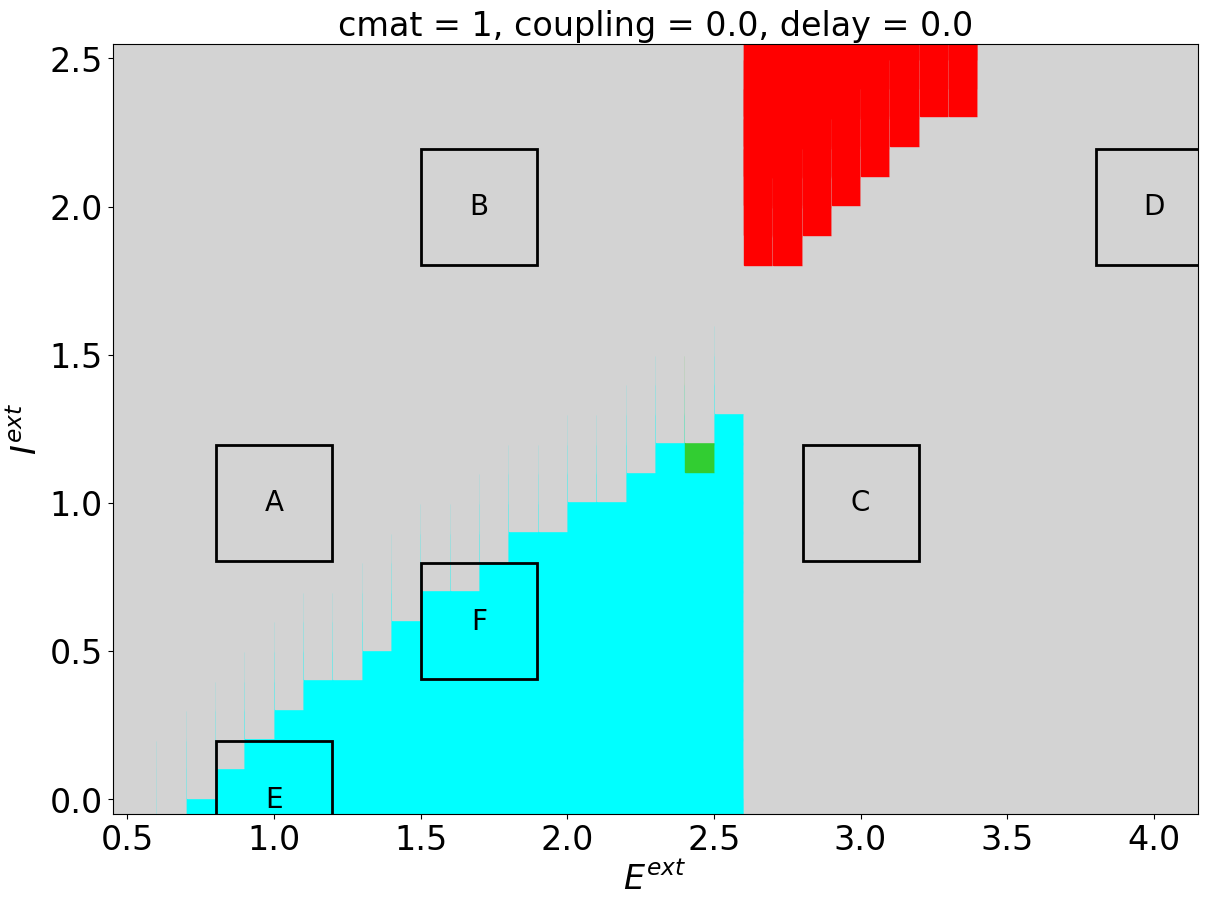

1 1 0


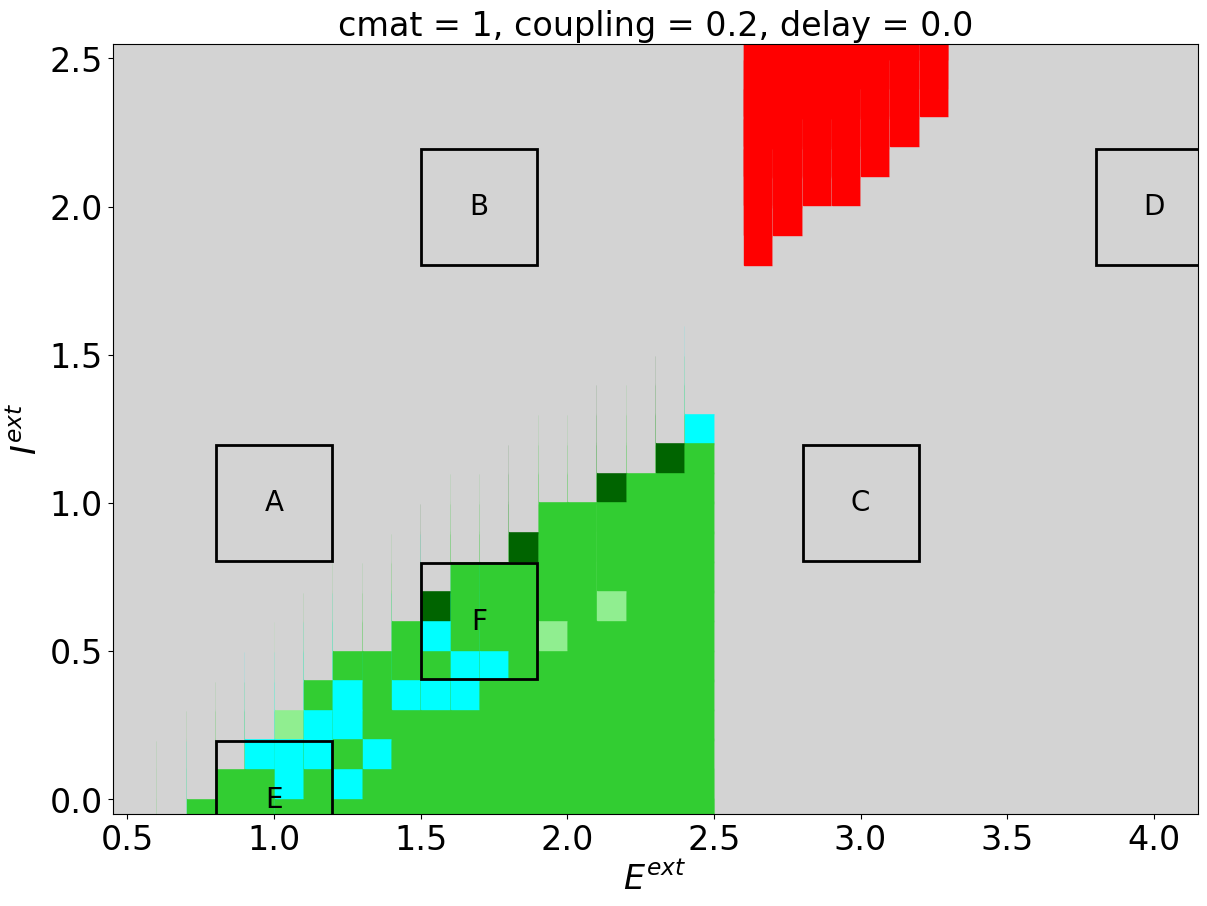

1 1 1


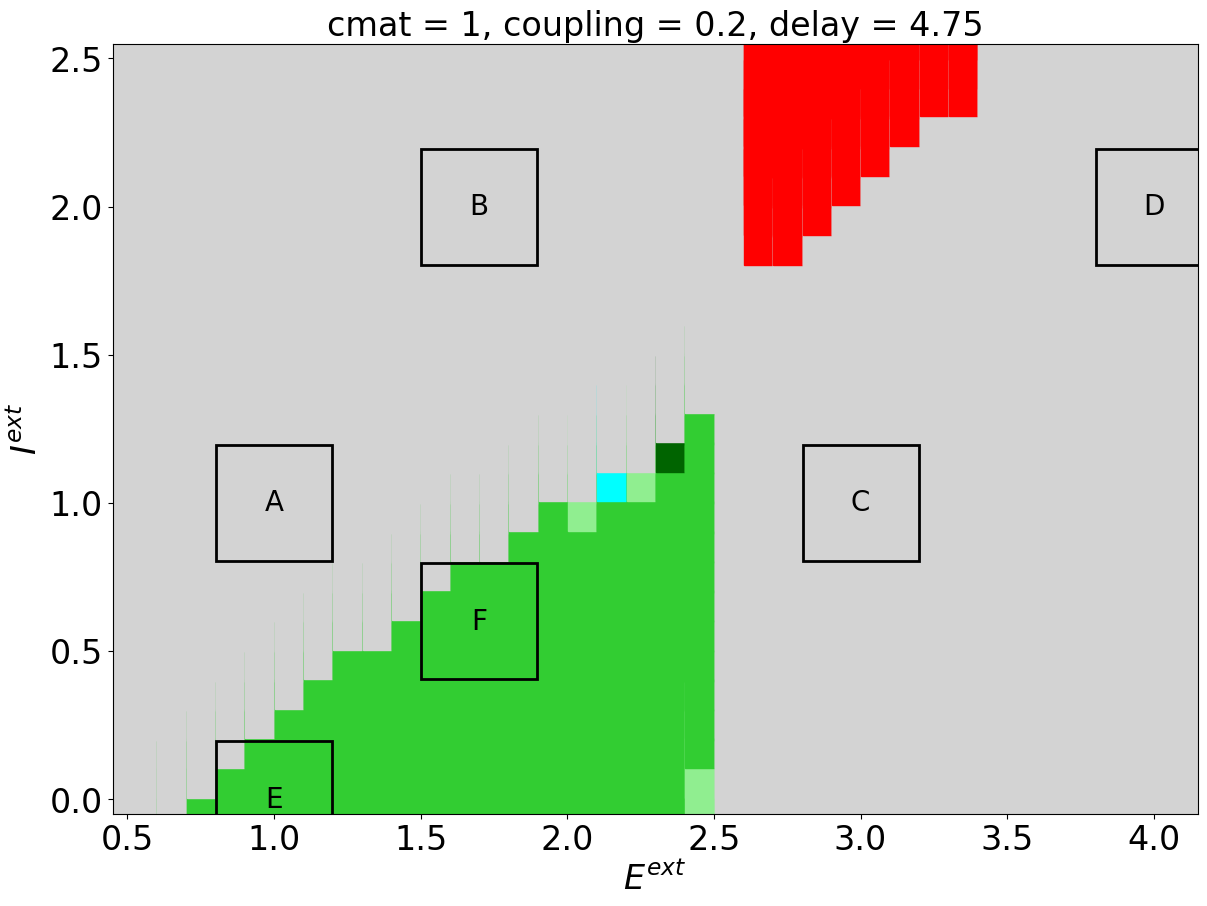

1 1 2


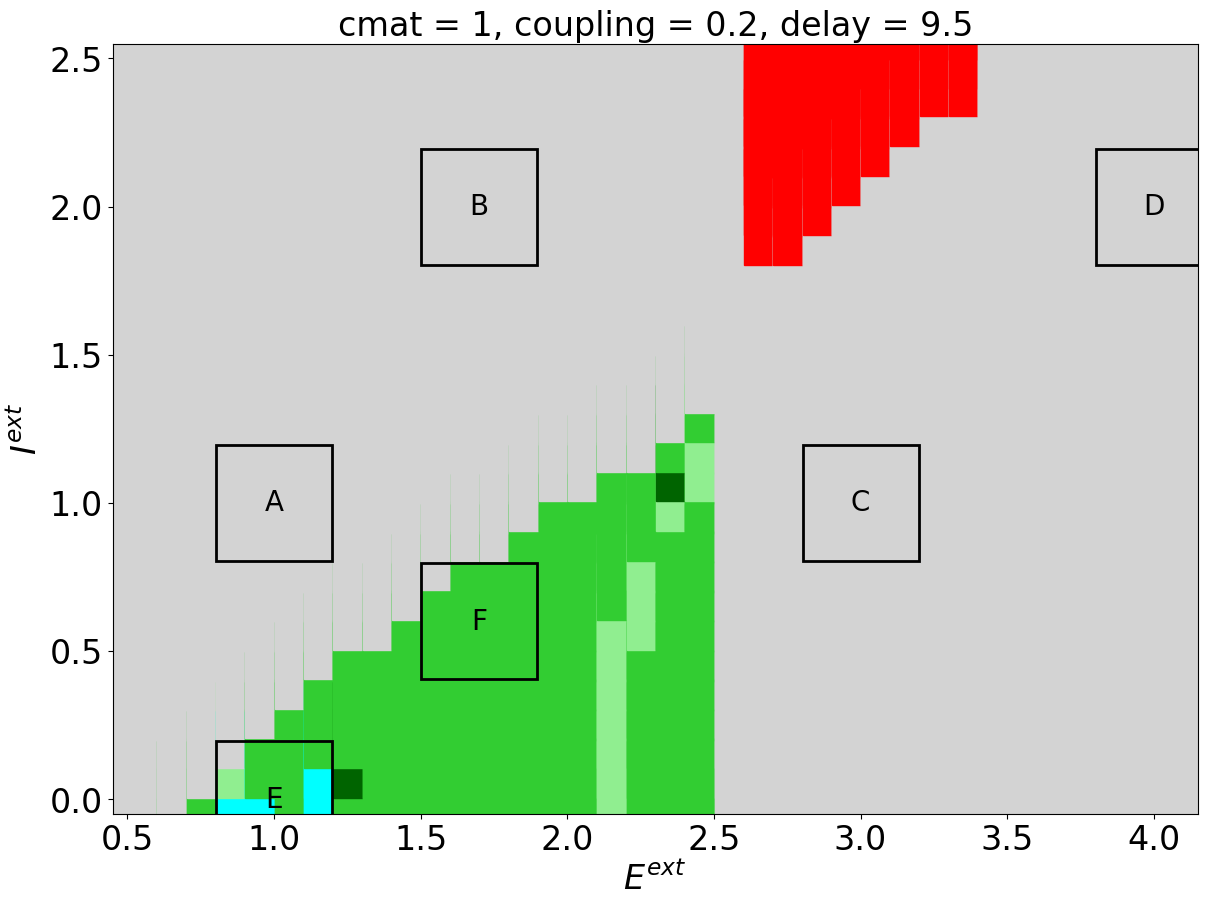

1 1 3


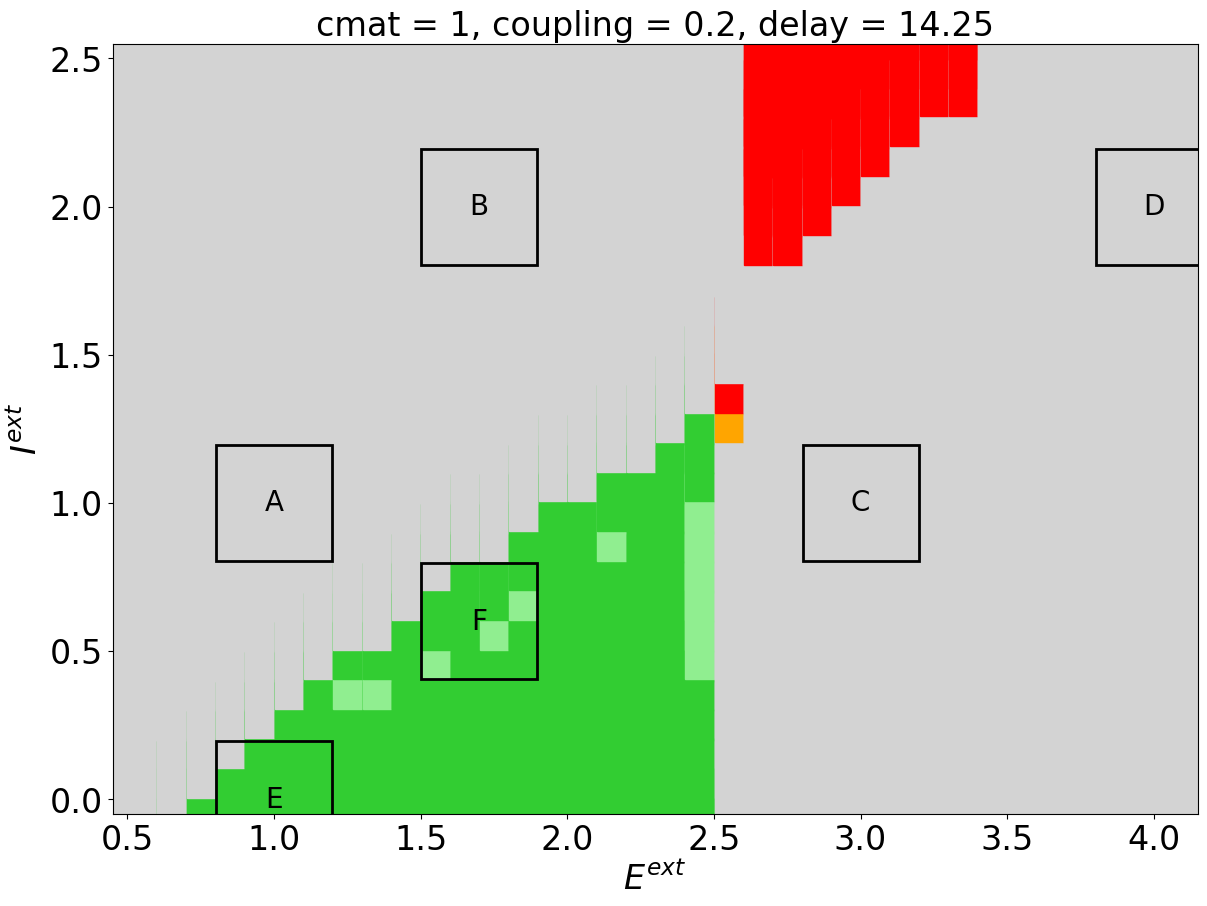

1 1 4


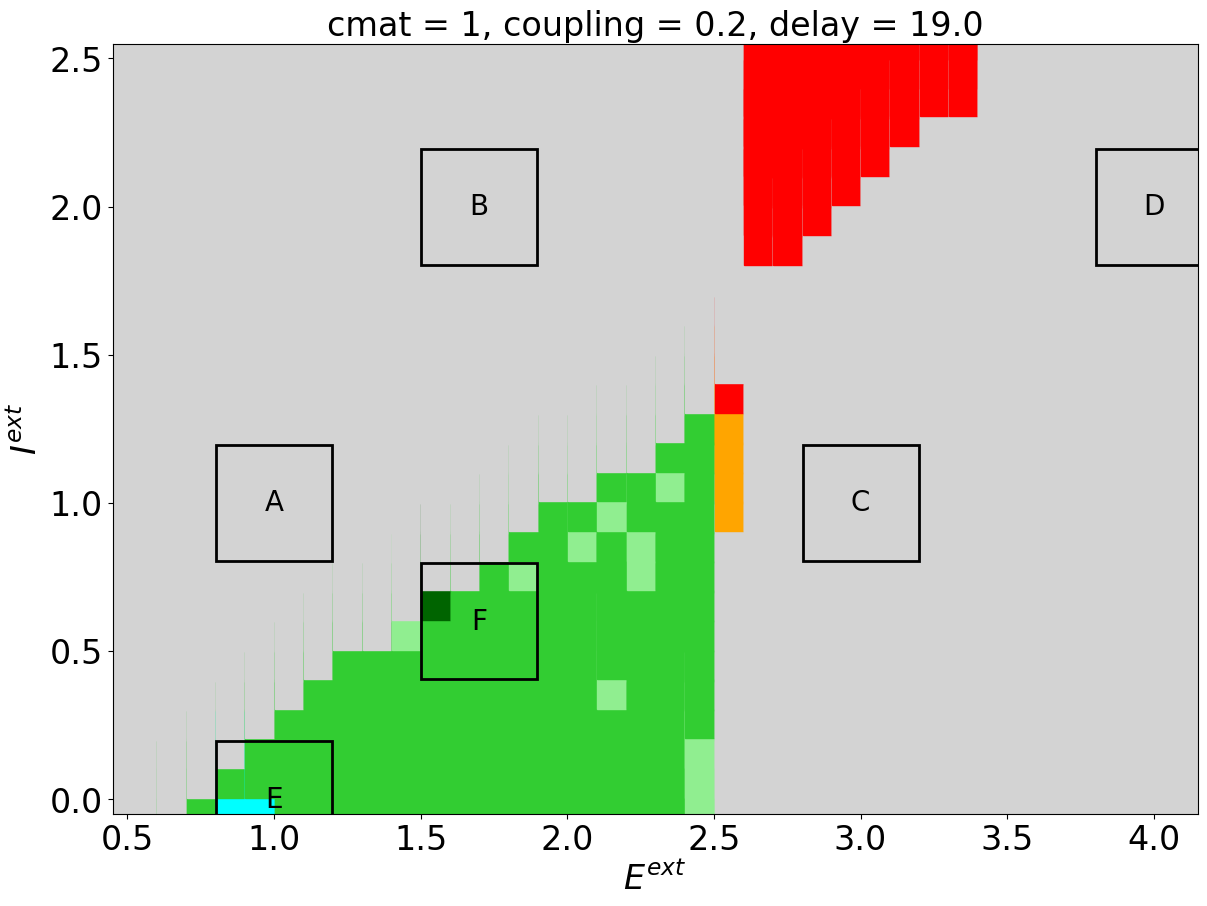

1 2 0


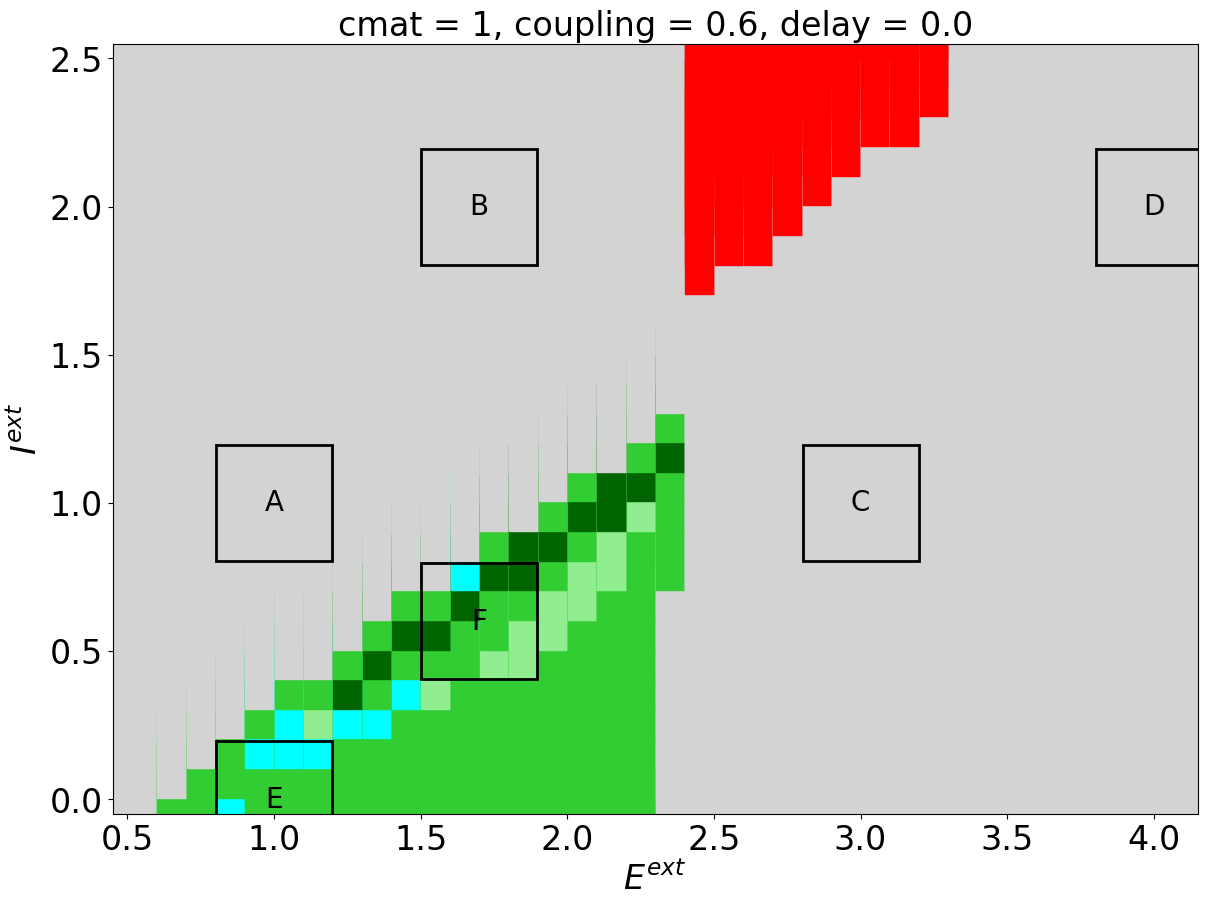

1 2 1


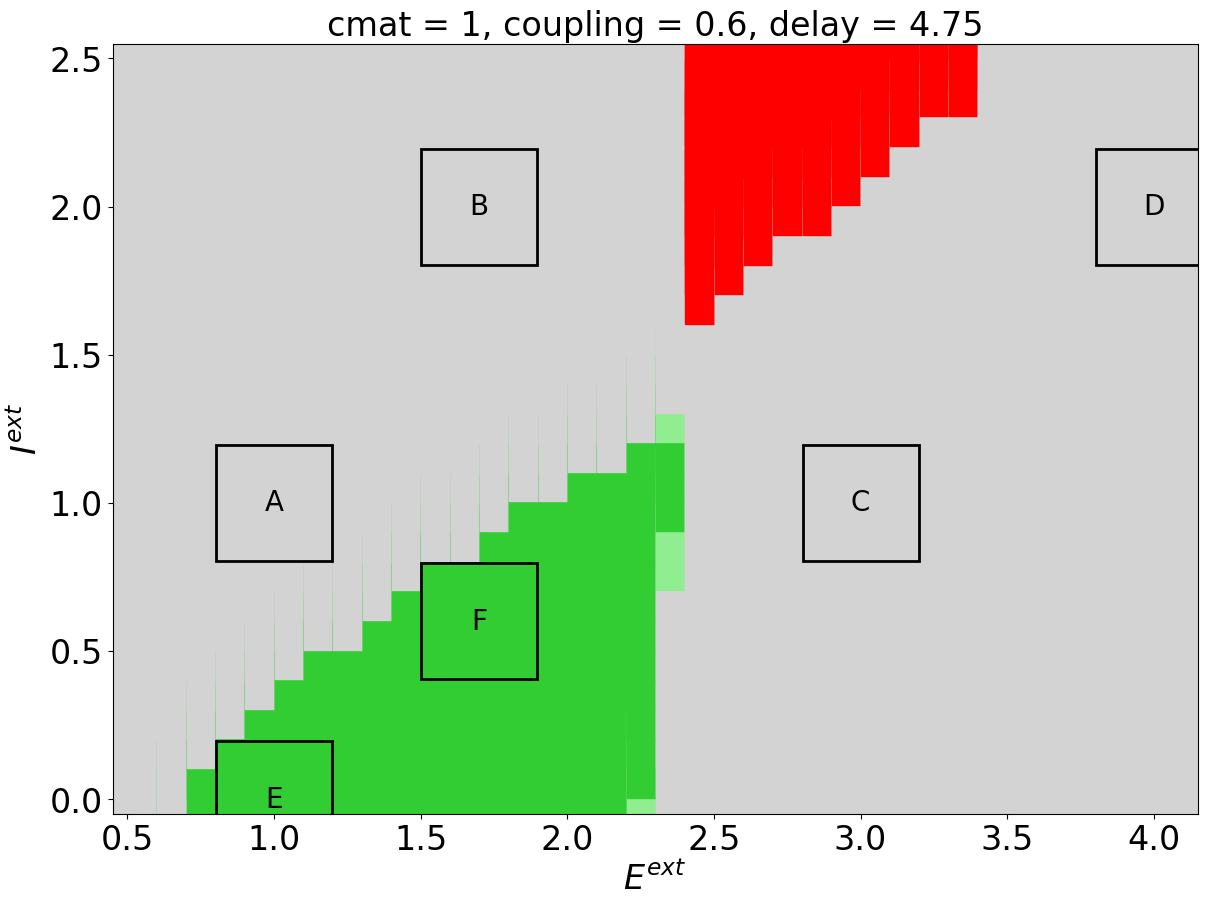

1 2 2


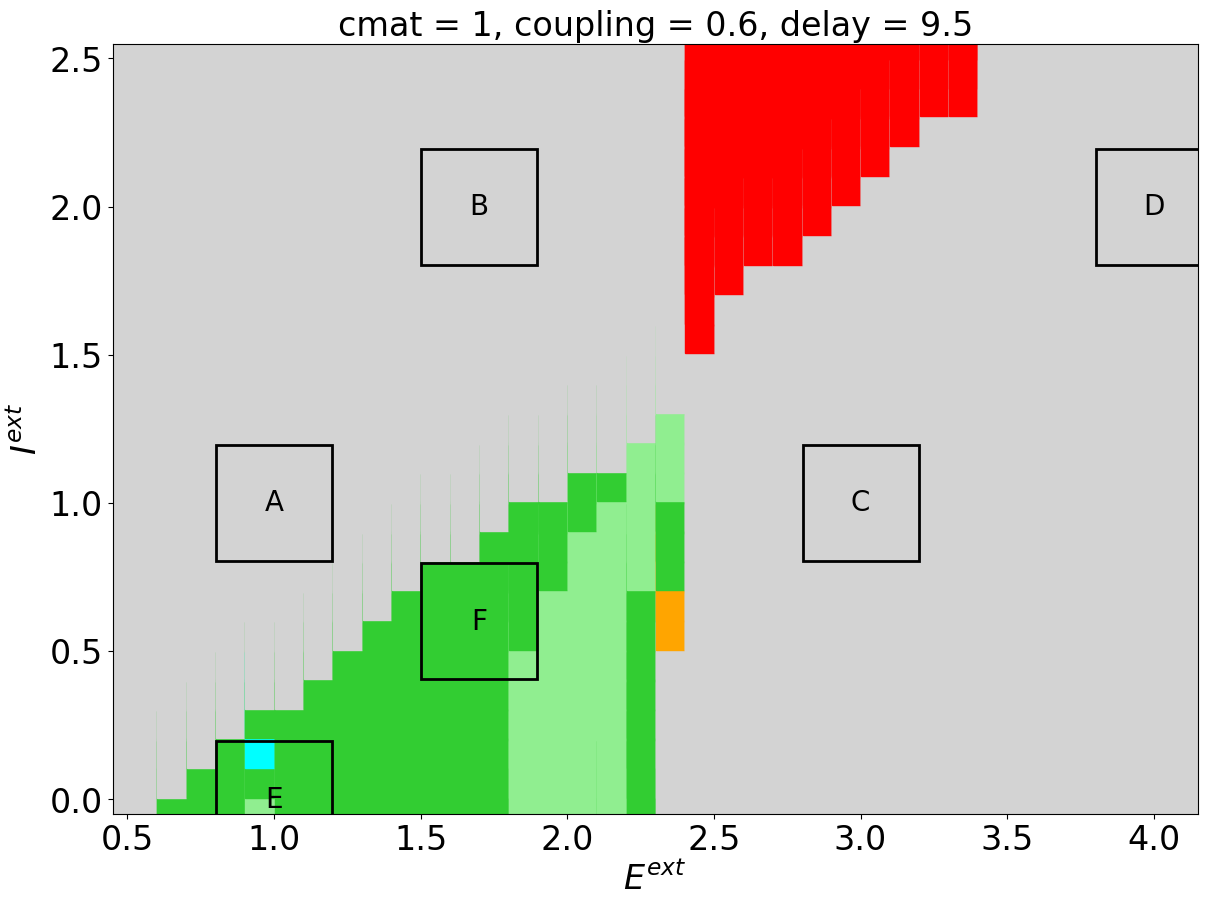

1 2 3


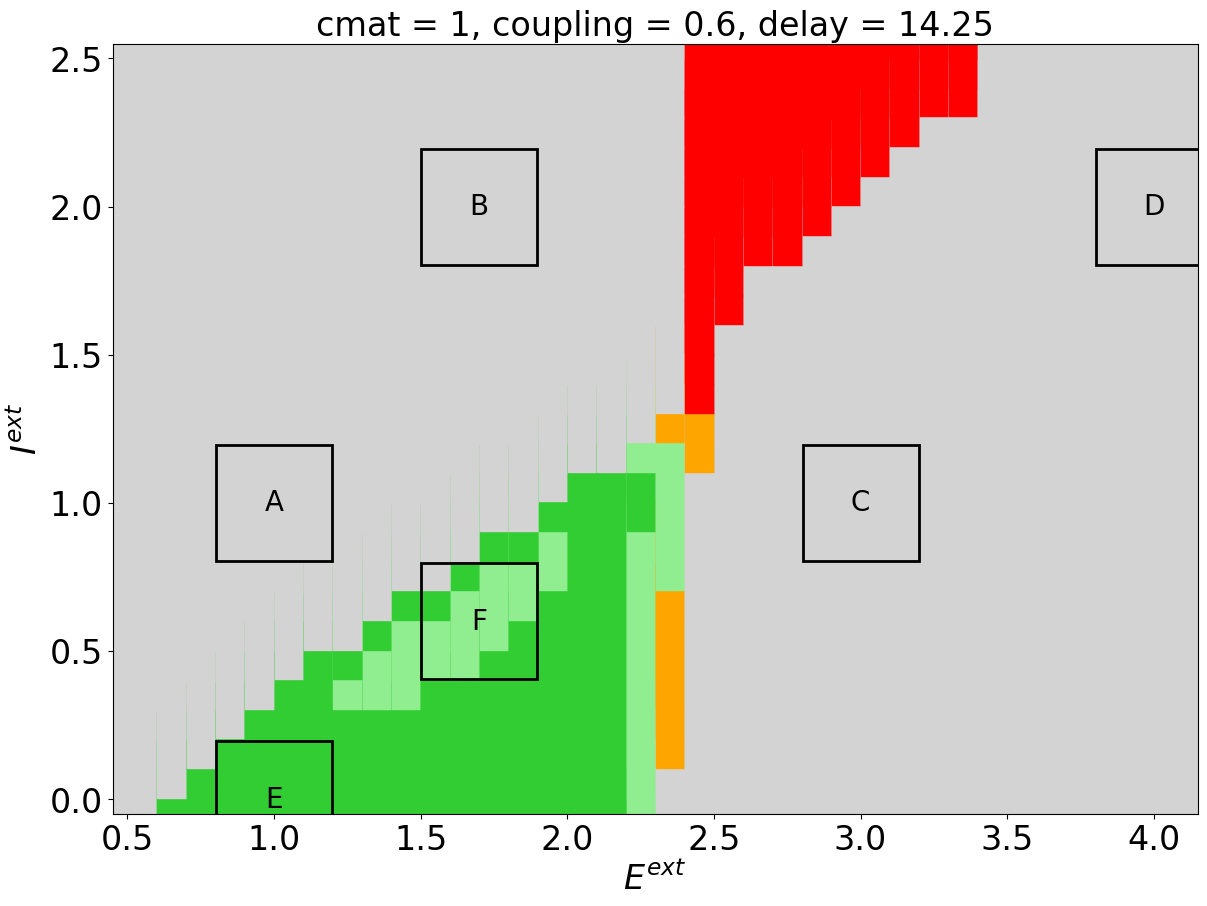

1 2 4


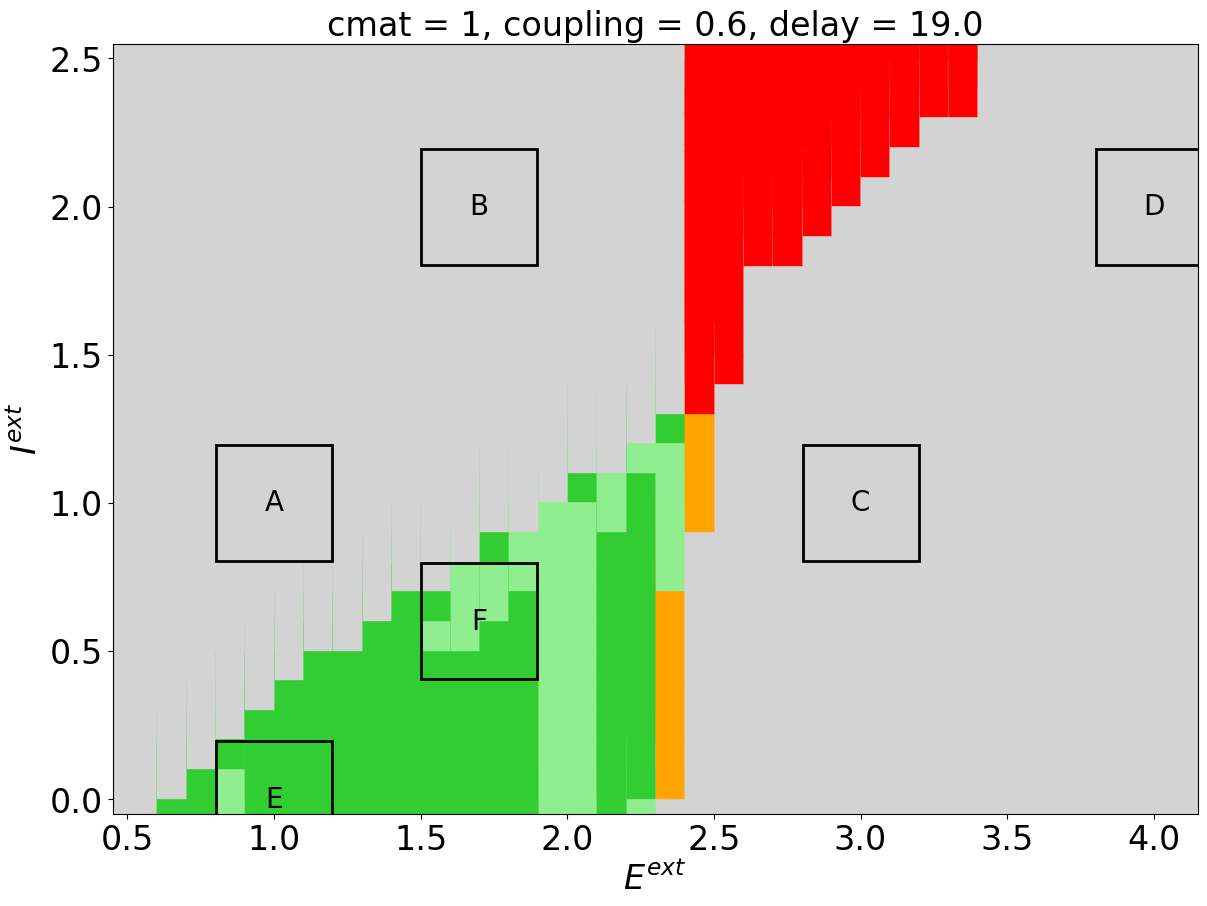

1 3 0


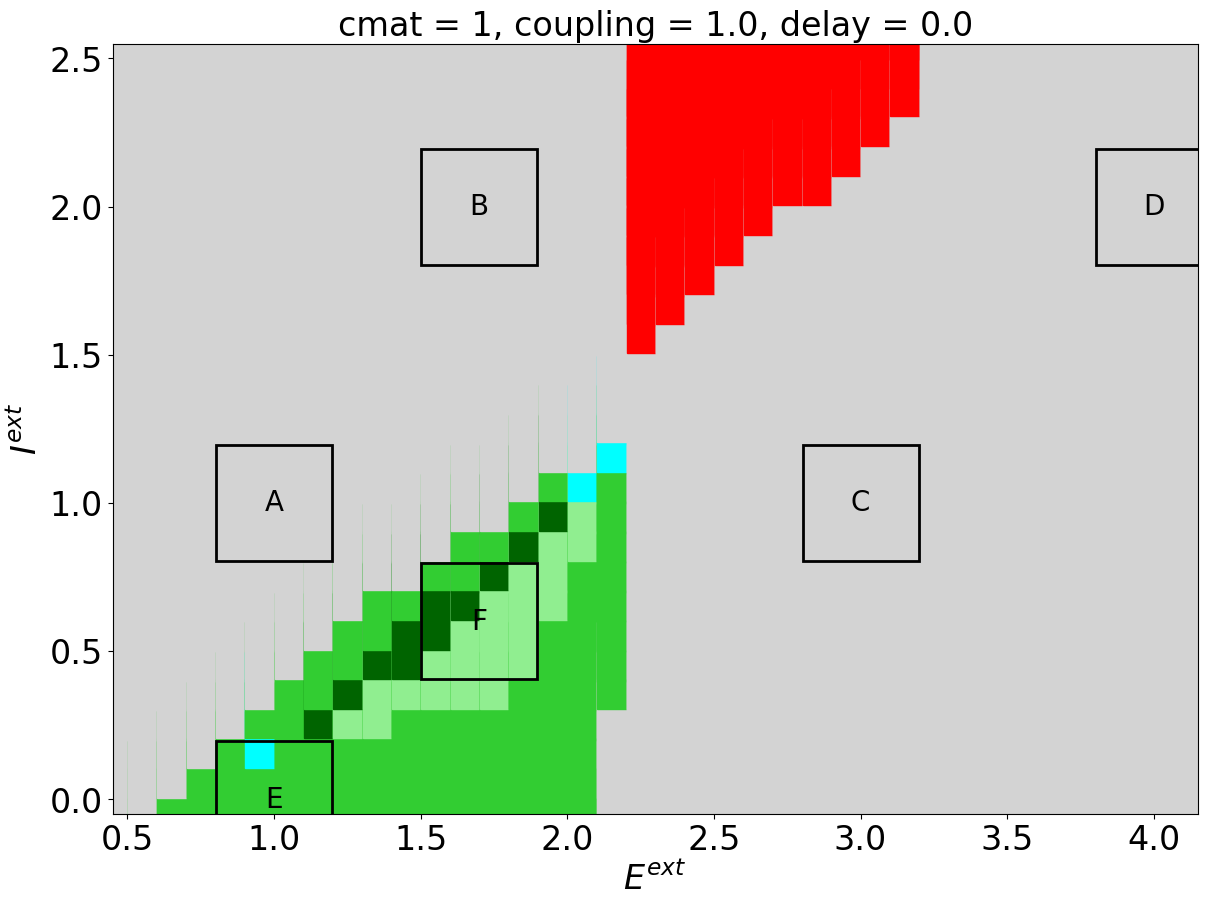

1 3 1


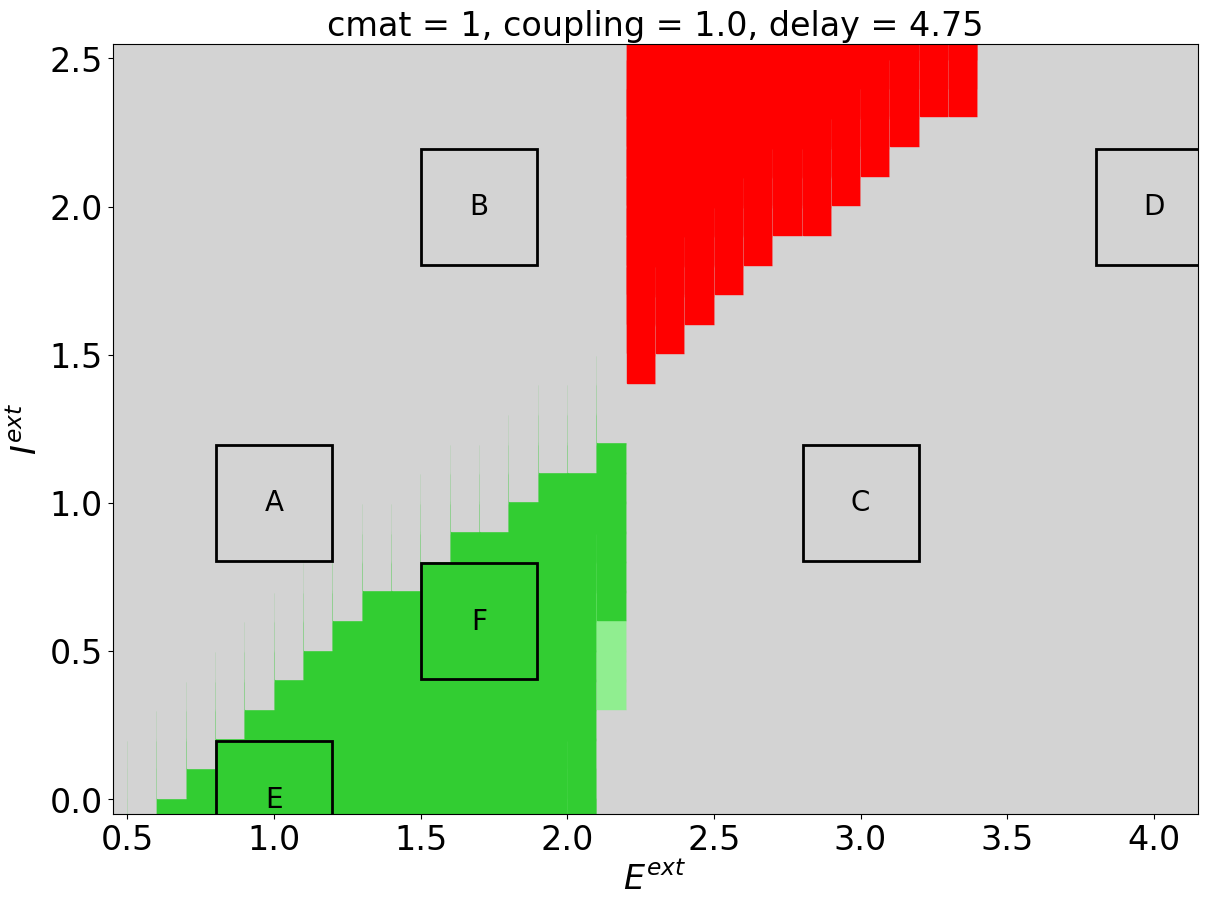

1 3 2


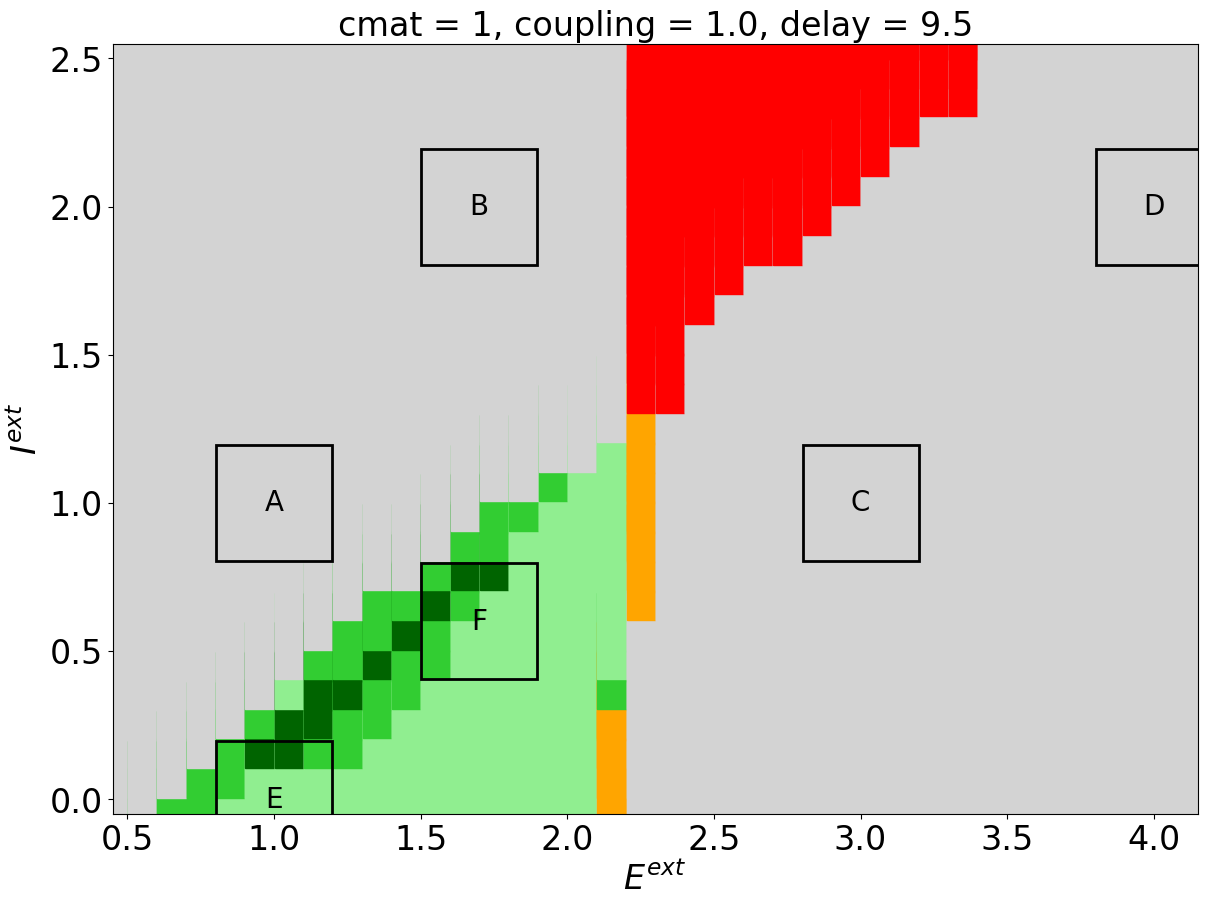

1 3 3


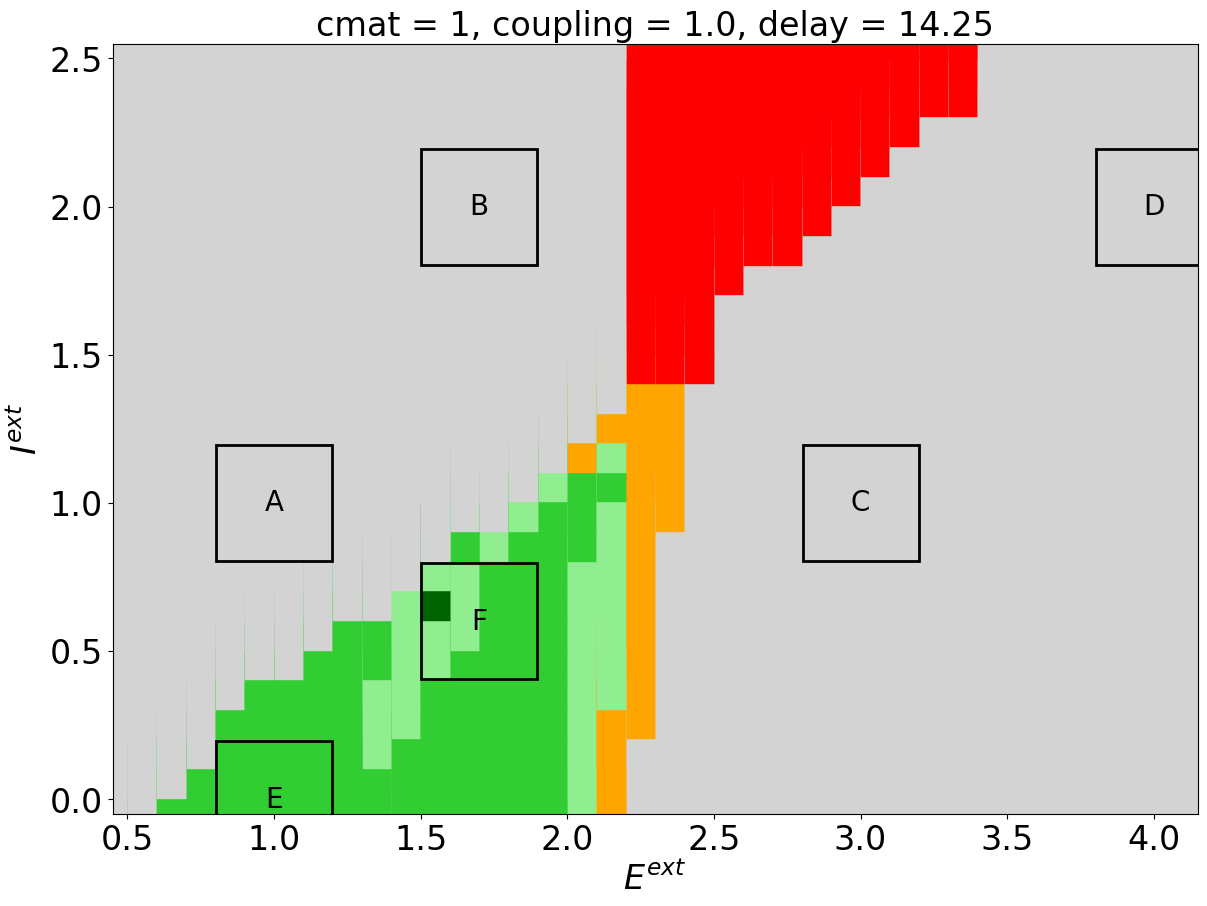

1 3 4


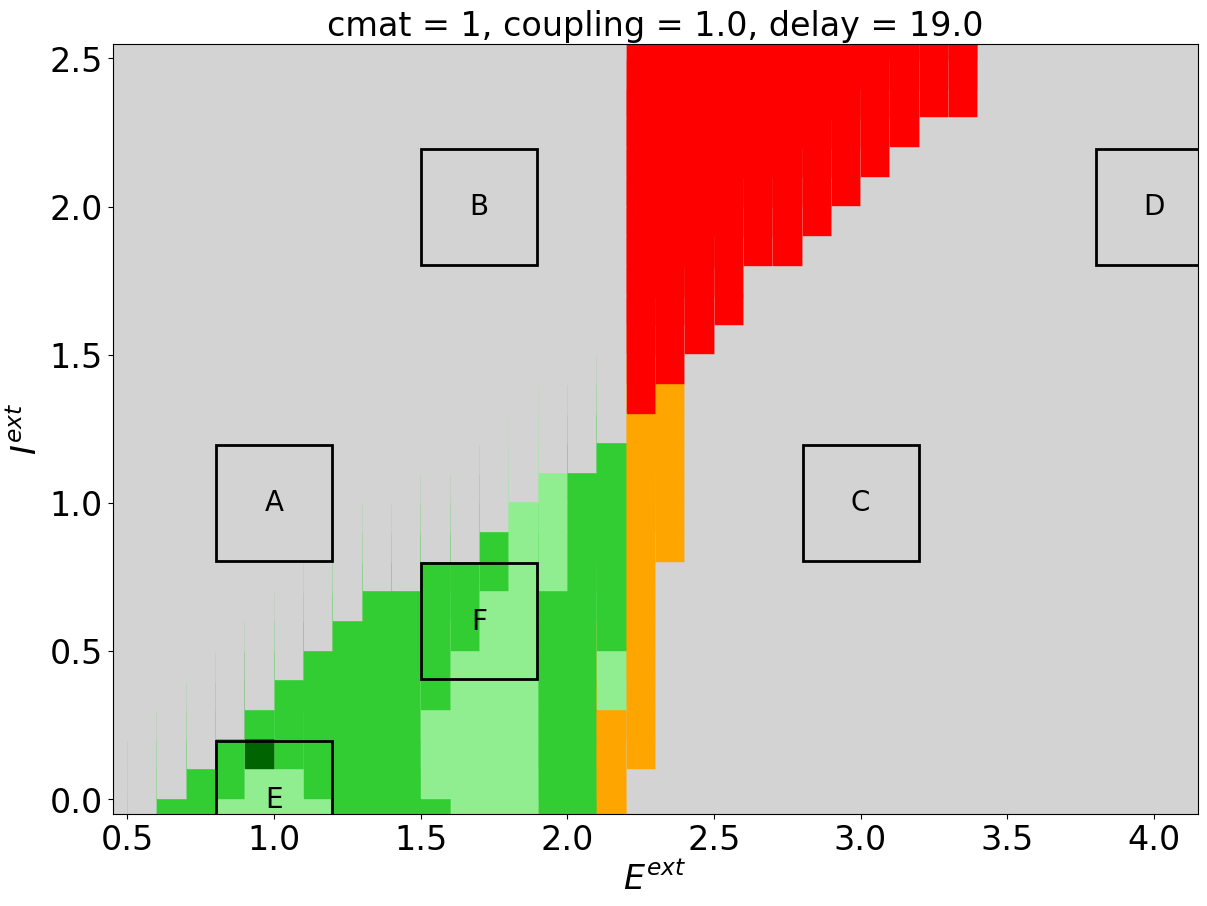

1 4 0


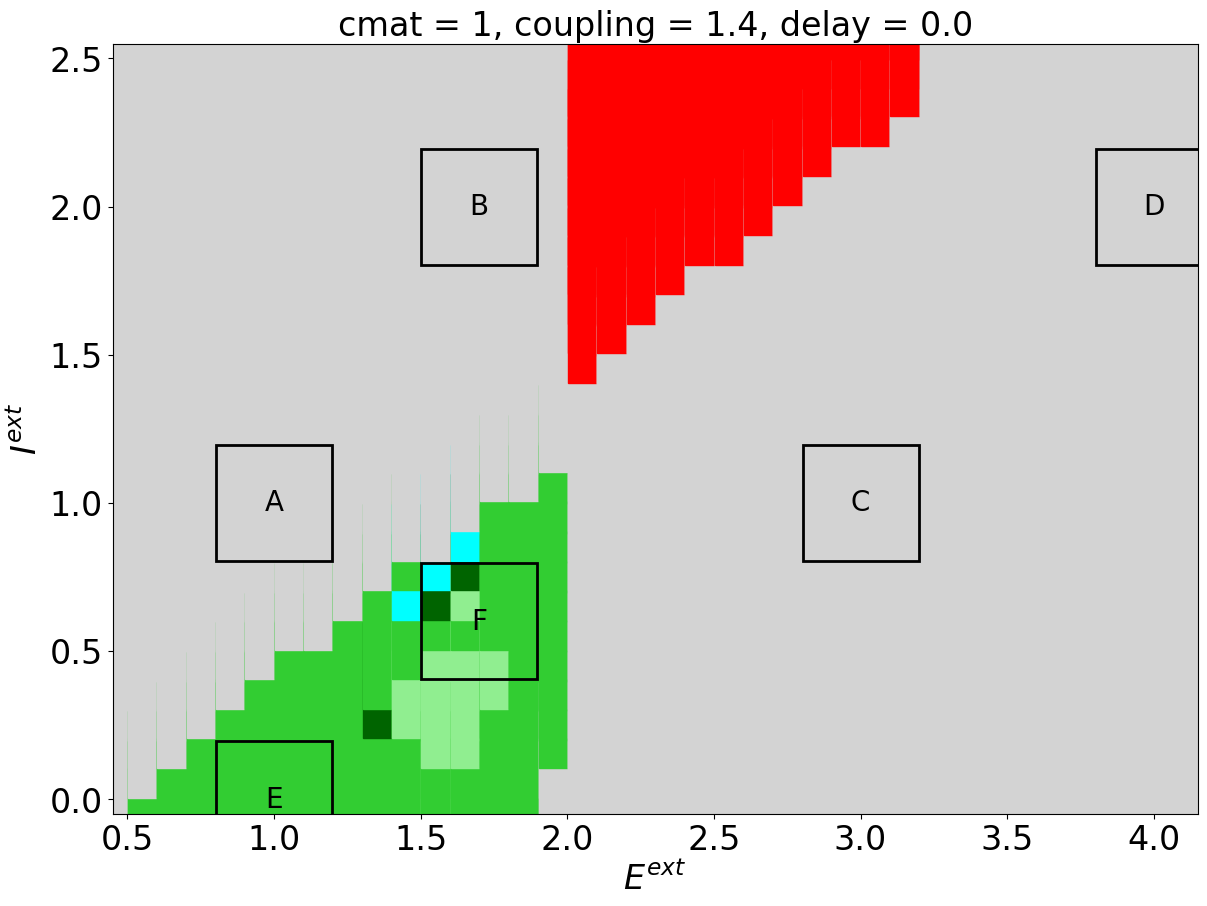

1 4 1


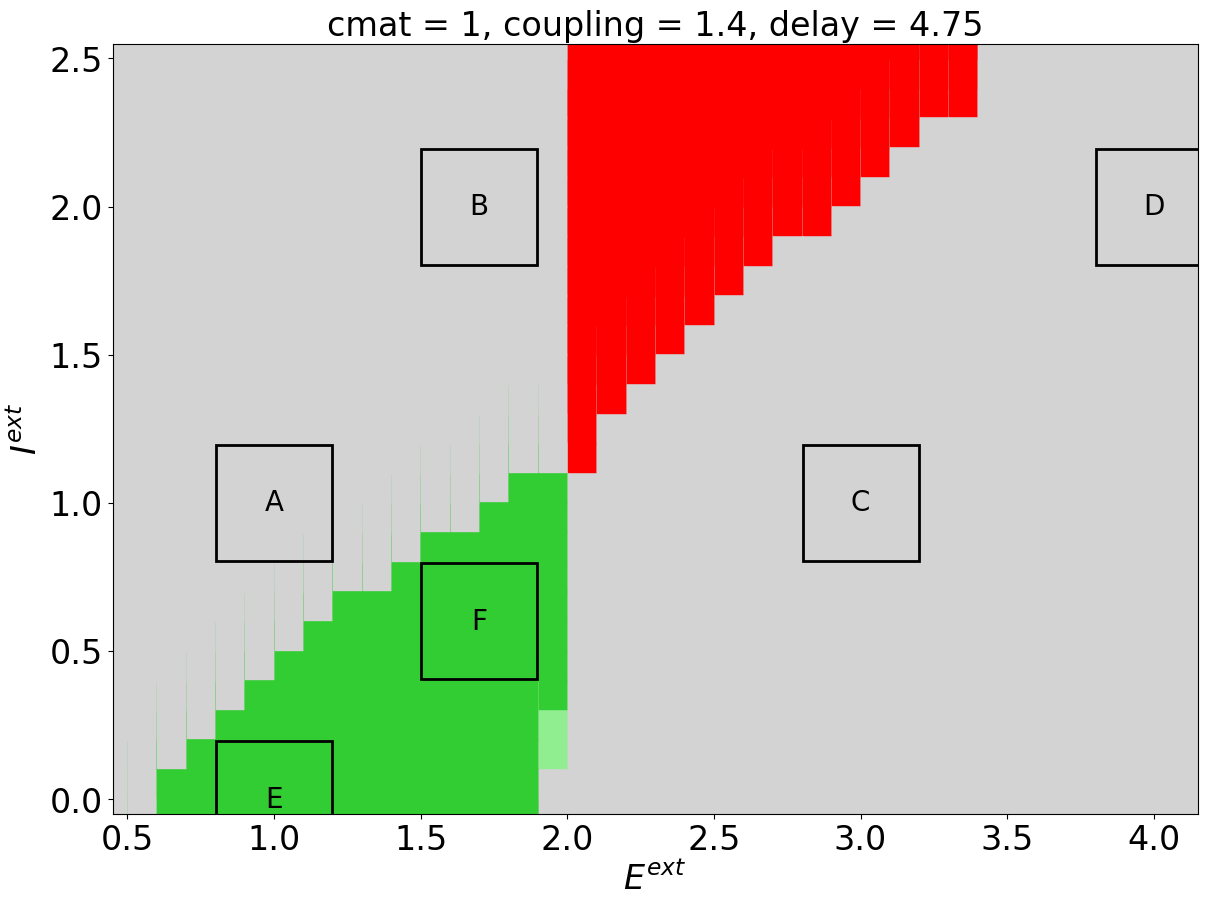

1 4 2


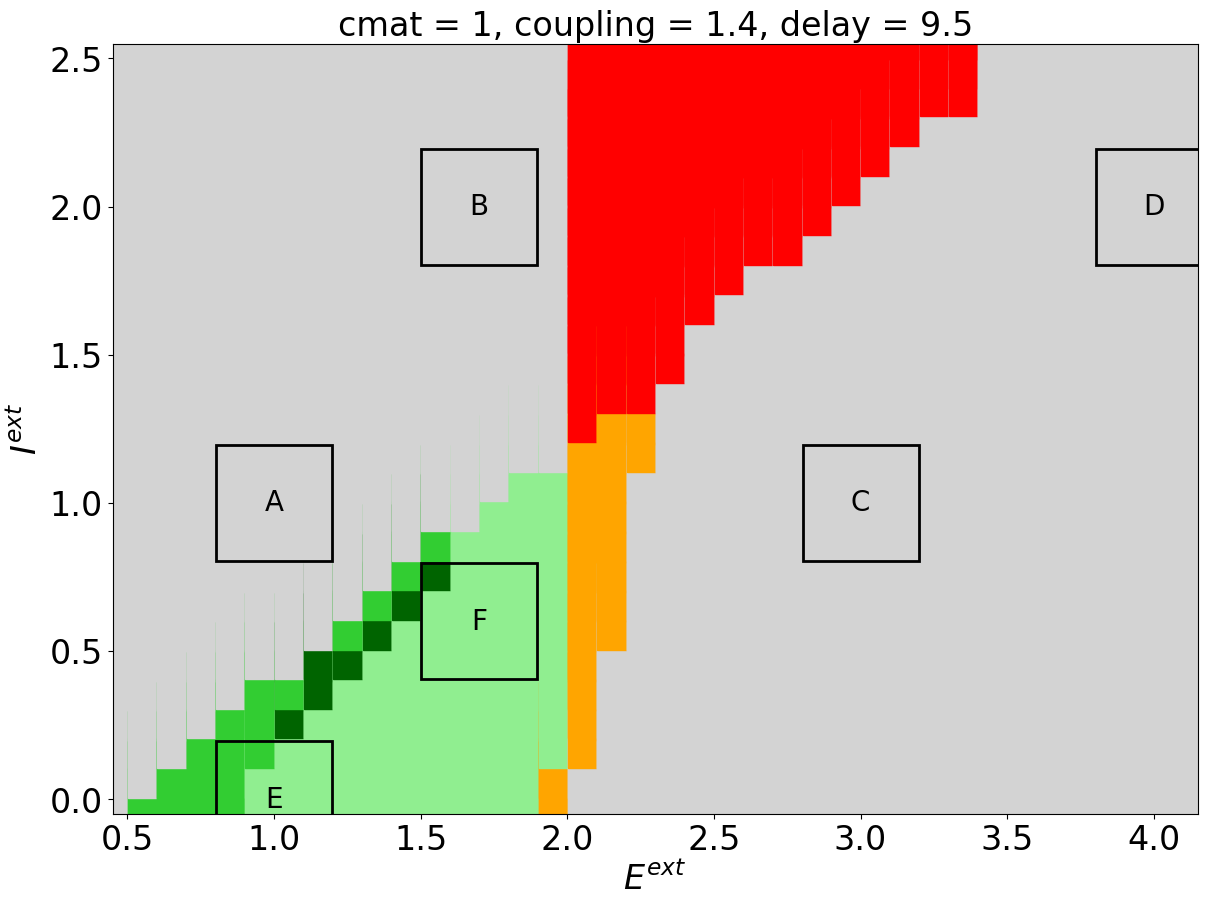

1 4 3


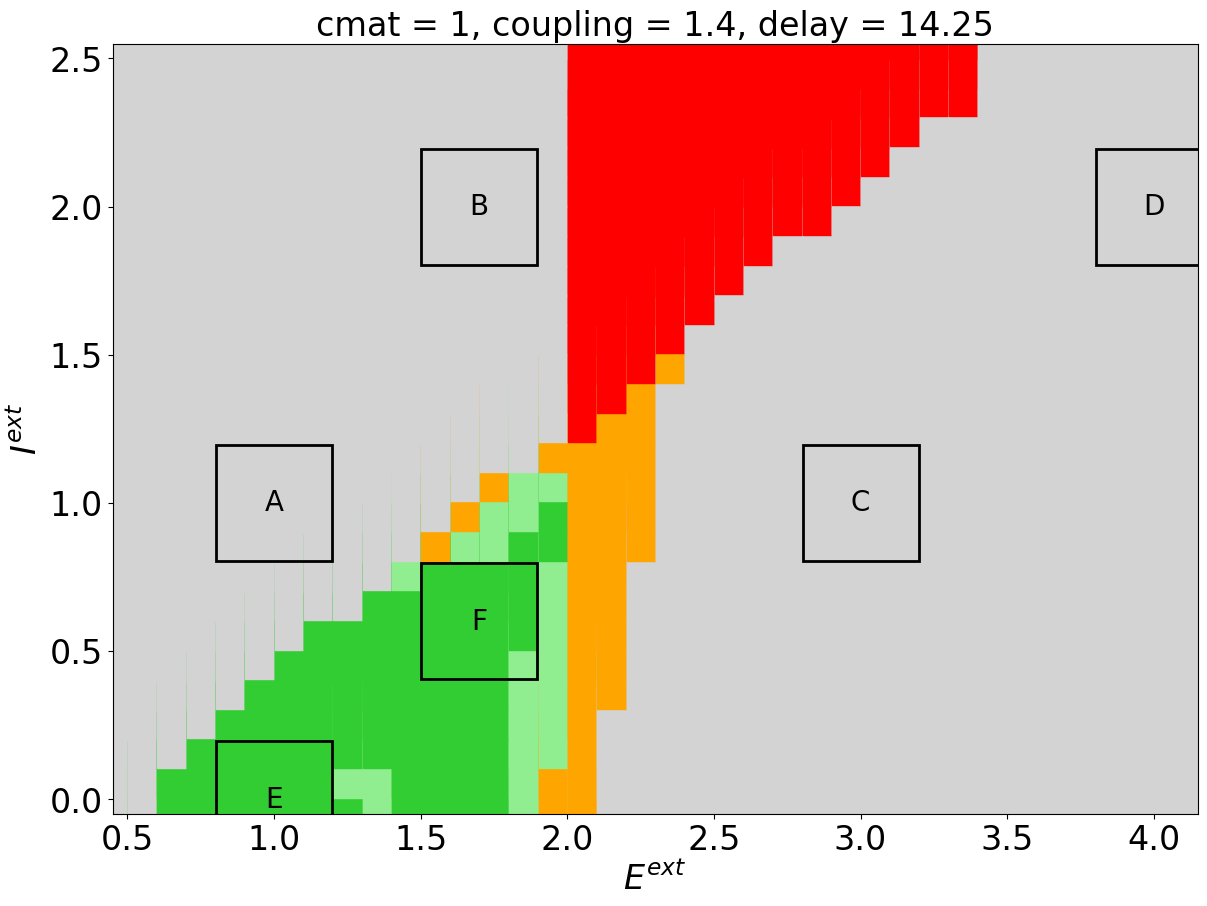

1 4 4


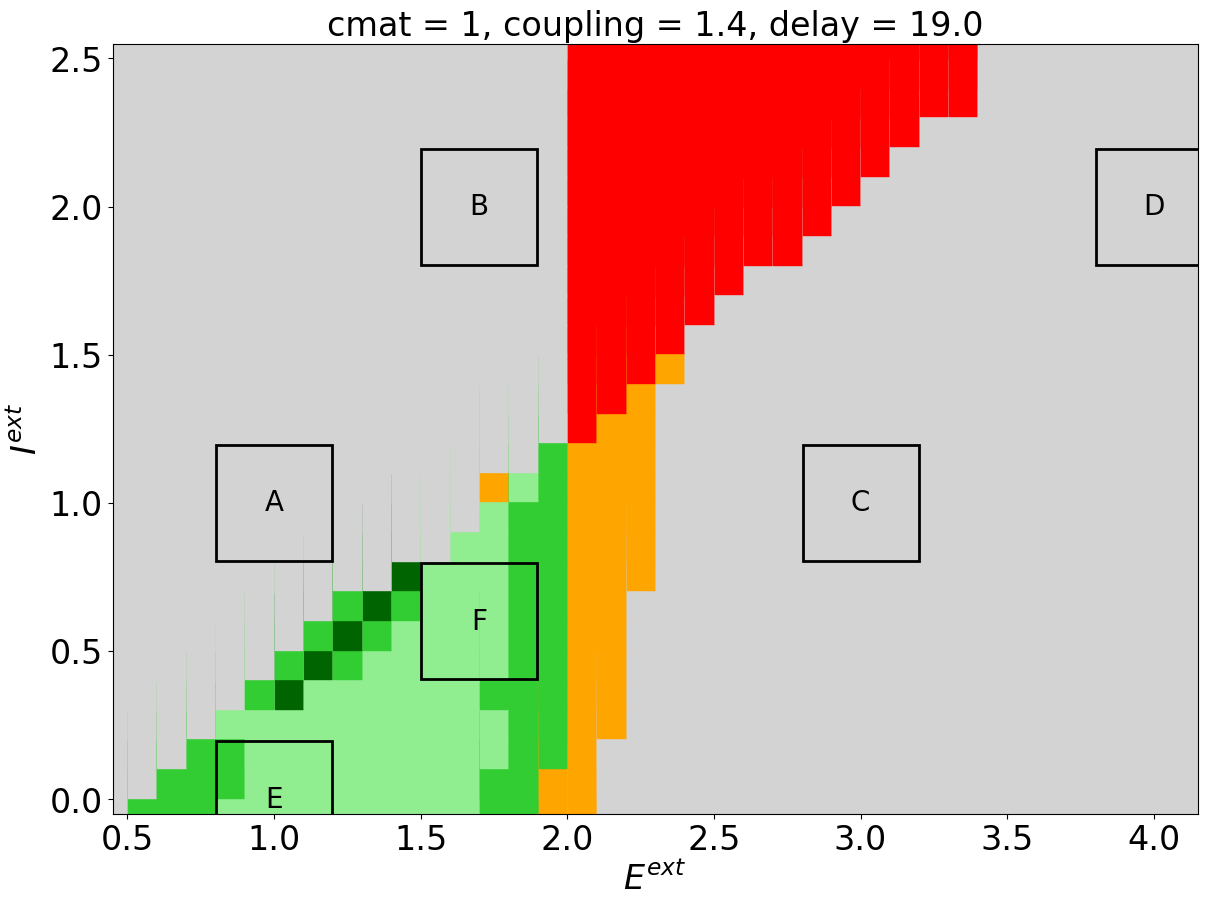

1 5 0


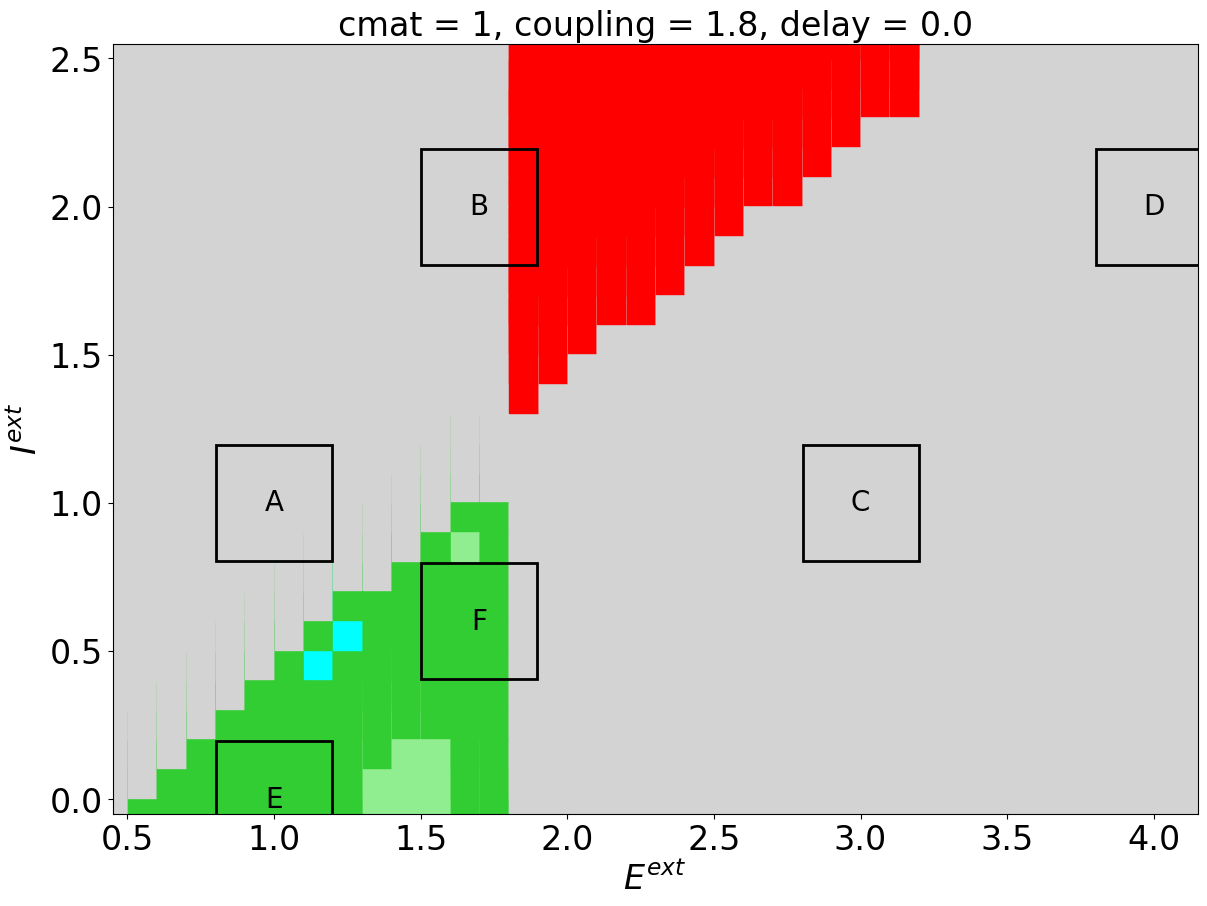

1 5 1


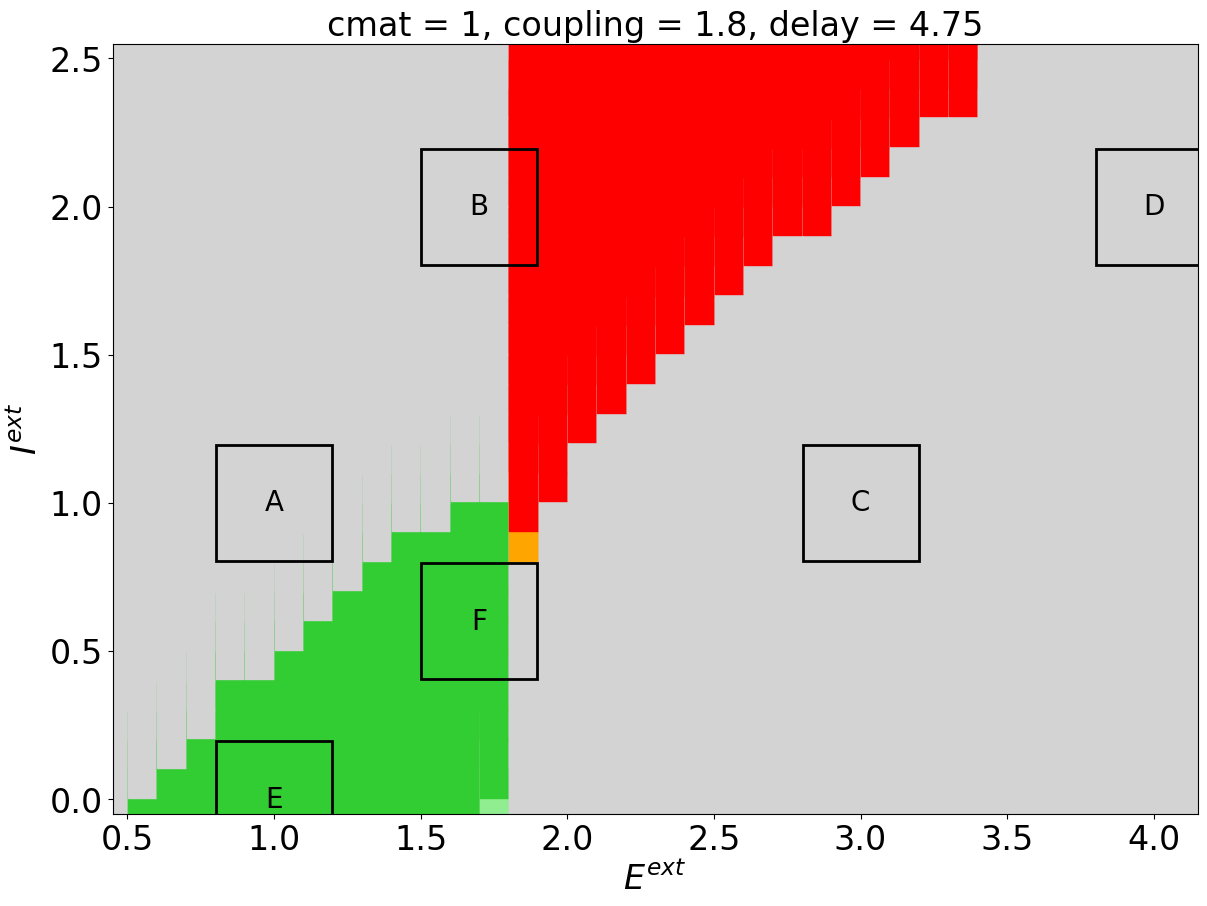

1 5 2


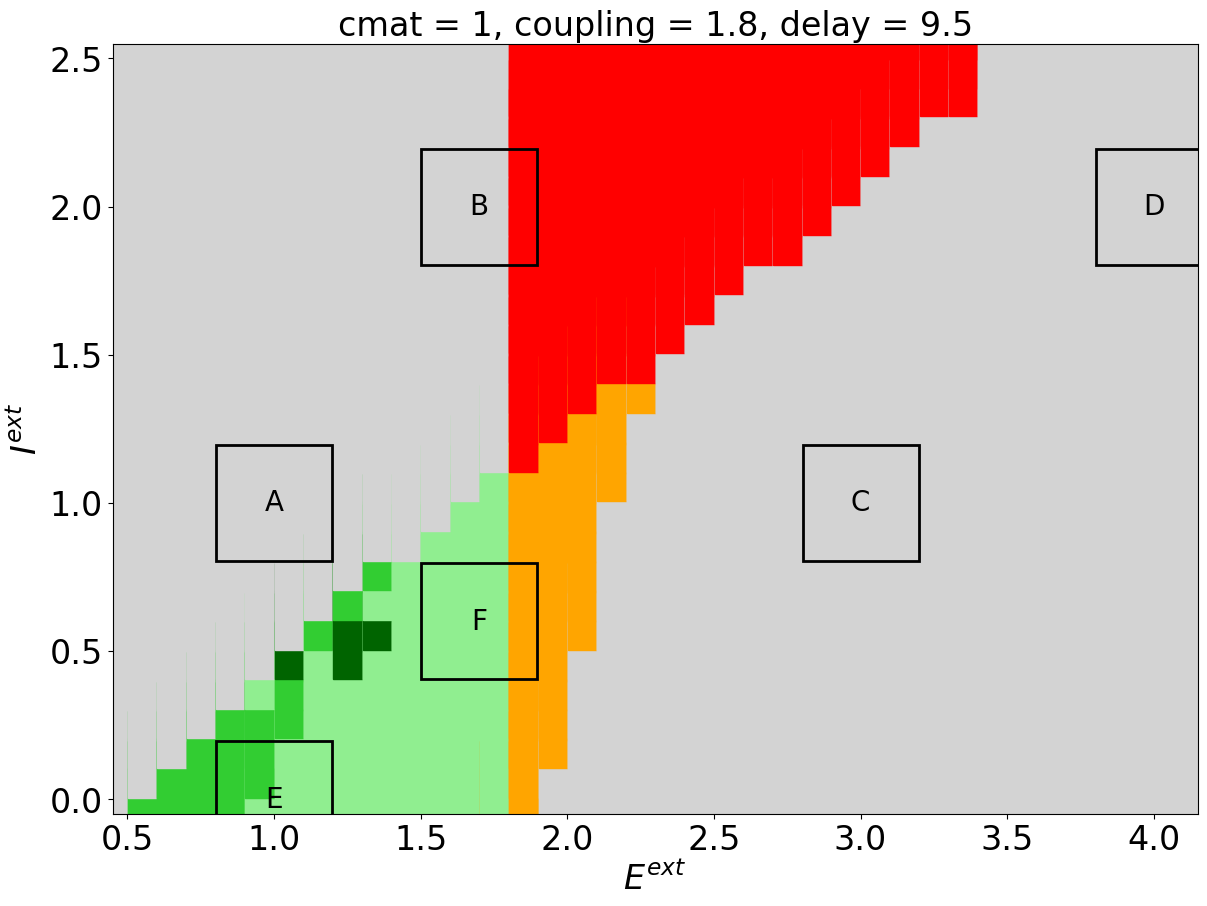

1 5 3


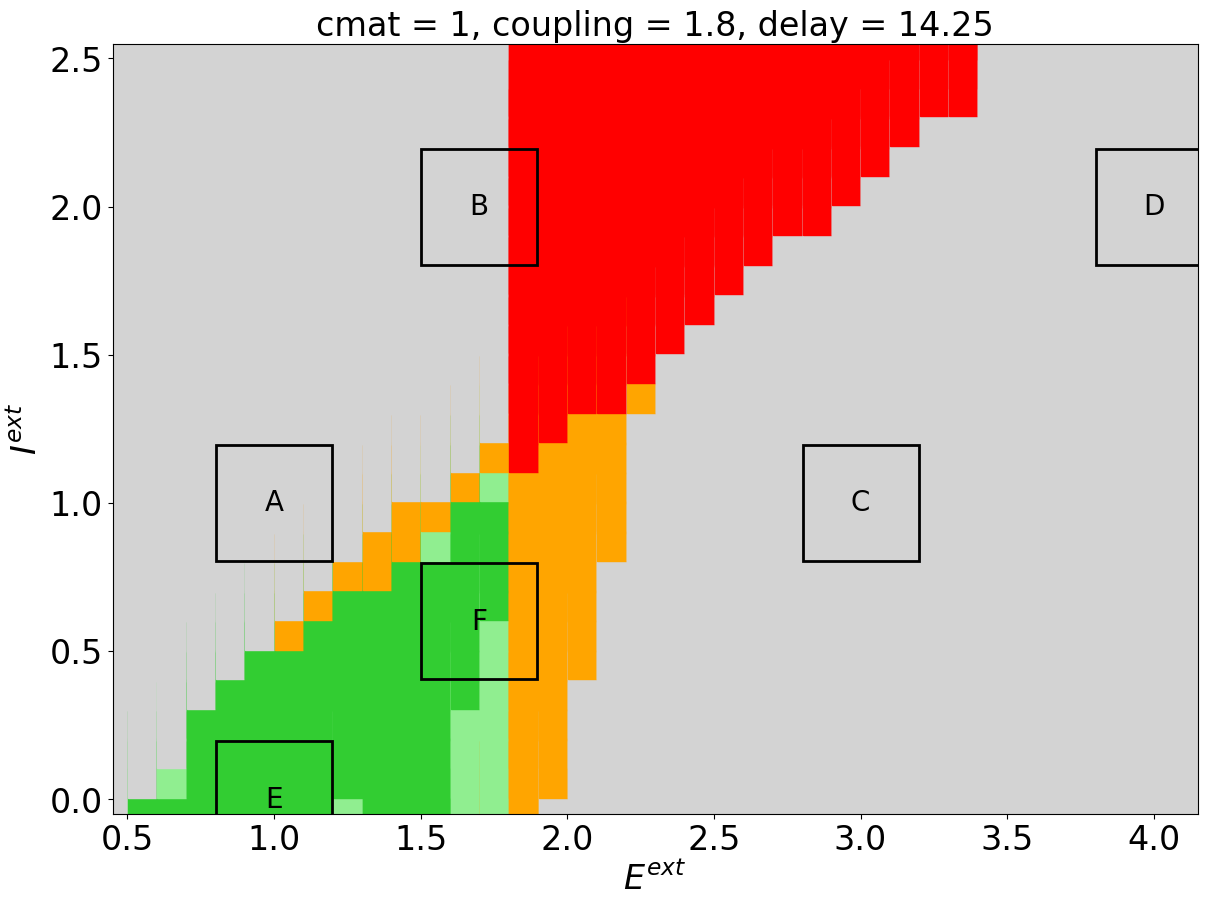

1 5 4


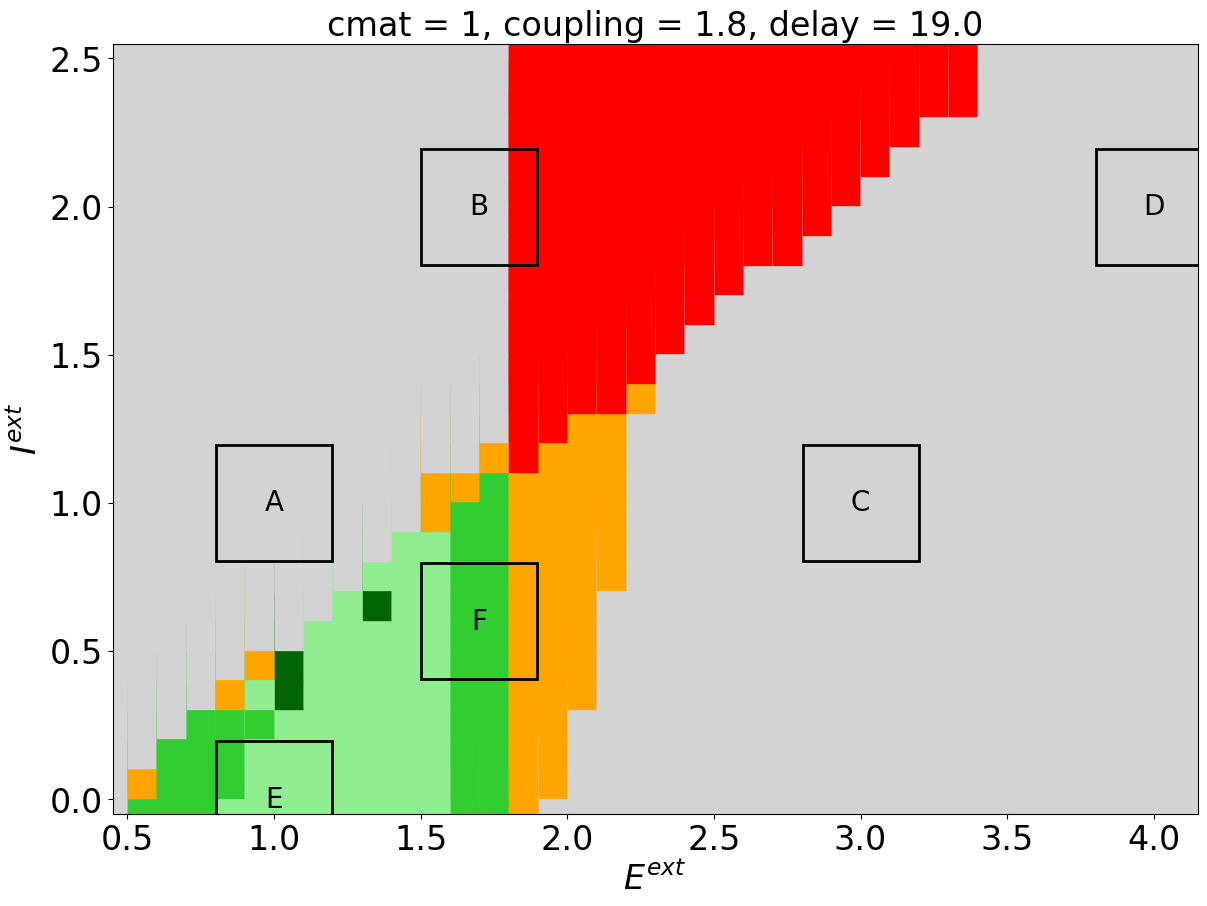

1 6 0


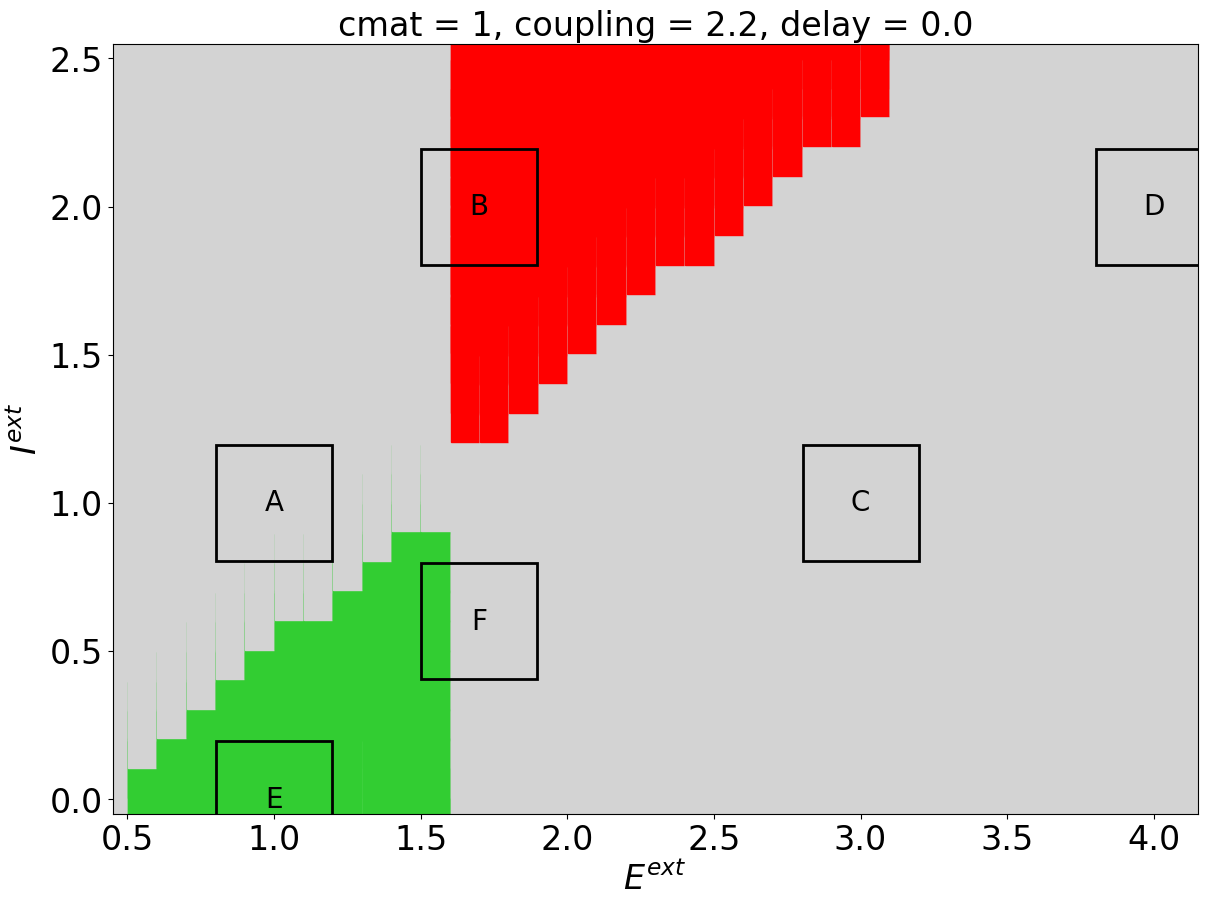

1 6 1


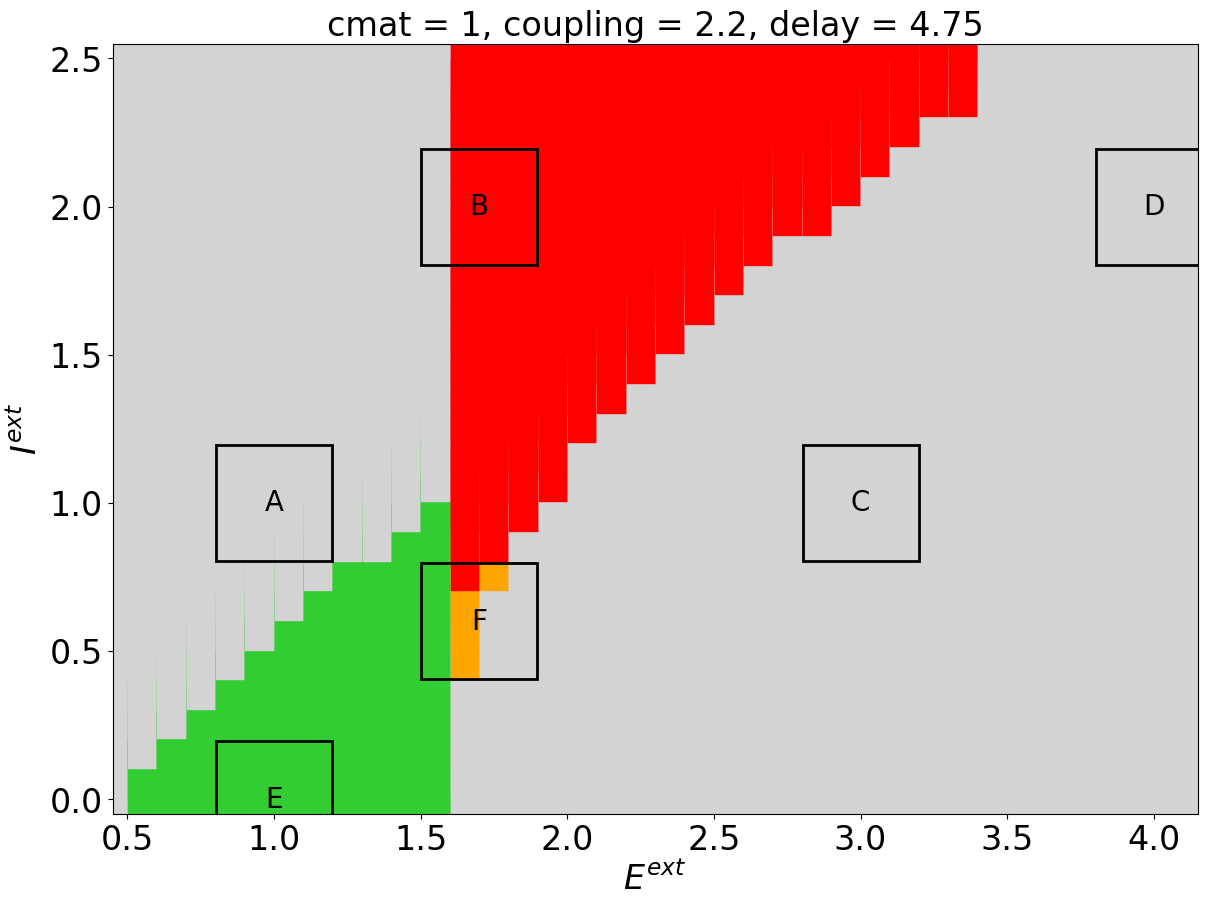

1 6 2


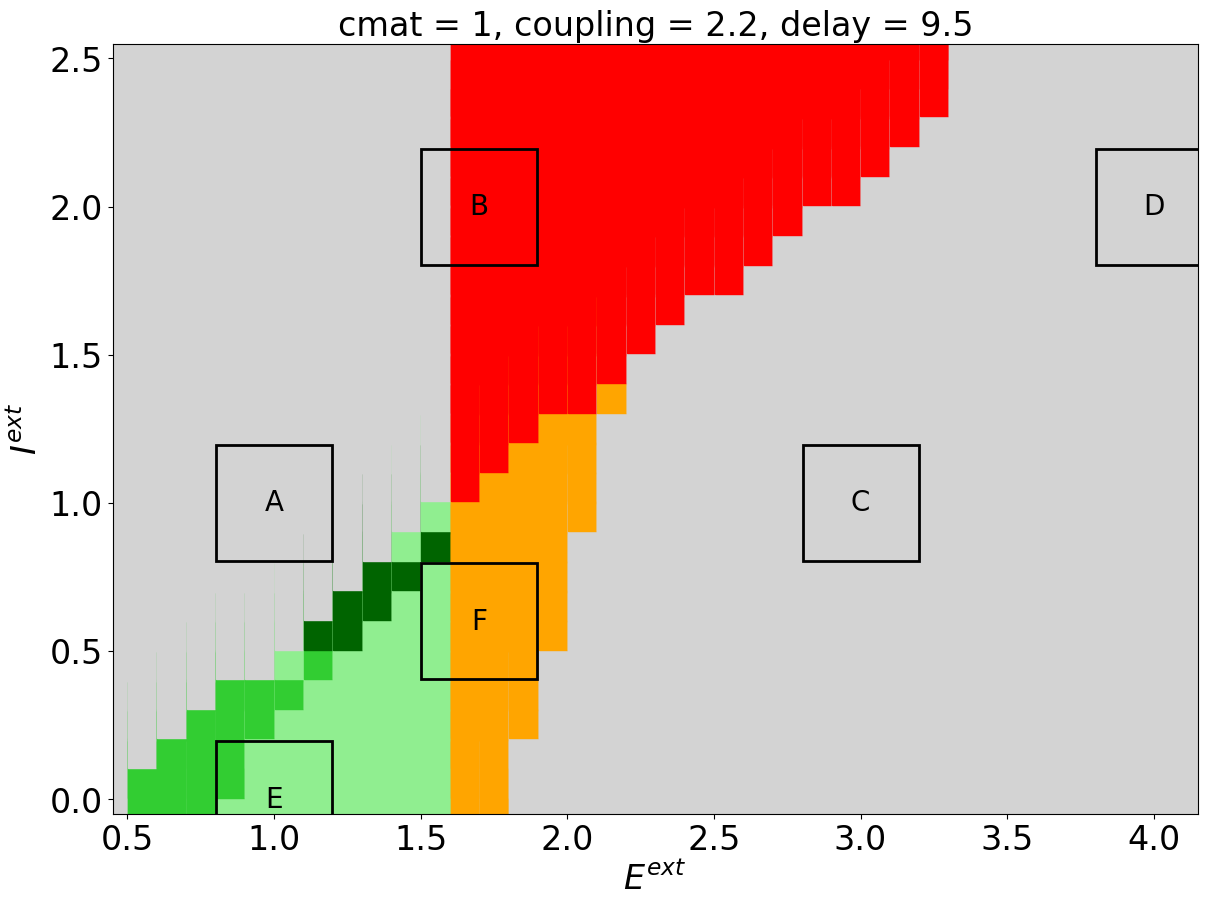

1 6 3


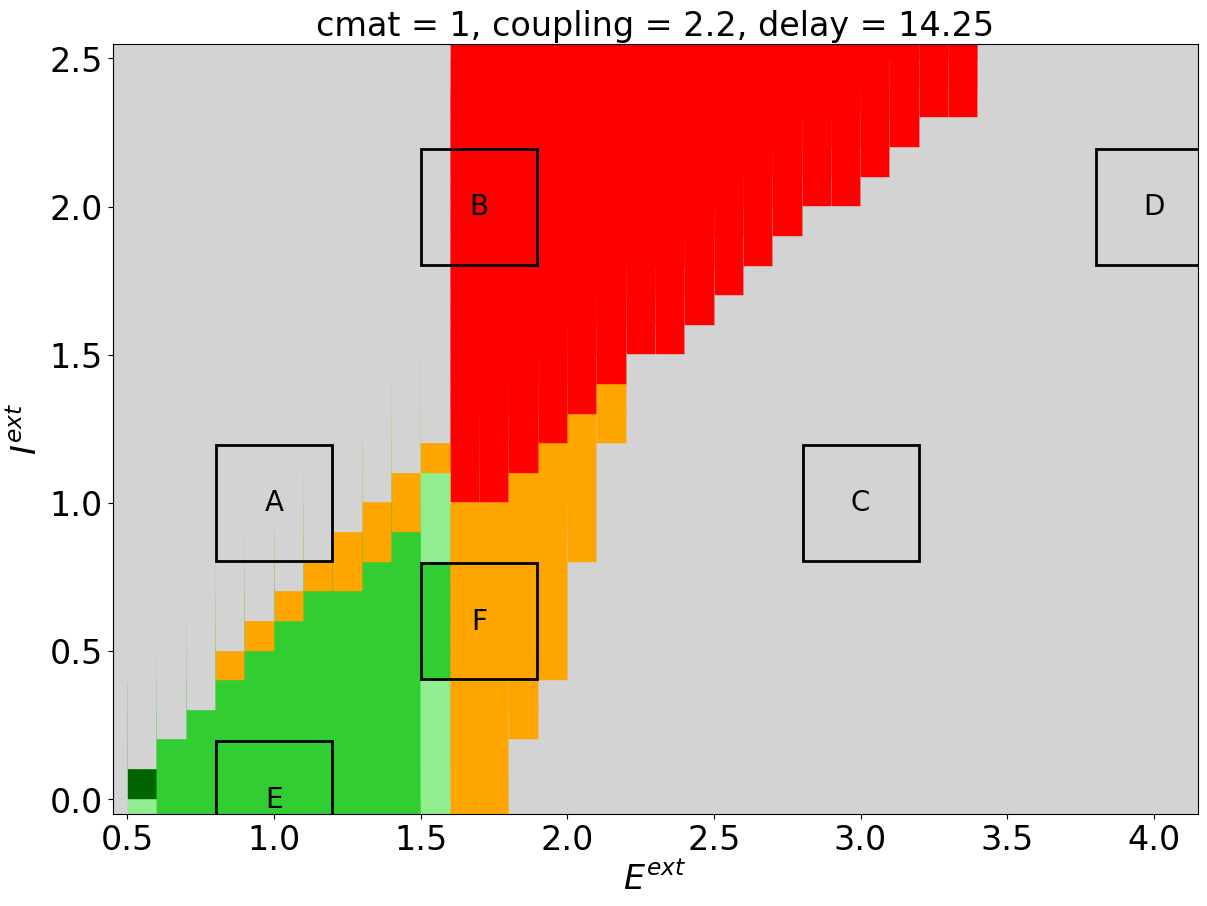

1 6 4


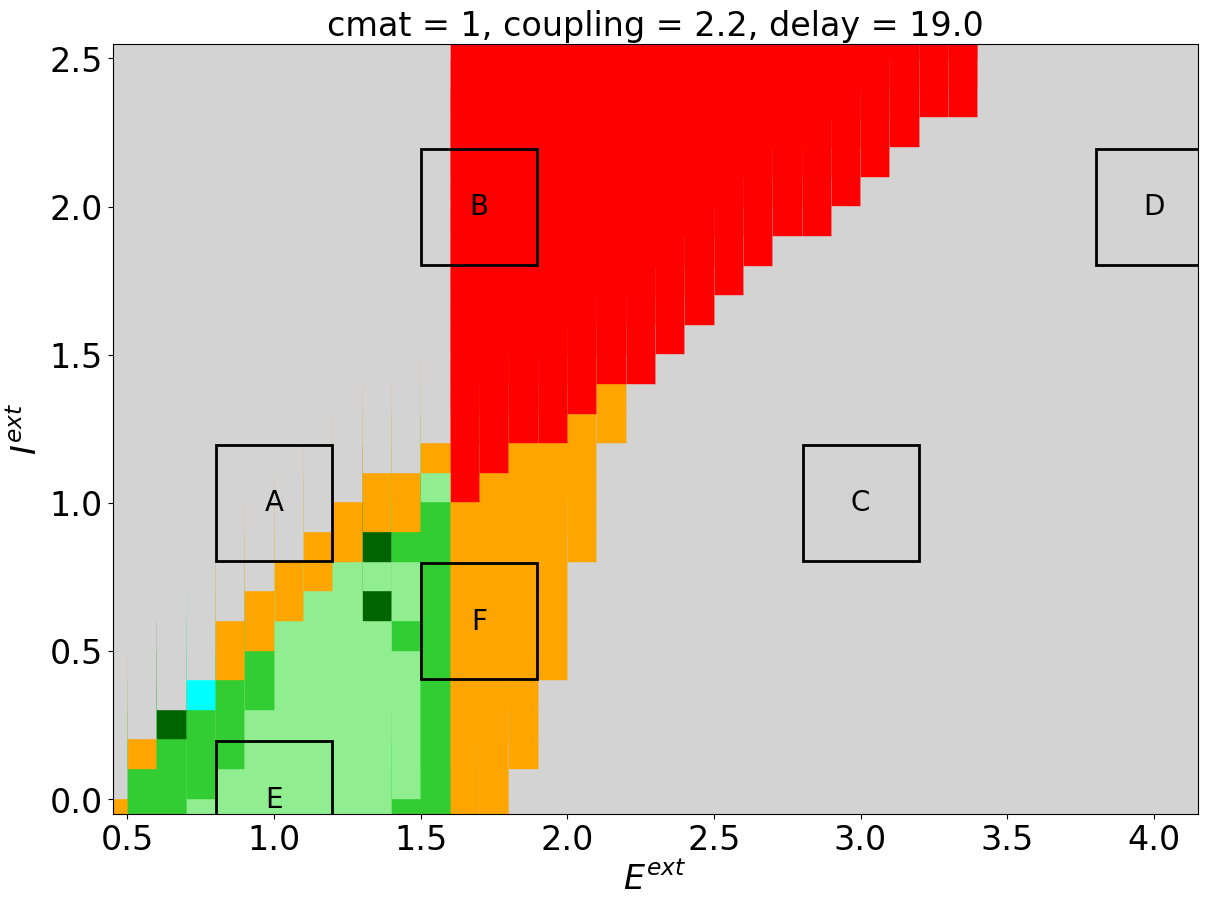

In [214]:
for i in range(len(cmats)):

    for ci in range(len(coupling_array)):

        for di in range(len(delay_array)):

            if ci == 0 and di != 0:
                continue

            if i != 1: continue

            print(i, ci, di)

            statespace[i][ci][di]["coords"] = []
            statespace[i][ci][di]["state"] = []

            for e_ in eext:
                
                for i_ in iext:

                    dmat = delay_array[di] * cmats[i] * 20.
                
                    model = WCModel(Cmat=cmats[i], Dmat=dmat)
                    model.params.K_gl = coupling_array[ci]
                    dt = 0.1
                    model.params.dt = dt

                    dur = 40.
                    i00, i01 = int(0.5 * dur * 1000/dt - 1000/dt), int(0.5 * dur * 1000/dt) - 1
                    i10, i11 = int(-1000/dt), -1

                    model.params['duration'] = dur * 1000 # Simulation time, ms
                    test_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
                    test_input[:,:int(50/dt)] = 5.
                    test_input[:,i01+1:i01+1+int(50/dt)] = -5.
                    model.params.exc_ext = e_ + test_input
                    model.params.inh_ext = i_

                    model.run()

                    state0 = getstate(model.exc[0,i00:i01], (model.exc[1,i00:i01]))
                    state1 = getstate(model.exc[0,i10:i11], (model.exc[1,i10:i11]))

                    if False and np.abs(e_ - 1.4) < 1e-2 and np.abs(i_ - 0.6) < 1e-2:
                        plt.plot(model.exc[0,i00:i01])
                        plt.plot(model.exc[1,i00:i01])
                        plt.show()

                        plt.plot(model.exc[0,i10:i11])
                        plt.plot(model.exc[1,i10:i11])
                        plt.show()

                        print(state0)
                        print(state1)
                        print(len(statespace[i][ci][0]["coords"]))

                    state = None

                    if state0[0] == "static" and state1[0] == "static":
                        if np.abs(state0[1][0] - state1[1][0]) < 1e-1 and np.abs(state0[1][1] - state1[1][1]) < 1e-1:
                            state = state0.copy()
                        else:
                            state = ["bistable", [state0[1], state1[1]] ]

                    else:

                        if state0[0] == "osc":
                            #print("sine input ", e_, i_)
                            test_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
                            test_input = np.vstack( ([test_input]*N))
                            stim_period = int(state0[1][0])
                            test_input[0,:2*int(stim_period/dt)] = 5. * np.sin(2.*np.pi*np.arange(0,2*stim_period,dt)/stim_period)
                            test_input[1,:2*int(stim_period/dt)] = 5. * np.sin(2.*np.pi*np.arange(0,2*stim_period,dt)/stim_period)
                            test_input[0,i01+1:i01+1+2*int(stim_period/dt)] = 5. * np.sin(2.*np.pi*np.arange(0,2*stim_period,dt)/stim_period)
                            test_input[1,i01+1:i01+1+2*int(stim_period/dt)] = -5. * np.sin(2.*np.pi*np.arange(0,2*stim_period,dt)/stim_period)

                            model.params.exc_ext = e_ + test_input
                            model.params.inh_ext = i_
                            model.run()

                            state0 = getstate(model.exc[0,i00:i01], (model.exc[1,i00:i01]))
                            state1 = getstate(model.exc[0,i10:i11], (model.exc[1,i10:i11]))

                        if False:
                            fig, ax = plt.subplots(1,2, figsize=(18,5))

                            ax[0].plot(model.exc[0,i00:i01], color="blue")
                            ax[0].plot(model.exc[1,i00:i01], color="orange")

                            ax[1].plot(model.exc[0,i10:i11], color="blue")
                            ax[1].plot(model.exc[1,i10:i11], color="orange")
                            plt.show()

                            print(state0)
                            print(state1)

                        if state0[0] == "osc" and state1[0] == "osc":
                            if np.abs(state0[1][0] - state1[1][0]) <= LIMOSCBI:
                                if np.abs(state0[1][1][0] - state1[1][1][0]) <= LIMOSCPHASE and state0[1][1][1] <= LIMOSCPHASE:
                                    state = state0.copy()
                                elif state0[1][1][1] > LIMOSCPHASE:
                                    state = ["beating", state0[1]]
                                elif np.abs(state0[1][1][0] - state1[1][1][0]) > LIMOSCPHASE:
                                    state = ["sync/ async bistable osc", state0[1]]
                            if np.abs(state0[1][0] - state1[1][0]) > LIMOSCBI:
                                state = ["bistable osc", [state0[1], state1[1]] ]
                            
                            #print(state)

                        elif state0[0] == "beating" and state1[0] == "beating":
                            if np.abs(state0[1][0] - state1[1][0]) <= 3. and np.abs(state0[1][1] - state1[1][1]) <= 3.:
                                state = state0.copy()

                        elif state0[0] == "osc/ static" and state1[0] == "osc/ static":
                            if np.abs(state0[1][0] - state1[1][0]) <= 1e-1 and np.abs(state0[1][1] - state1[1][1]) <= 1e-1:
                                state = state0.copy()
                            else:
                                print("osc/ static with different values")
                                print(state0)
                                print(state1)
                            
                        elif state0[0] == "static/ osc" and state1[0] == "static/ osc":
                            if np.abs(state0[1][0] - state1[1][0]) <= 1e-1 and np.abs(state0[1][1] - state1[1][1]) <= 1e-1:
                                state = state0.copy()
                            else:
                                print("static/ osc with different values")
                                print(state0)
                                print(state1)

                        elif state0[0] == "osc" and state1[0] == "beating":
                            state = state1.copy()
                        elif state0[0] == "beating" and state1[0] == "osc":
                            state = state0.copy()

                        elif state0[0] == "static" and state1[0] == "osc":
                            state = ["bi static/ osc", [state0[1], state1[1]]]
                        elif state0[0] == "osc" and state1[0] == "static":
                            state = ["bi static/ osc", [state1[1], state0[1]]]

                        else:
                            print("Problem")
                            print(state0)
                            print(state1)

                    if state is None:
                        print("Problem NONE")
                        print(state0)
                        print(state1)

                        fig, ax = plt.subplots(1,2)

                        ax[0].plot(model.exc[0,i01-1000:i01])
                        ax[0].plot(model.exc[1,i01-1000:i01])

                        ax[1].plot(model.exc[0,i11-1000:i11])
                        ax[1].plot(model.exc[1,i11-1000:i11])
                        plt.show()
                        continue

                    statespace[i][ci][di]["coords"].append([e_, i_])
                    statespace[i][ci][di]["state"].append(state)

            title = "cmat = " + str(i) + ", coupling = " + str(coupling_array[ci]) + ", delay = " + str(delay_array[di])
            filename = "statespace_" + str(i) + "_" + str(ci) + "_" + str(di) + ".png"
            plot_statespace(statespace[i][ci][di], coords_all, title, os.path.join(dir, filename))

In [ ]:
with open('osc_2n_statespace.pickle', 'wb') as f:
    pickle.dump(statespace, f)

In [22]:
with open('osc_2n_statespace.pickle', 'rb') as f:
    res_read = pickle.load(f)

statespace = res_read.copy()

In [215]:
roundind = 2
cols = ["lightgrey", "limegreen", "darkgreen", "lightgreen", "red", "orange", "cyan", ]

ms = dx*2.1* 1e2

def plot_statespace(statespacedict, coords, title=None, filename=None, legend=False):
    fig, ax = plt.subplots(figsize=(14,10))

    for i in range(len(statespacedict["coords"])):
        if statespacedict["state"][i][0] == "static":
            col=cols[0]
        elif statespacedict["state"][i][0] == "osc":
            col=cols[1]
        elif statespacedict["state"][i][0] == "bistable":
            col=cols[4]
        elif statespacedict["state"][i][0] == "beating":
            col=cols[2]
        elif statespacedict["state"][i][0] == "static/ osc":
            col=cols[5]
        elif statespacedict["state"][i][0] == "osc/ static":
            col=cols[5]
        elif statespacedict["state"][i][0] == "bistable osc":
            col=cols[3]
        elif statespacedict["state"][i][0] == "bi static/ osc":
            col=cols[5]
        elif statespacedict["state"][i][0] == "sync/ async bistable osc":
            col=cols[6]

        else:
            print(statespacedict["state"][i][0])
            col = "black"

        ax.plot(statespacedict["coords"][i][0], statespacedict["coords"][i][1], marker="s", markersize=ms, color=col)

    for c in coords:
        ax.plot(c[0], c[1], marker="s", markeredgewidth=2, markeredgecolor="black", markersize=ms, markerfacecolor=mpl.colors.to_rgba('b', 0.0))
        ax.text(c[0], c[1], c[2], fontdict=dict(ha="center", va="center", color="black", size=20))

    ax.set_xlim(emin-0.5*dx, emax+0.5*dx)
    ax.set_ylim(imin-0.5*dx, imax+0.5*dx)
    ax.set_xlabel(r"$E^{ext}$")
    ax.set_ylabel(r"$I^{ext}$")

    if title is not None:
        ax.set_title(title)

    if legend:
        custom_leg = [  mpl.lines.Line2D([0], [0], marker='s', color=cols[0], linewidth=0, label='Static up/ down',
                            markersize=20),
                        mpl.lines.Line2D([0], [0], marker='s', color=cols[1], linewidth=0, label='Oscillation',
                            markersize=20),
                        mpl.lines.Line2D([0], [0], marker='s', color=cols[2], linewidth=0, label='Bistable up/ down',
                            markersize=20),
                        mpl.lines.Line2D([0], [0], linewidth=0, marker='s', markeredgewidth=2, markeredgecolor="black", 
                            markerfacecolor=mpl.colors.to_rgba('b', 0.0), markersize=20, label='POI',
                          ),
                         ]
        ax.legend(handles=custom_leg, loc='lower right', labelspacing = 0.3)


    if filename is not None:
        plt.savefig(filename)

    plt.show()

def getstate(exc0, exc1):
    PROM = 0.01
    state = [None, None]

    peaks0 = scipy.signal.find_peaks(exc0, prominence=PROM)[0]
    peaks1= scipy.signal.find_peaks(exc1, prominence=PROM)[0]

    if False and len(peaks0) > 4:
        fig, ax = plt.subplots(2,1, figsize=(15,10))
        ax[0].plot(exc0[:2000])
        ax[0].vlines(peaks0, 0, 0.5, color="grey")
        ax[1].plot(exc1[:2000])
        ax[1].vlines(peaks1, 0, 0.5, color="grey")
        ax[0].set_xlim(0, 2000)
        ax[1].set_xlim(0, 2000)
        plt.show()


    if len(peaks0) == 0 and len(peaks1) == 0:
        state[0] = "static"
        state[1] = [np.around(np.mean(exc0),roundind), np.around(np.mean(exc1),roundind) ]
    elif len(peaks0) > 3 and len(peaks1) > 3:
        period0 = getperiods(peaks0)
        period1 = getperiods(peaks1)
        phase = getphase(peaks0, peaks1)
        if np.abs(period0 - period1) < 1e-1: 
            state[0] = "osc"
            state[1] = [period0, phase]
        else:
            state[0] = "beating"
            state[1] = [period0, period1]
            #print("osc at different freq ", state[1])
    elif len(peaks0) > 3:
        state[0] = "osc/ static"
        period0 = getperiods(peaks0)
        state[1] = [period0, np.around(np.mean(exc1),roundind)]
    elif len(peaks1) > 3:
        state[0] = "static/ osc"
        period1 = getperiods(peaks1)
        state[1] = [np.around(np.mean(exc0),roundind), period1]
    else:
        print("WARNING ", peaks0, peaks1)

    return state 

def getperiods(peaks):
    pl = []
    for p in range(3, len(peaks)-3):
        pl.append( (peaks[p] - peaks[p-1]) * model.params.dt )
    return np.around(np.mean(pl),roundind)

def getphase(p0, p1):
    phdiff = []
    #print(p0[:12])
    #print(p1[:12])
    for refpeak in p0[2:-2]:
        for i in range(len(p1)):
            if p1[i] > refpeak:
                indit = i-1
                break
        
        phdiff.append( (refpeak - p1[indit]) * model.params.dt)
    #print(phdiff[::3])
    return np.around(np.mean(phdiff),roundind), np.around(np.var(phdiff), roundind)

def draw_nwgraph(cmat, filename):
    G = nx.DiGraph() 
    for n in range(cmat.shape[0]):
            for l in range(cmat.shape[1]):
                if cmat[n,l] != 0:
                    G.add_edge(l,n)
    nx.draw(G, with_labels=True, arrows=True, **options)
    plt.savefig(os.path.join(dir,filename), bbox_inches='tight')
    plt.show()

options = {
'node_color': 'lightgray',
'node_size': 1000,
'width': 2,
'arrowstyle': '-|>',
'arrowsize': 20,
'font_size' : 20,
'font_weight' : 'bold',
}

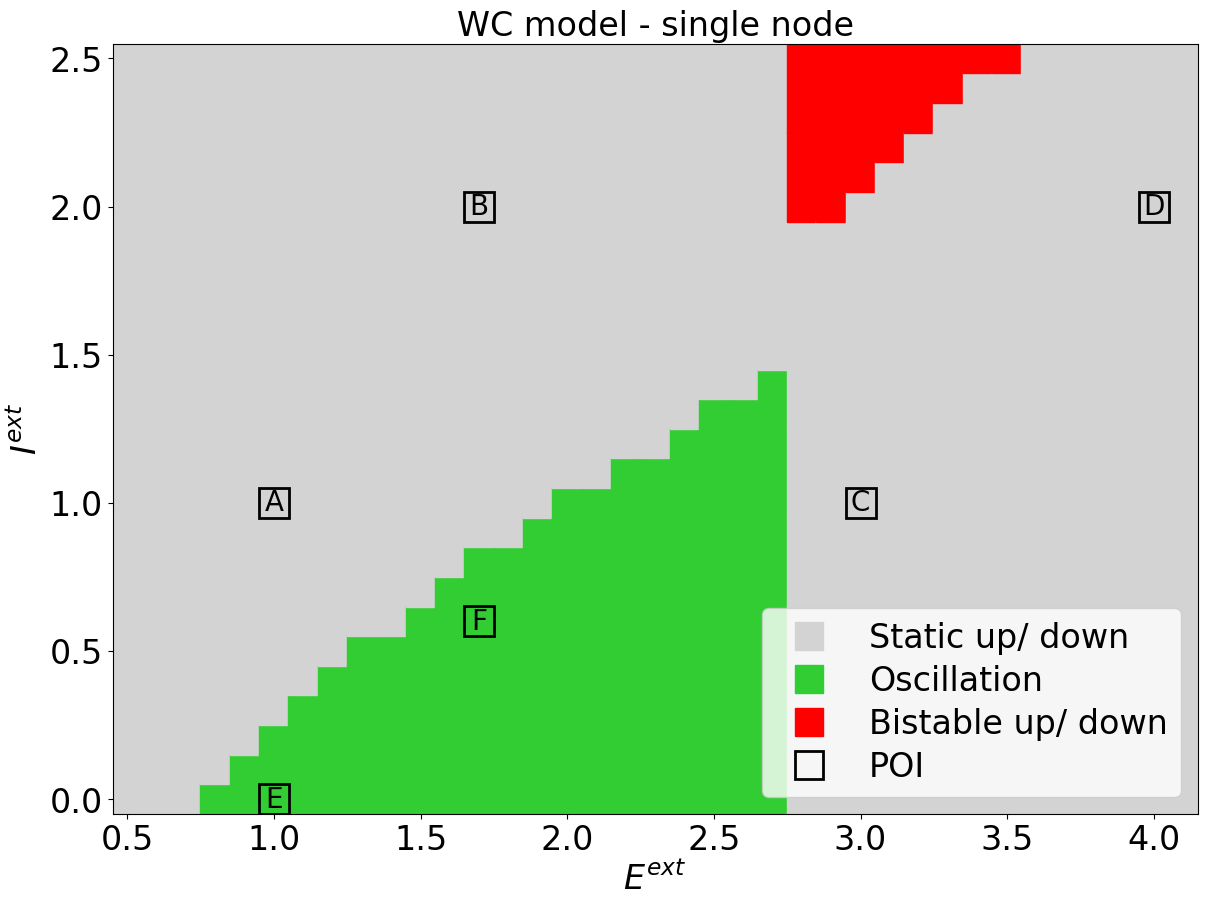

In [112]:
i, ci, di = 0, 0, 0

title = "WC model - single node"
filename = "WC_1n.png"
co = coords_all
plot_statespace(statespace[i][ci][di], co, title, os.path.join(dir, filename), legend=True)

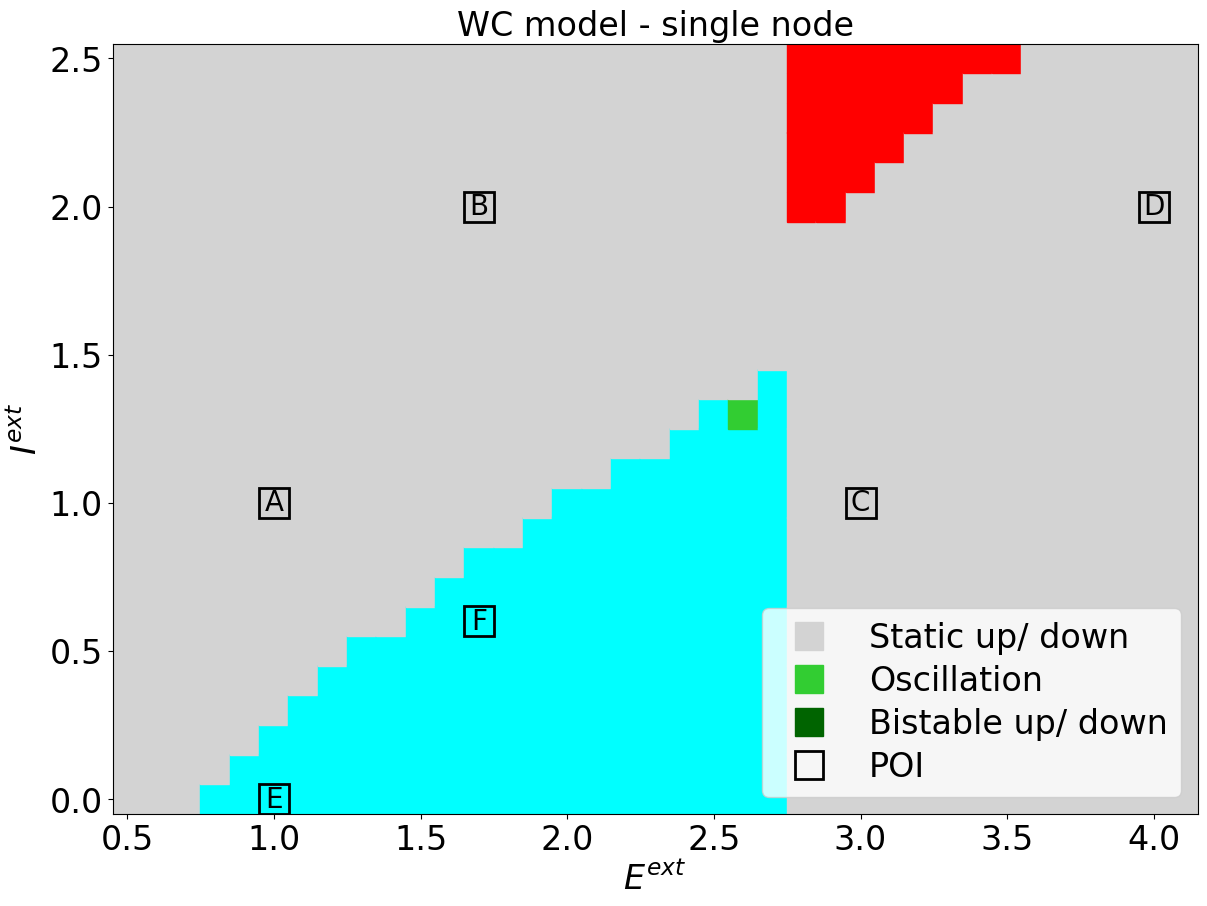

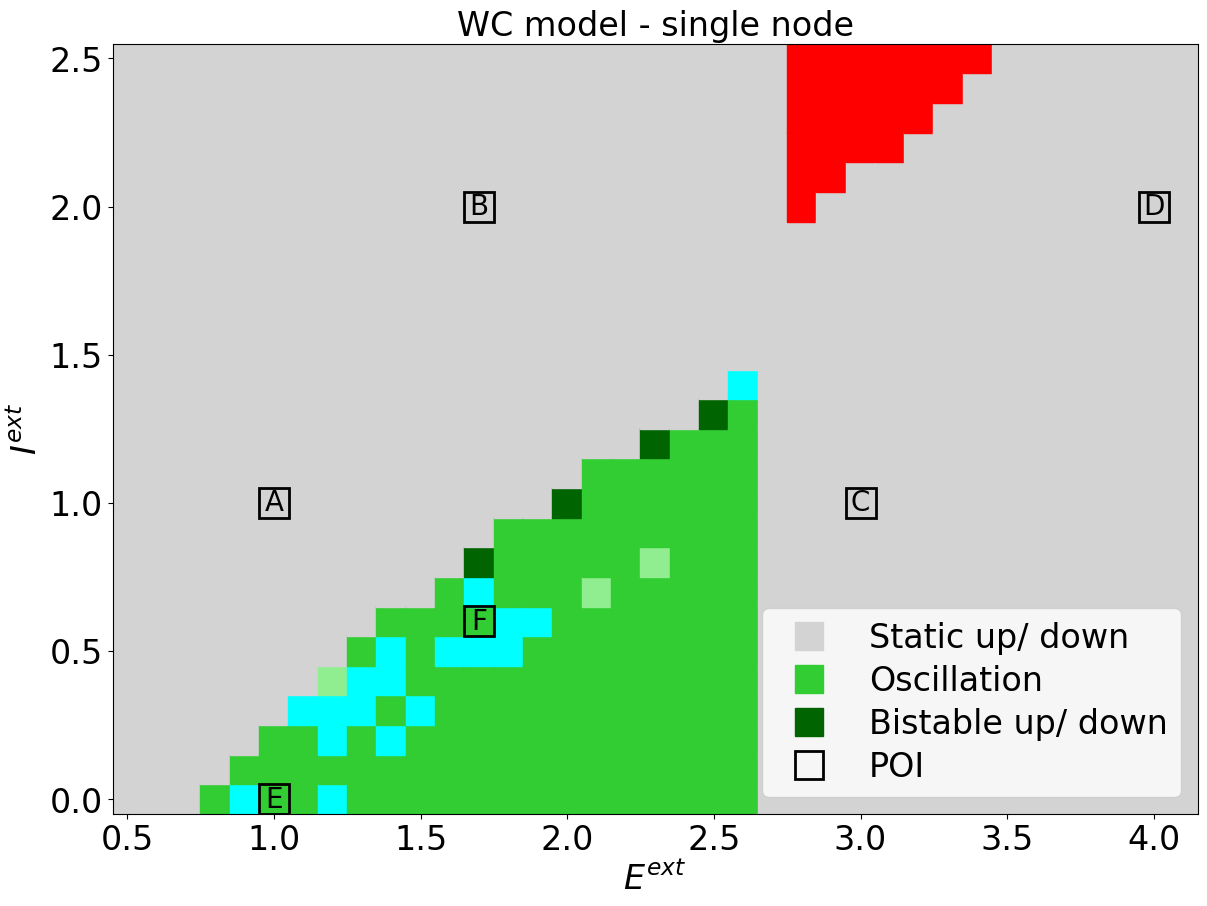

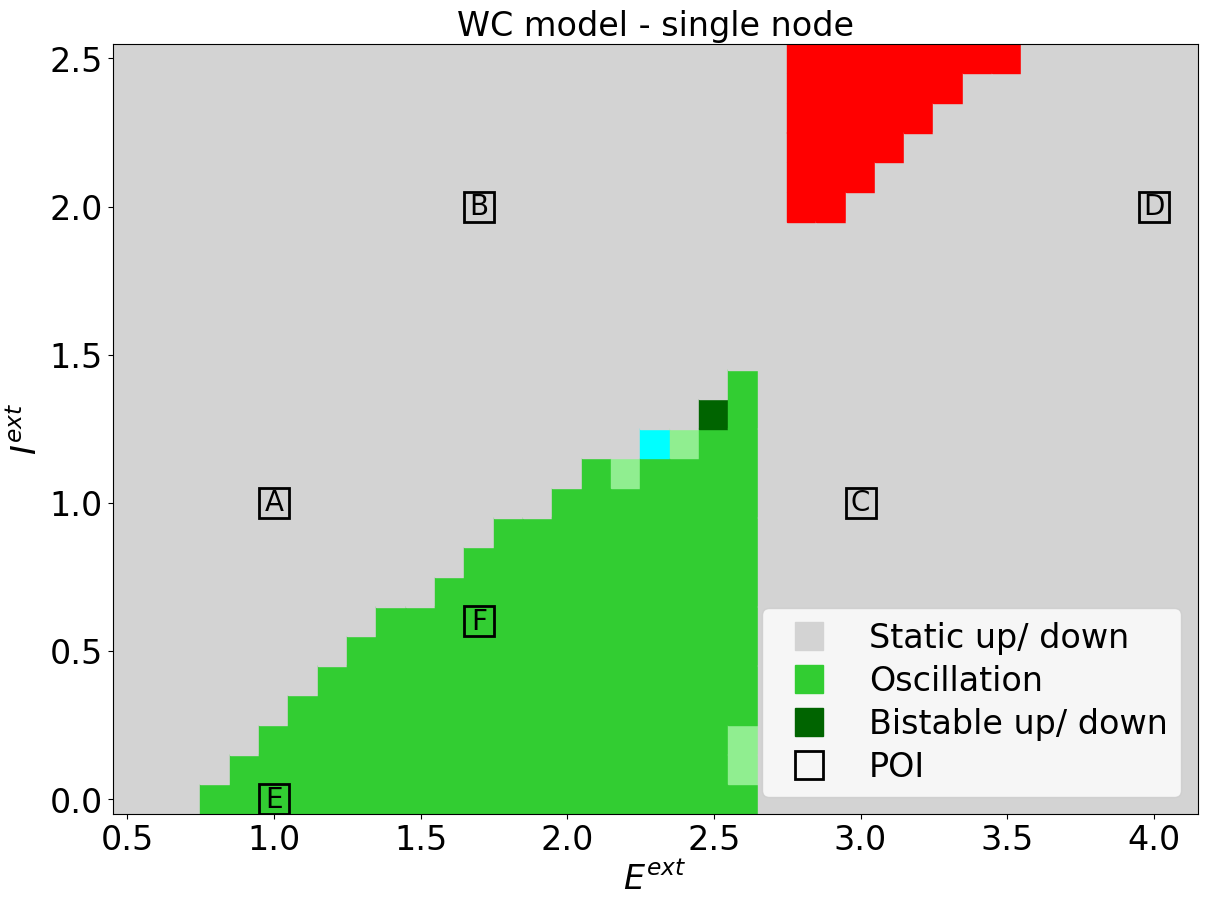

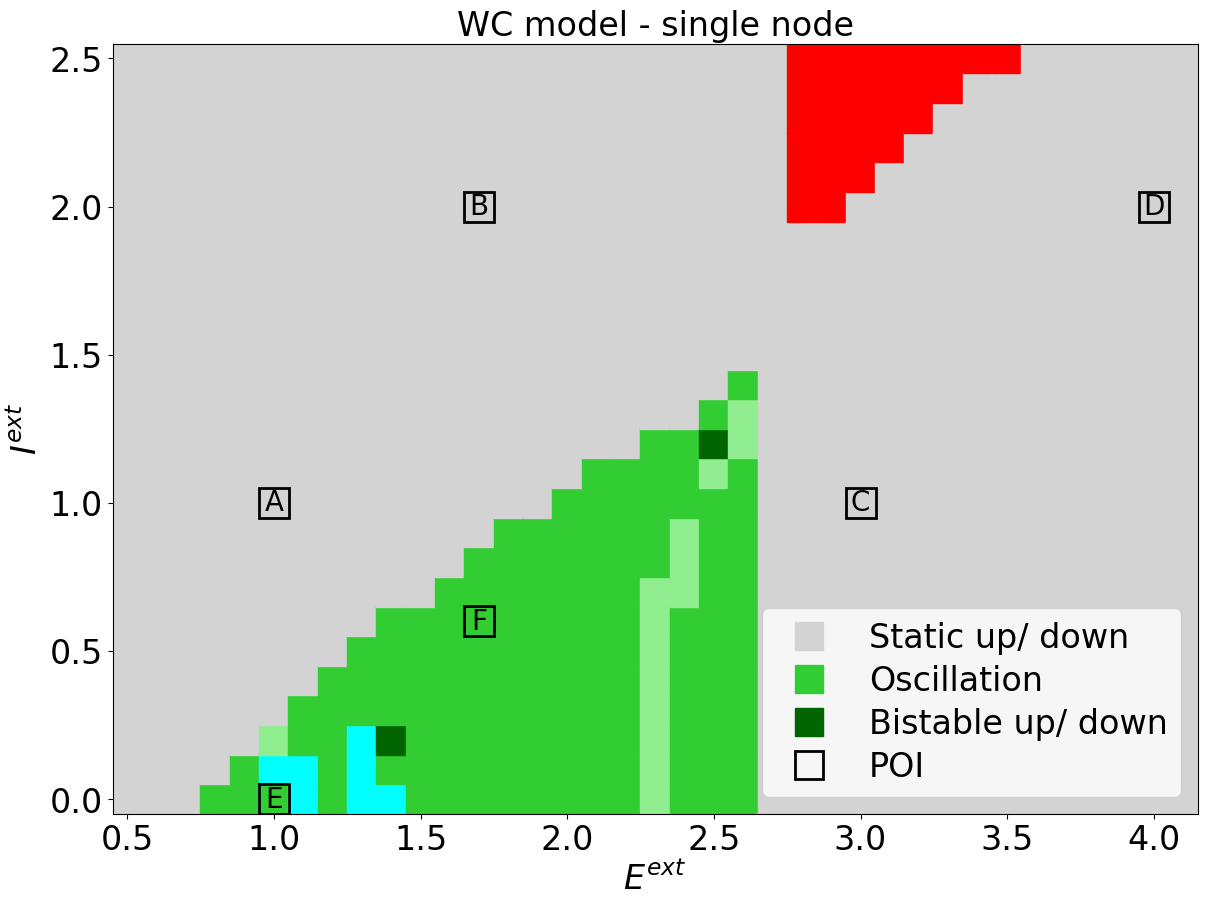

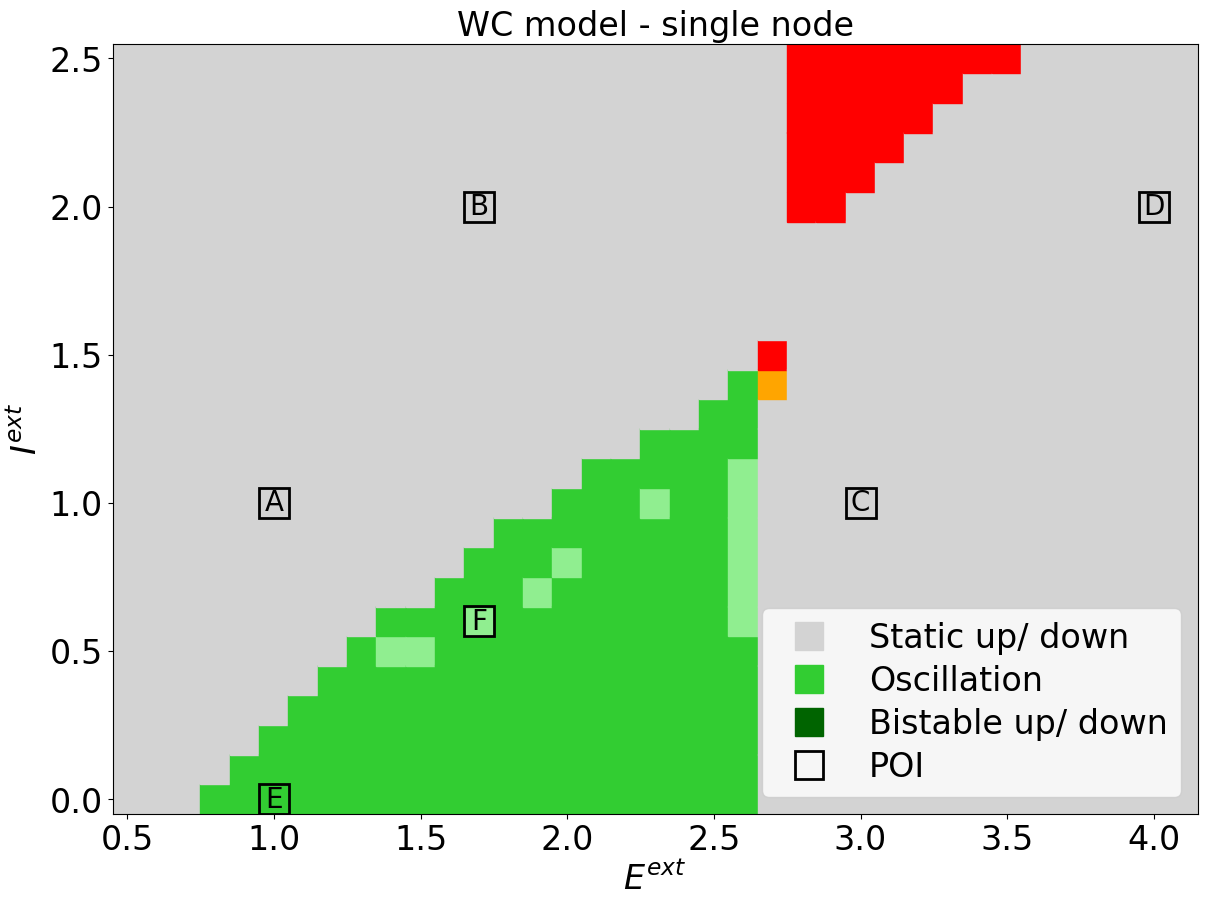

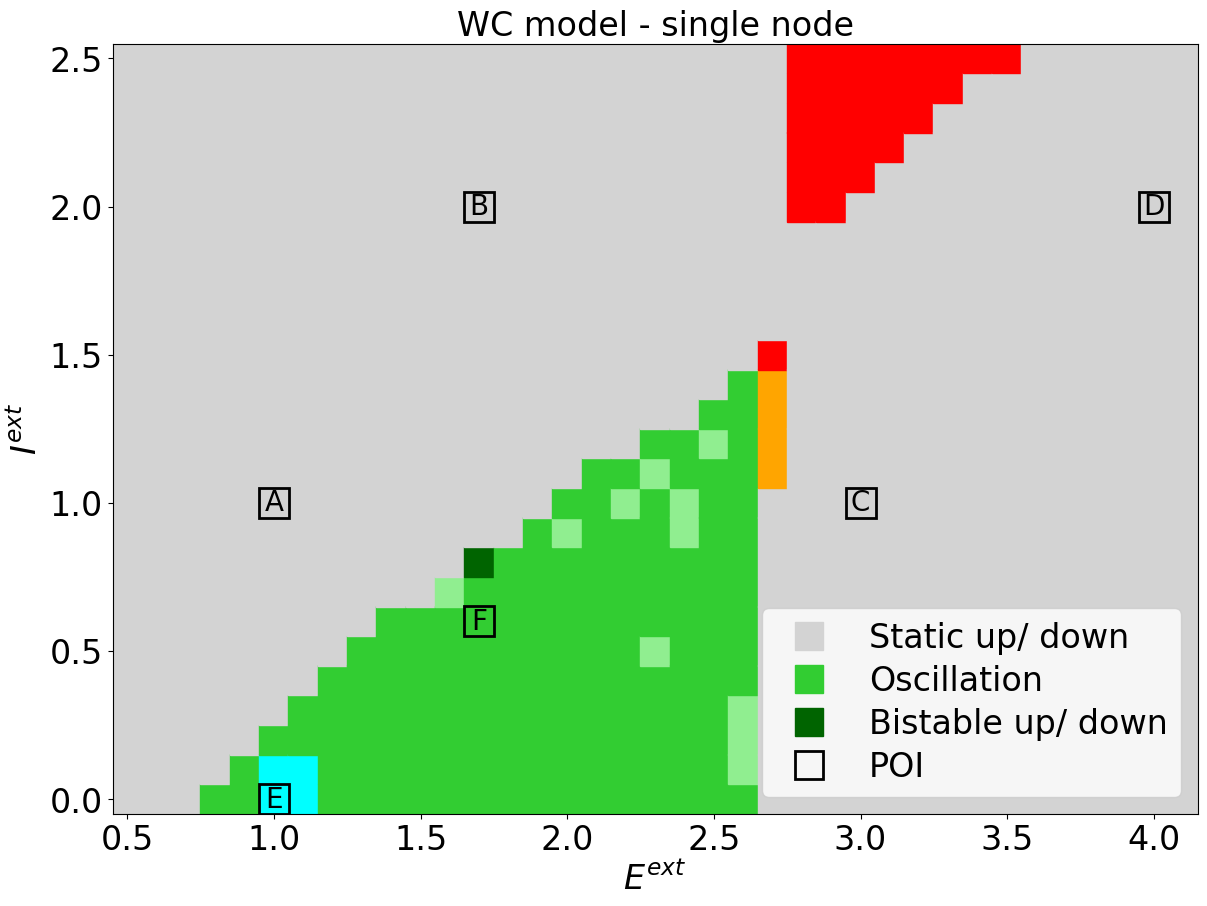

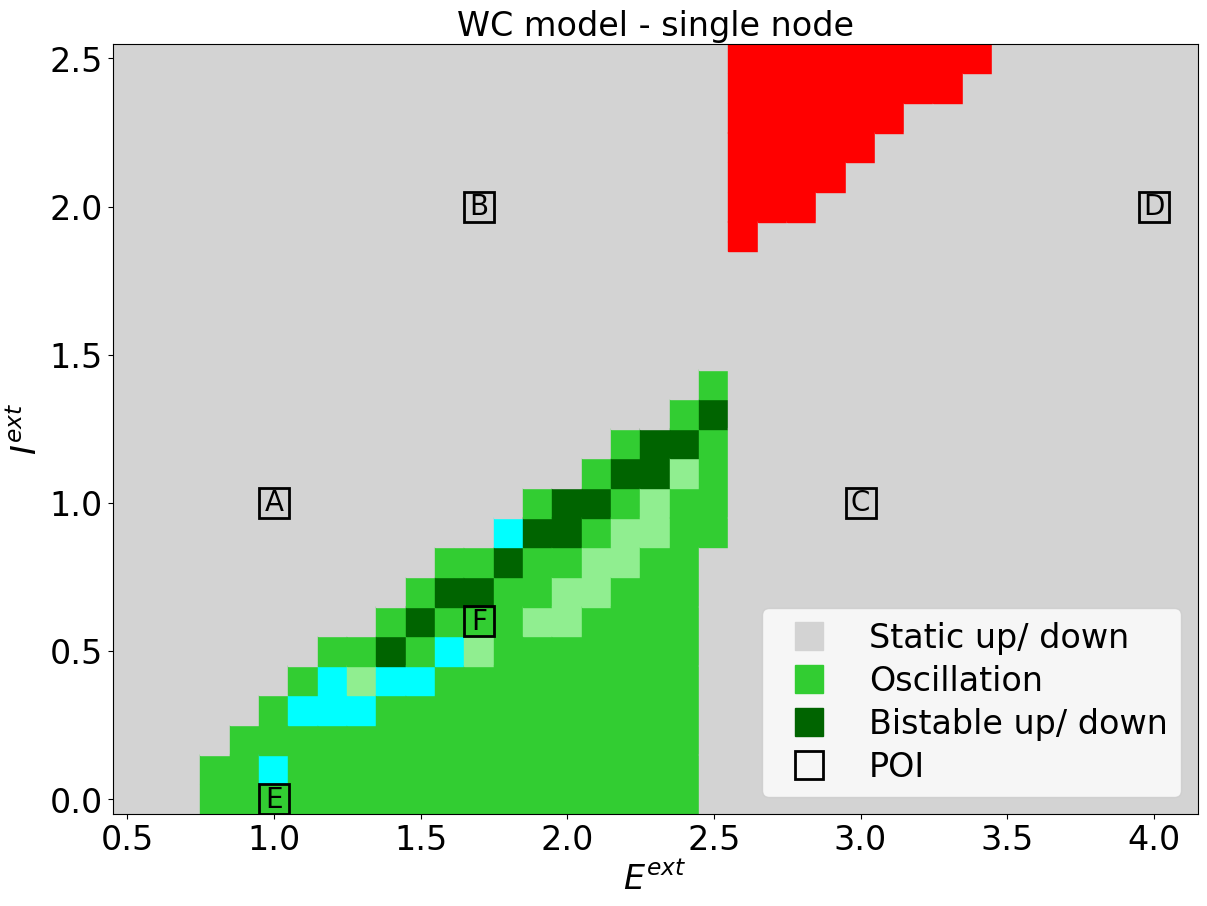

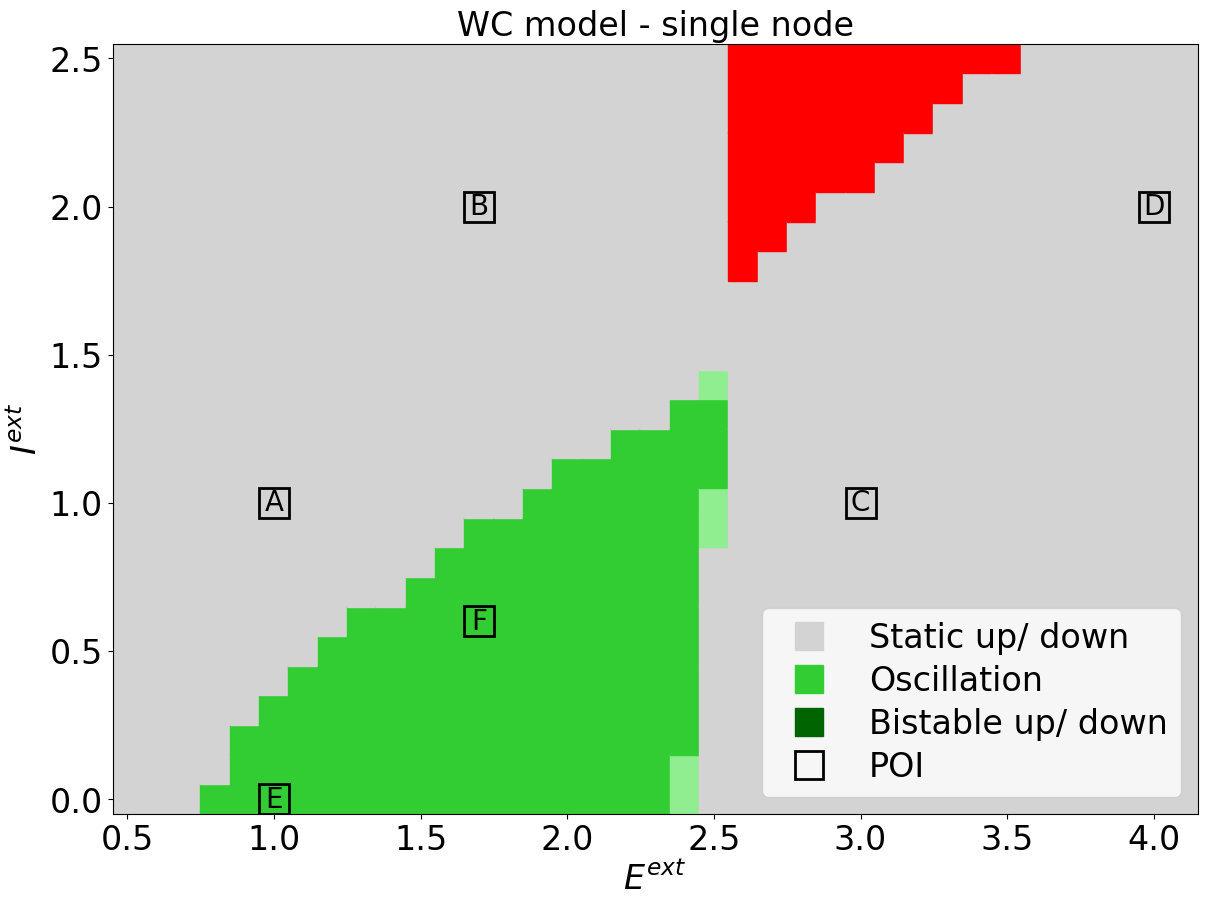

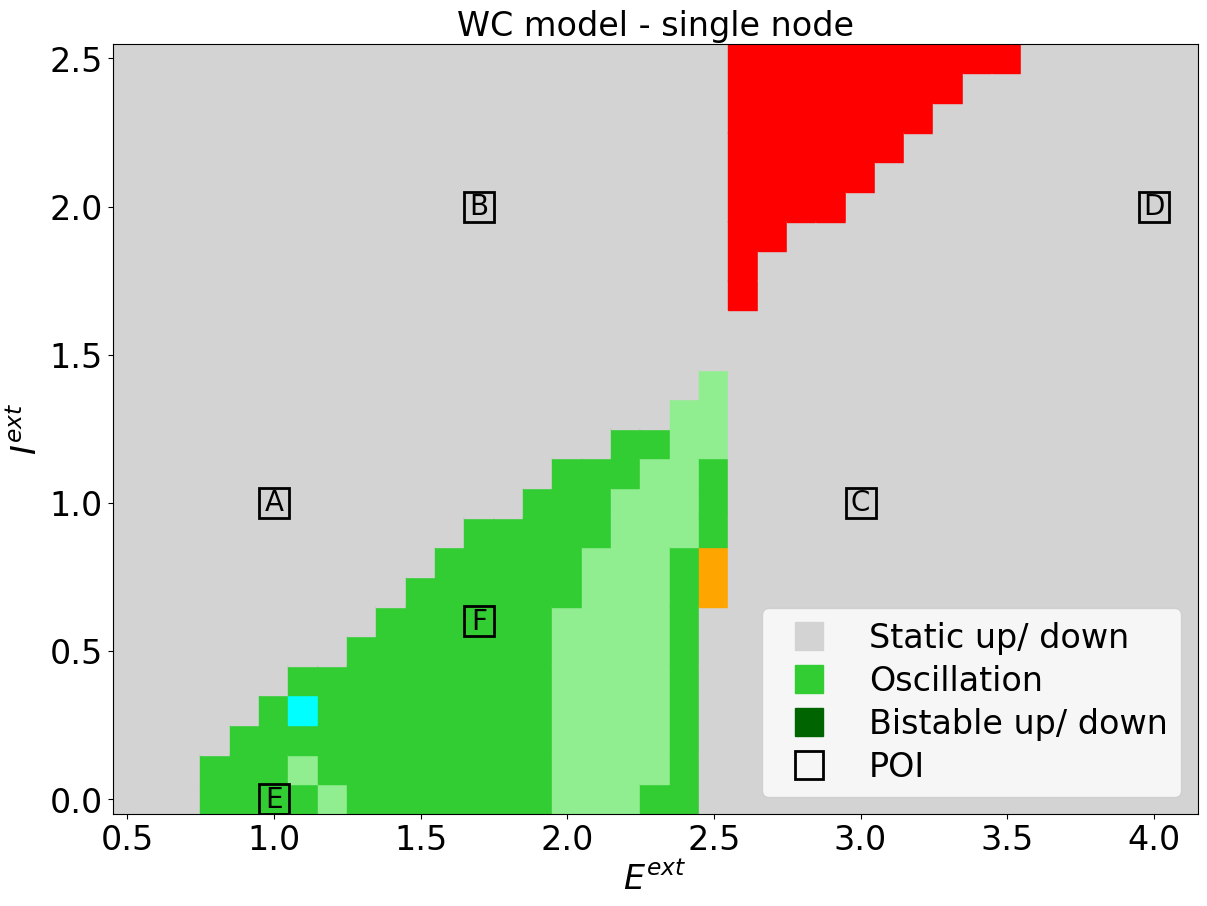

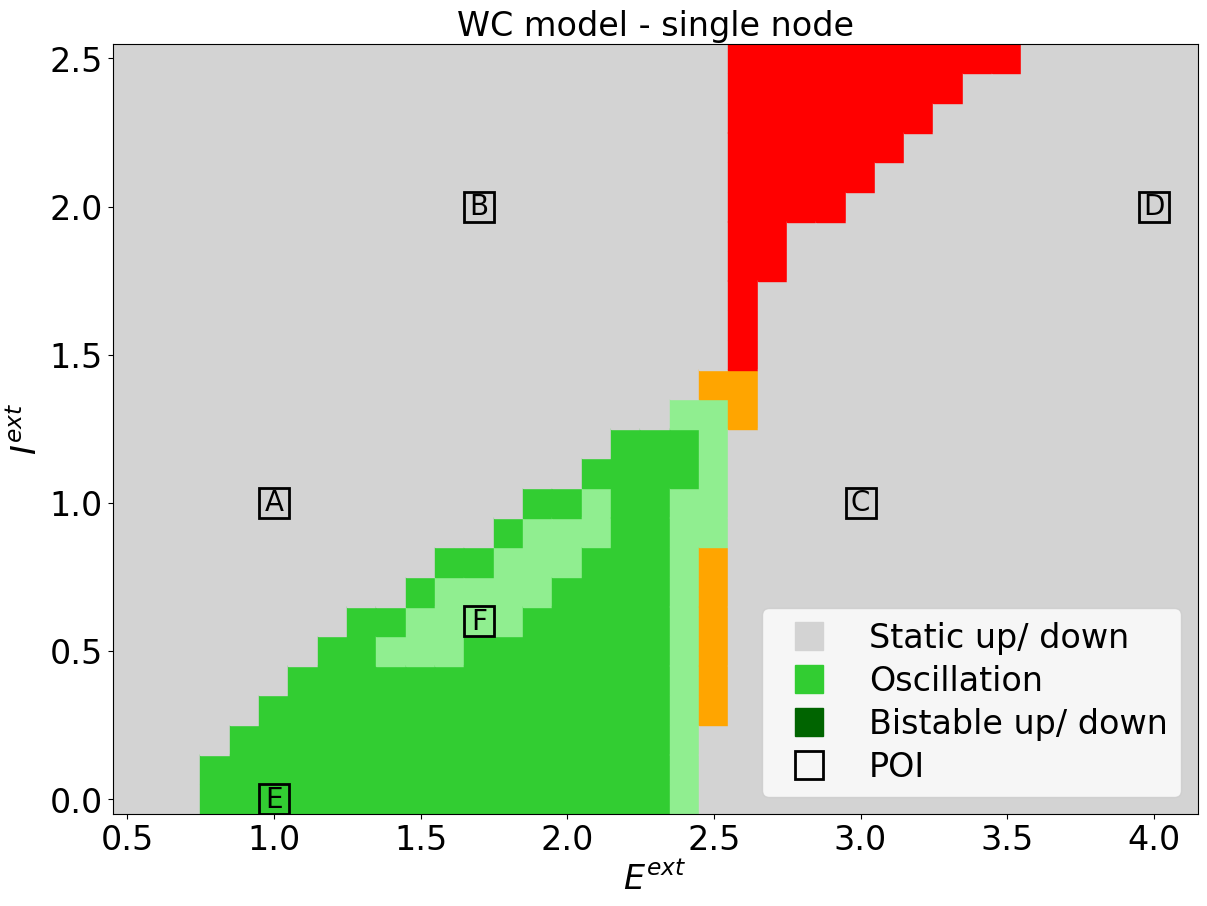

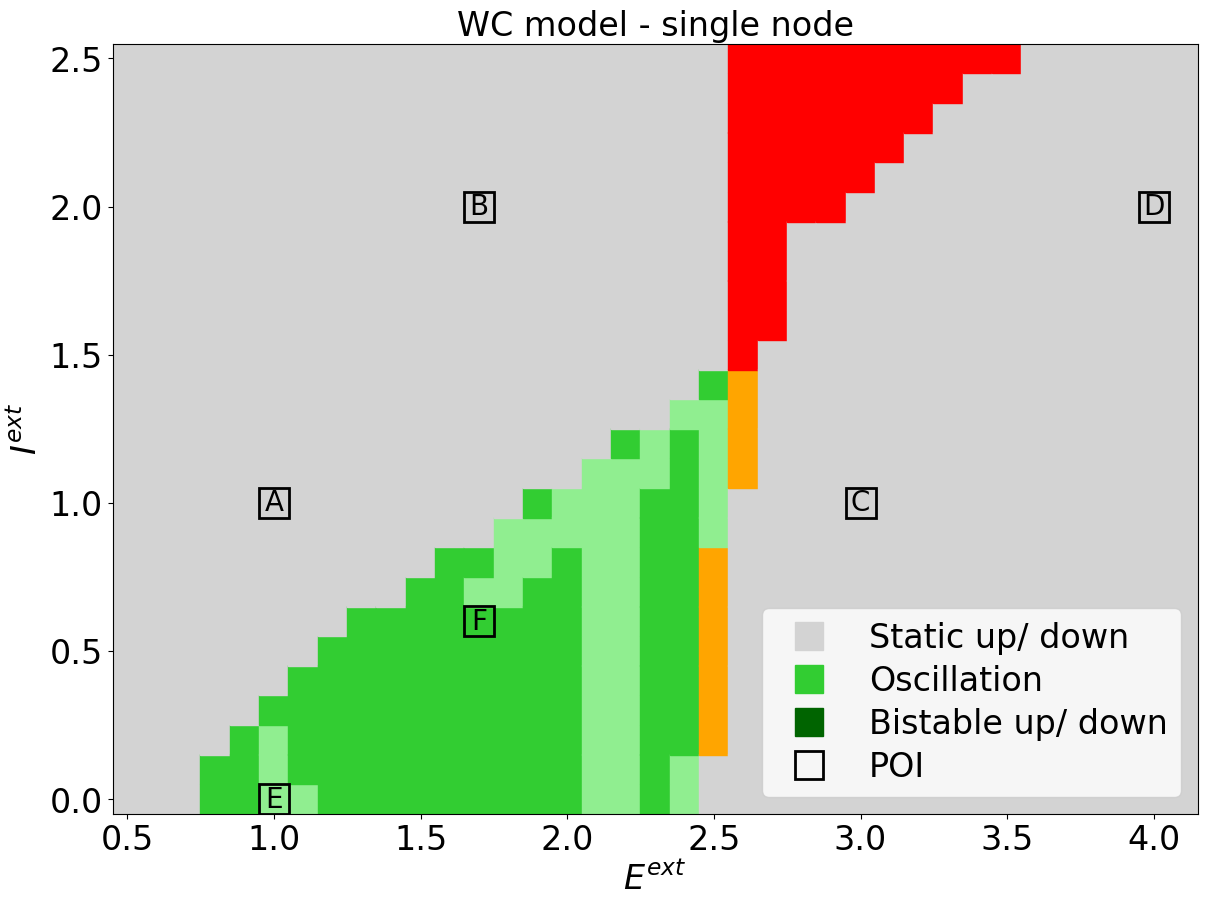

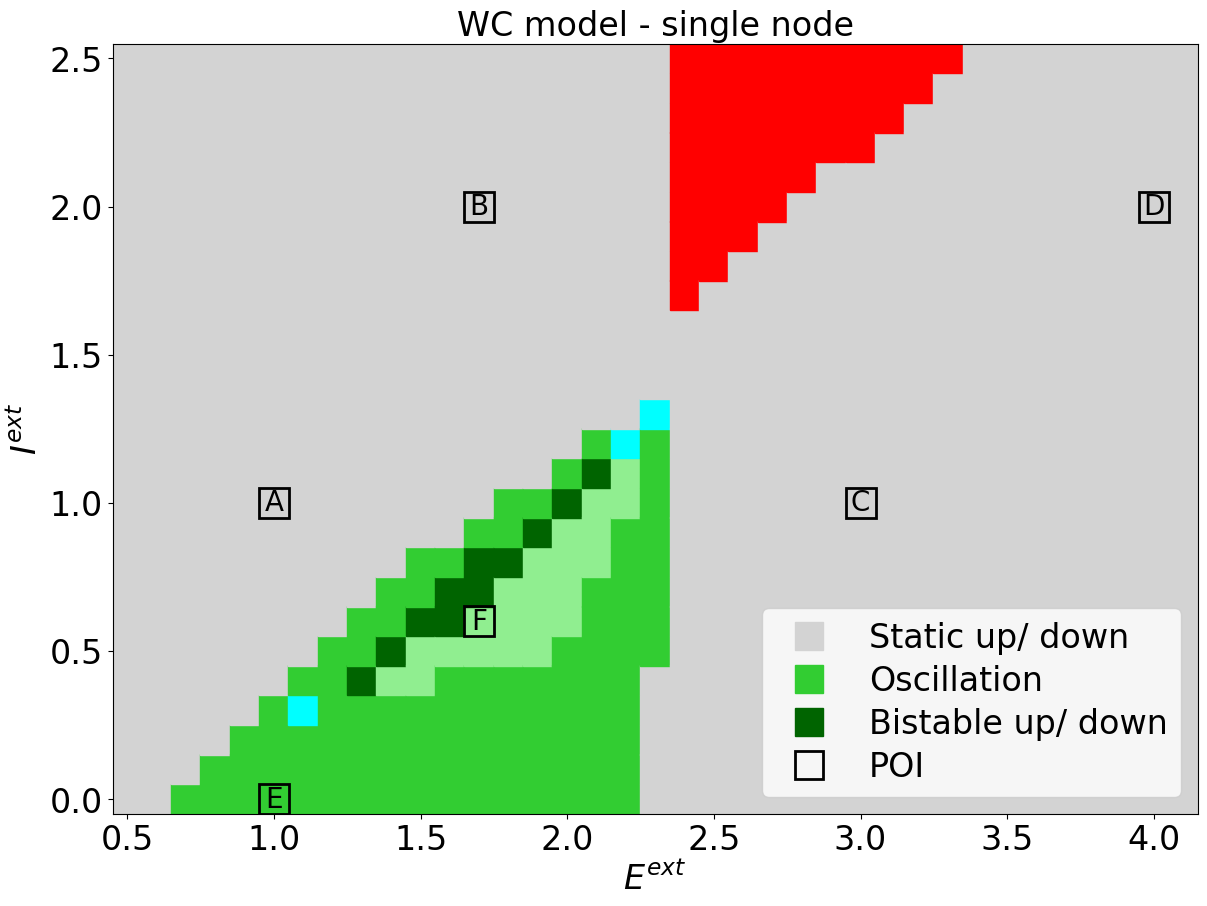

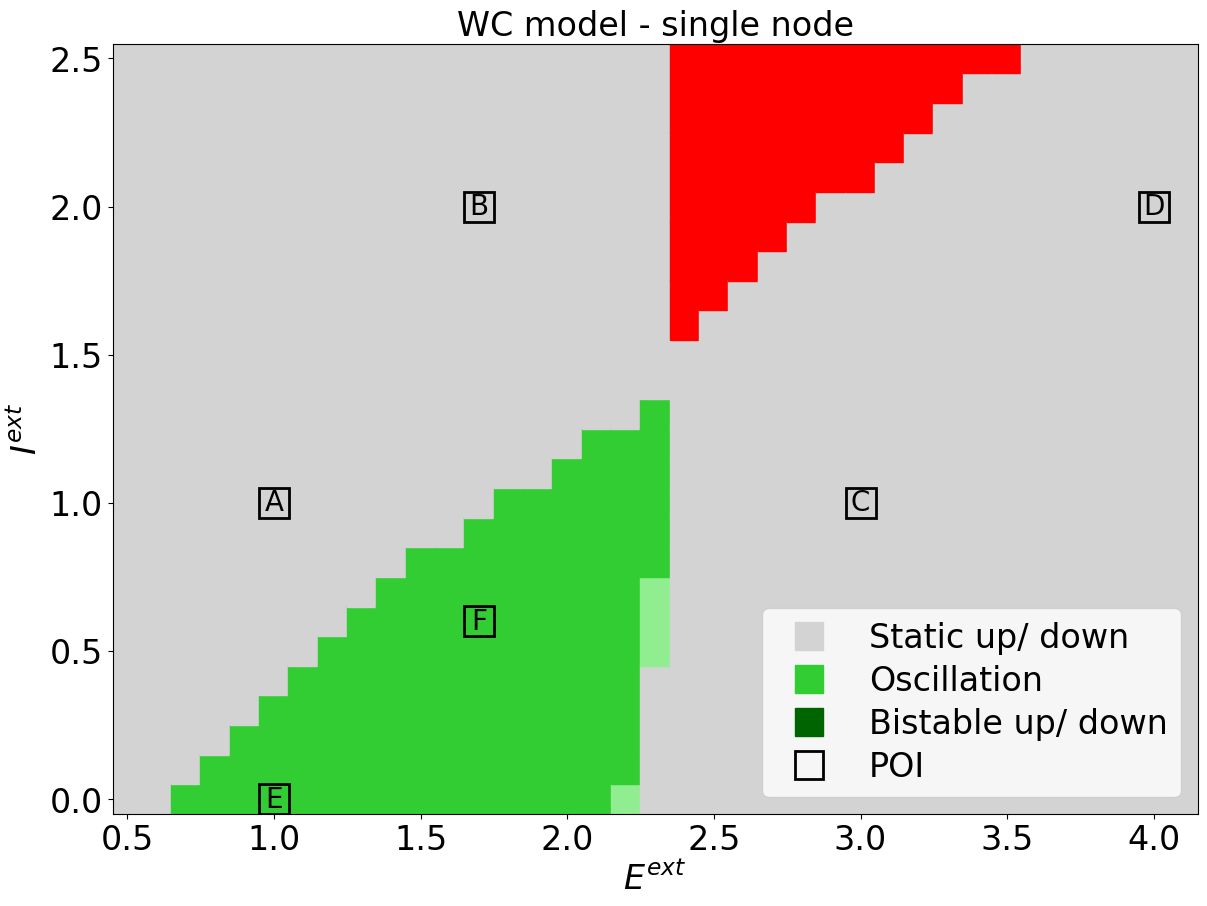

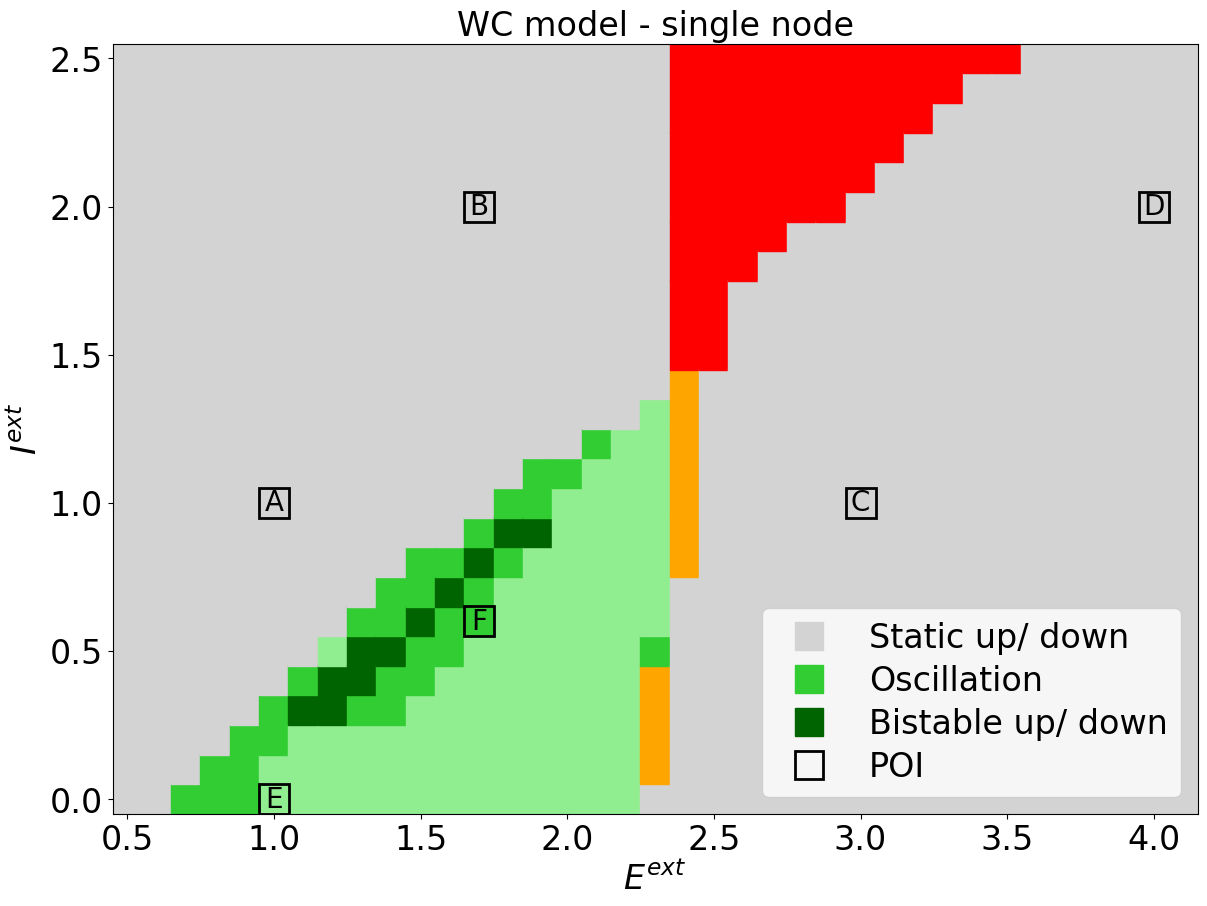

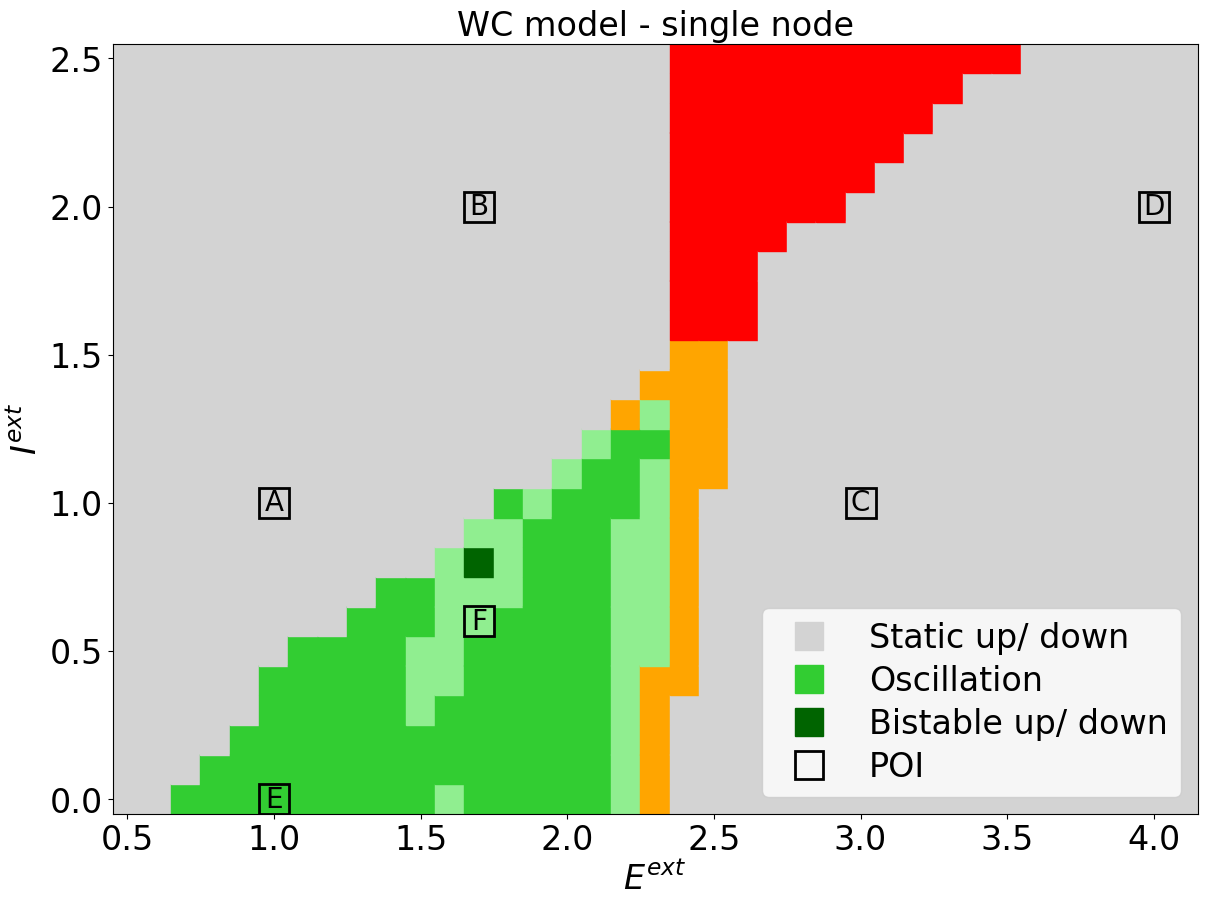

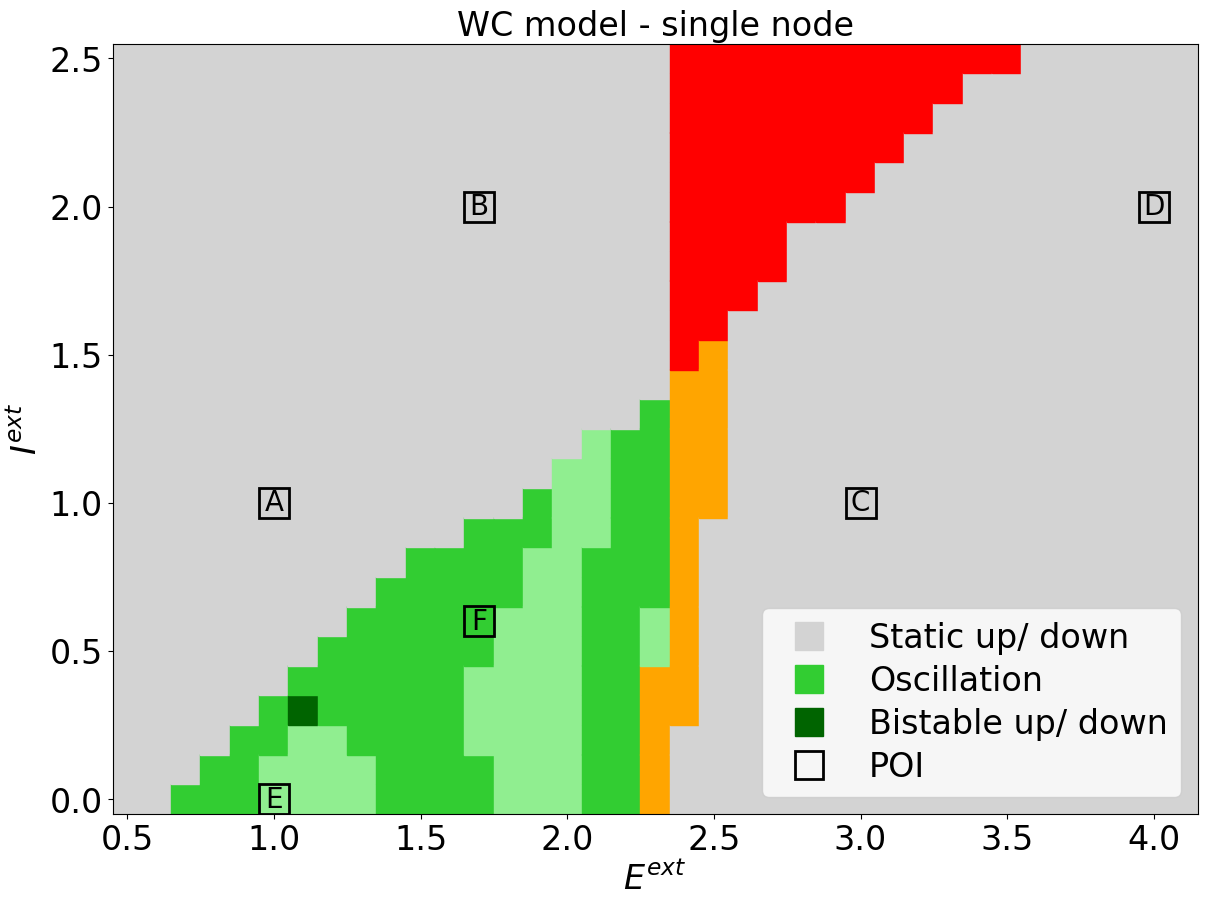

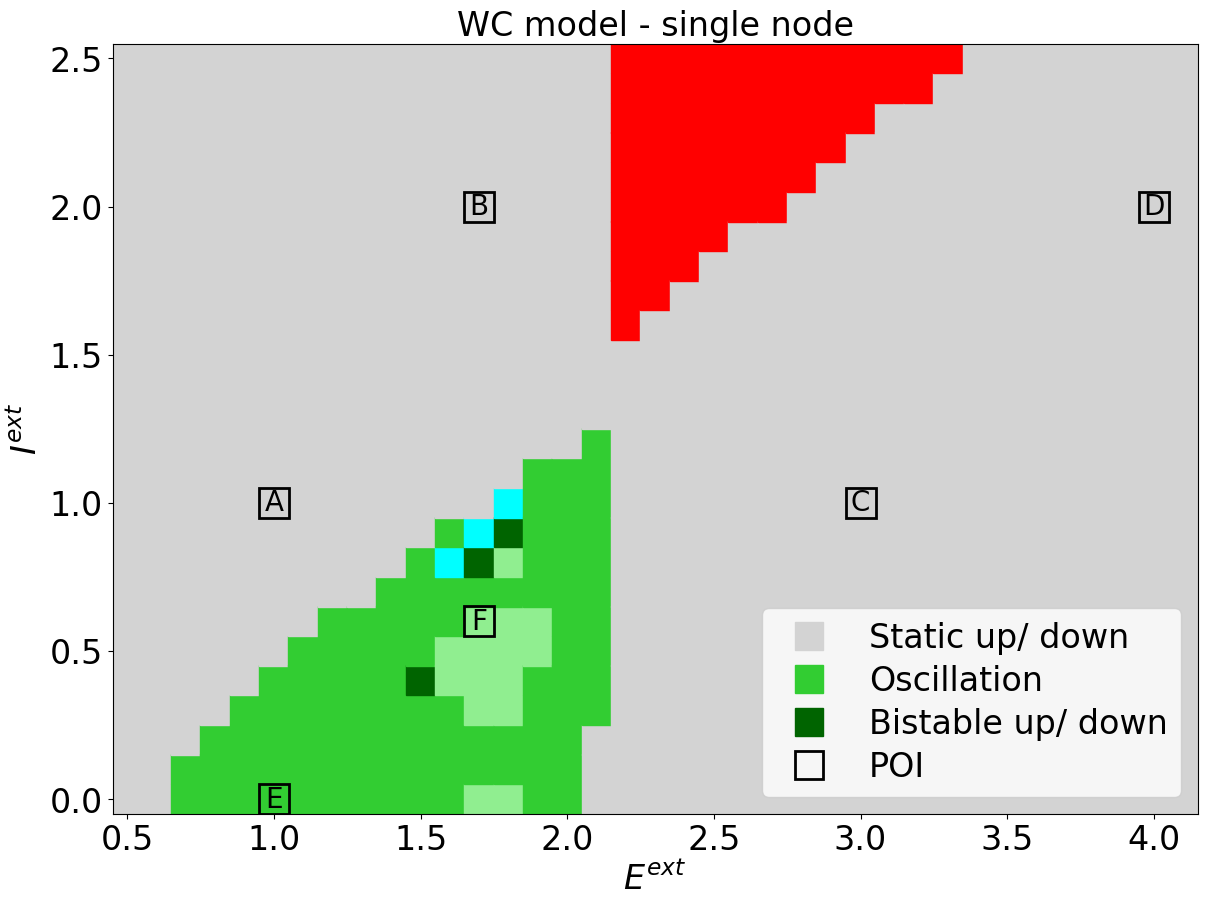

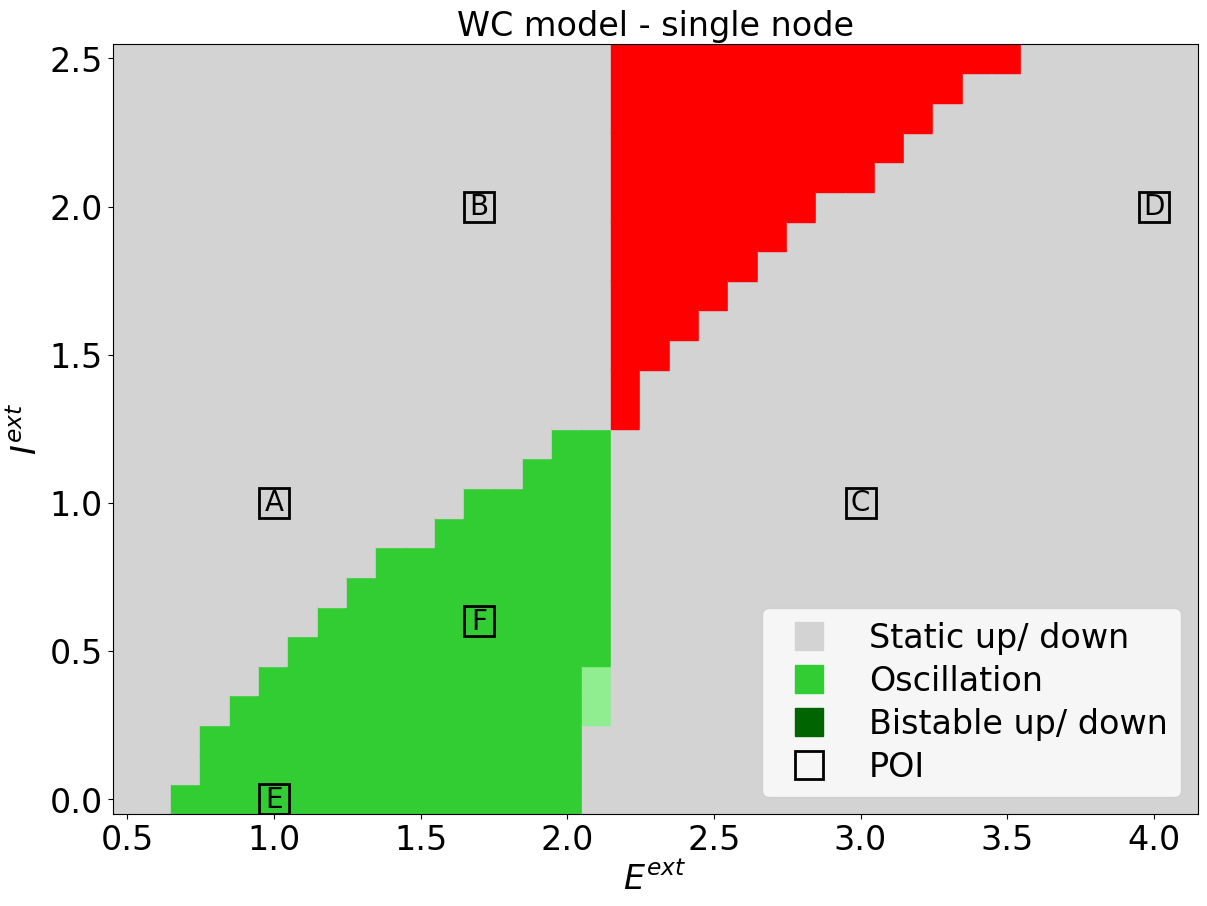

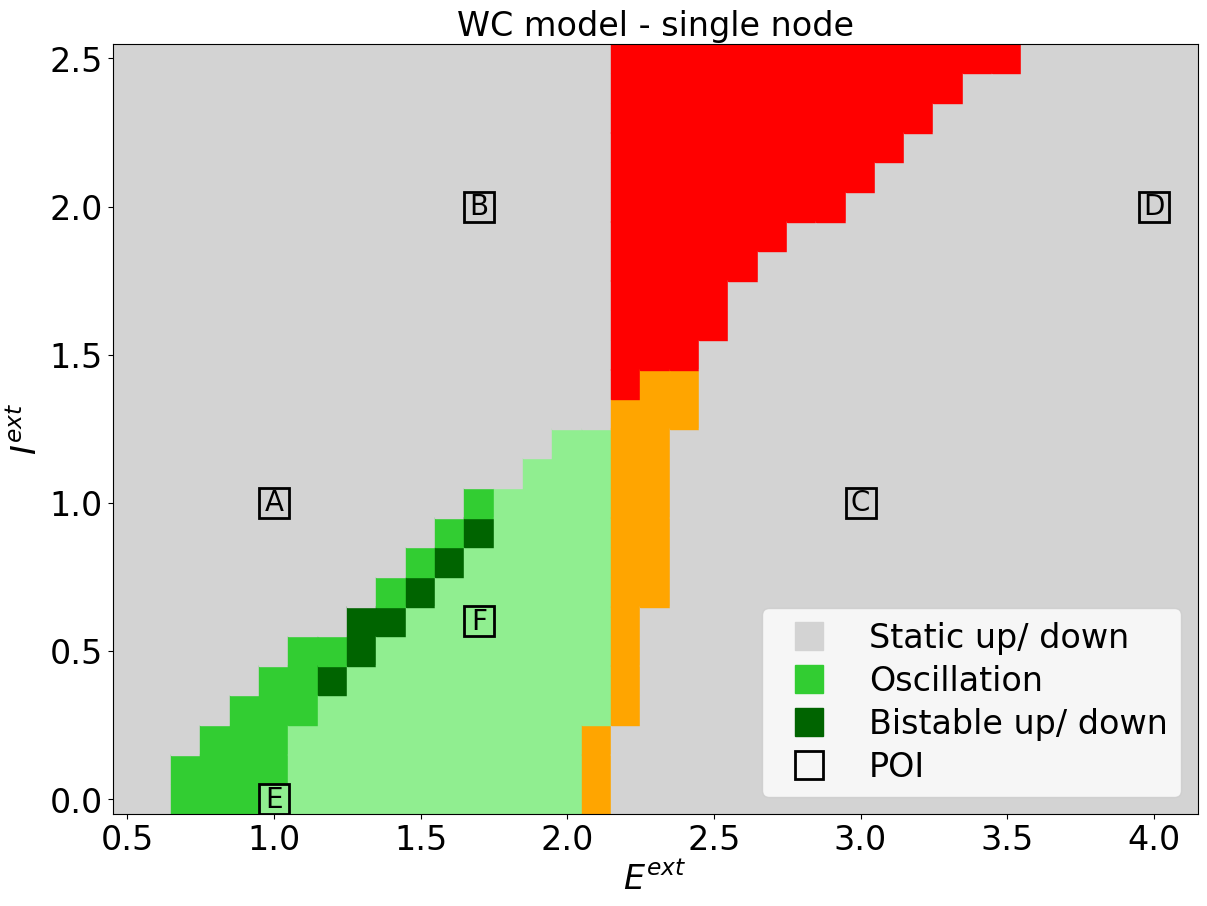

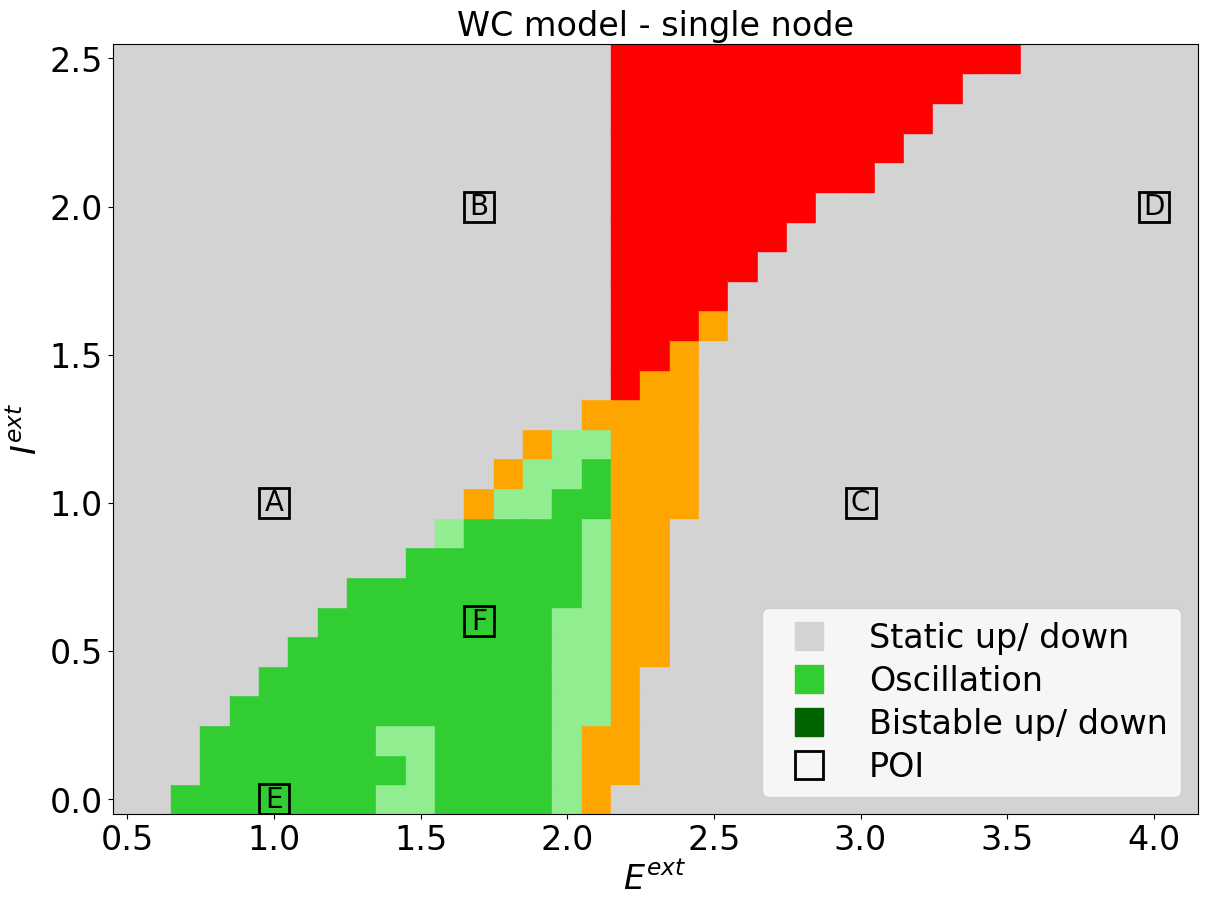

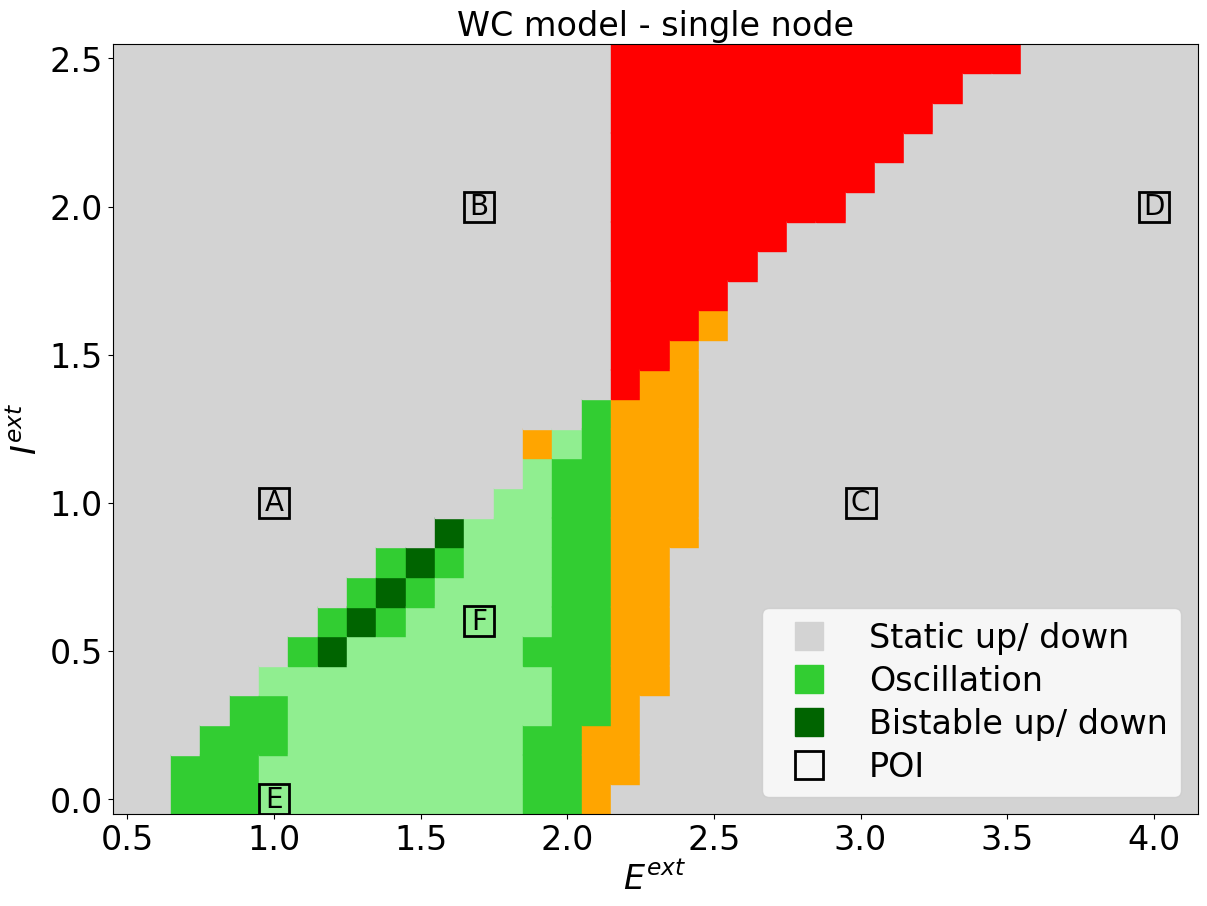

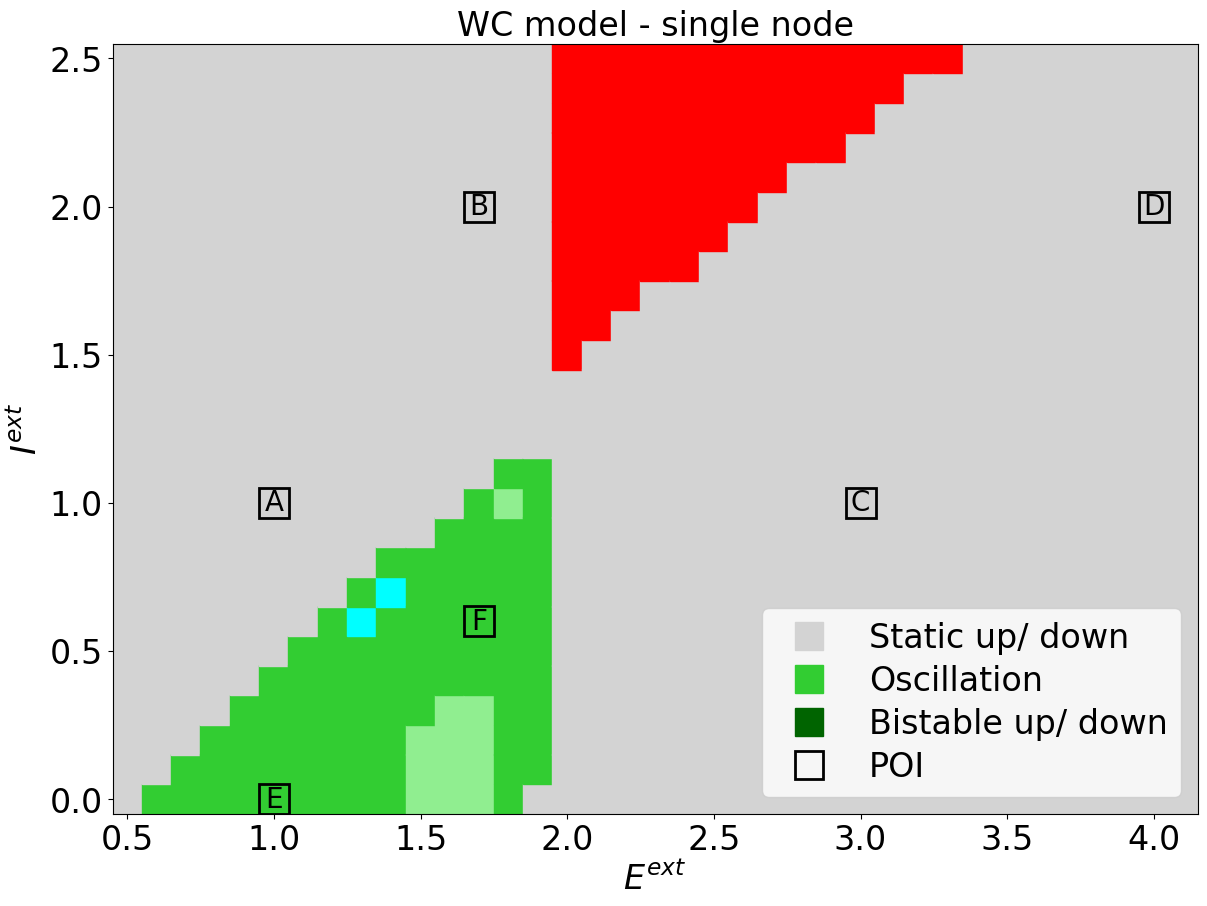

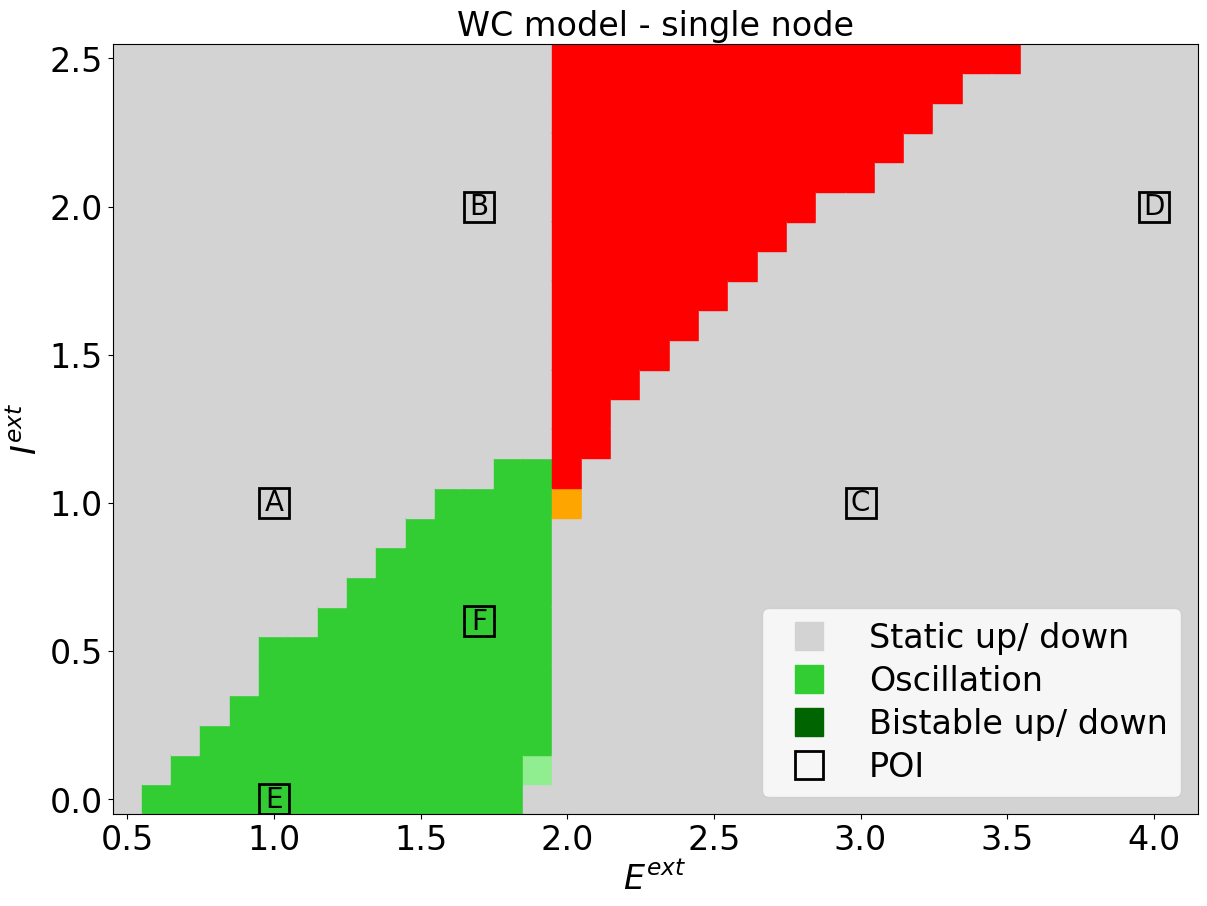

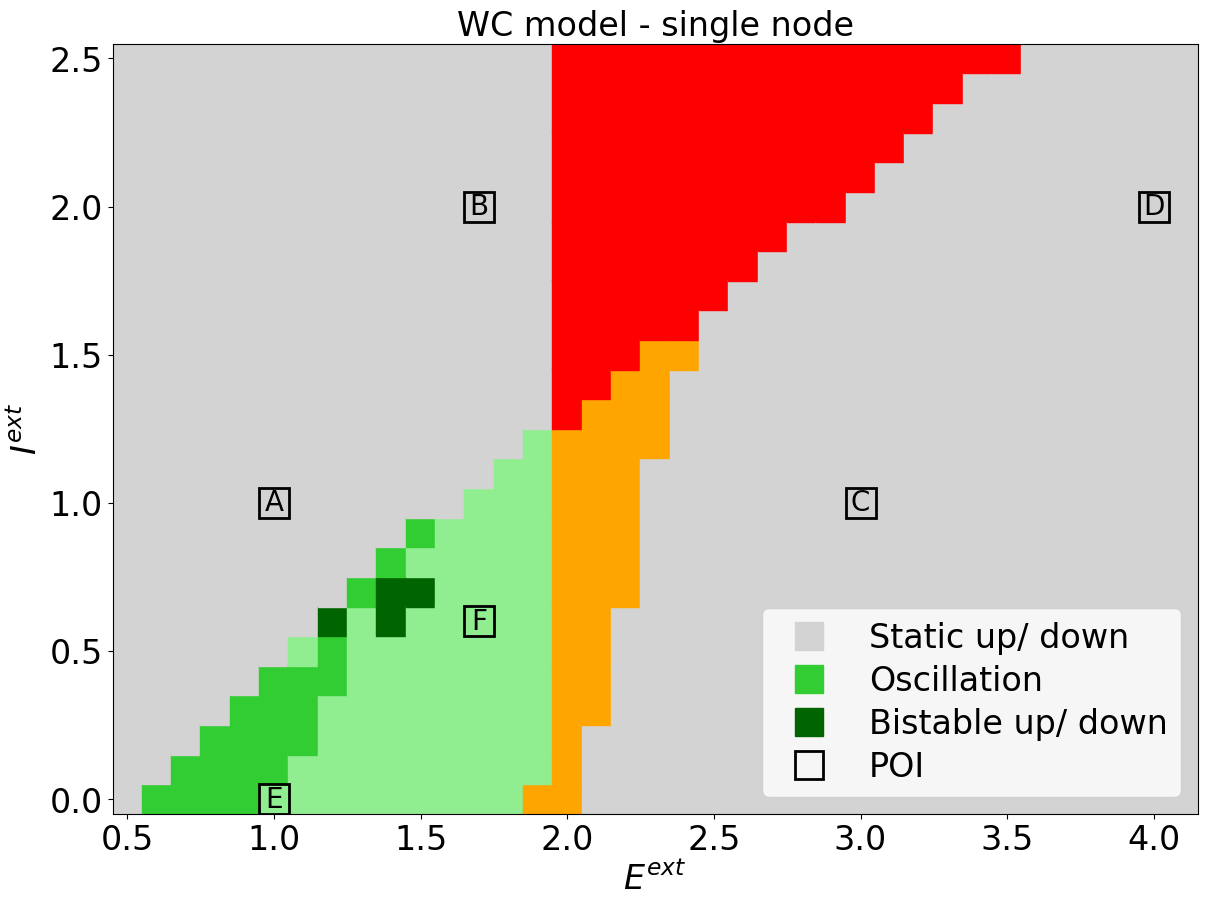

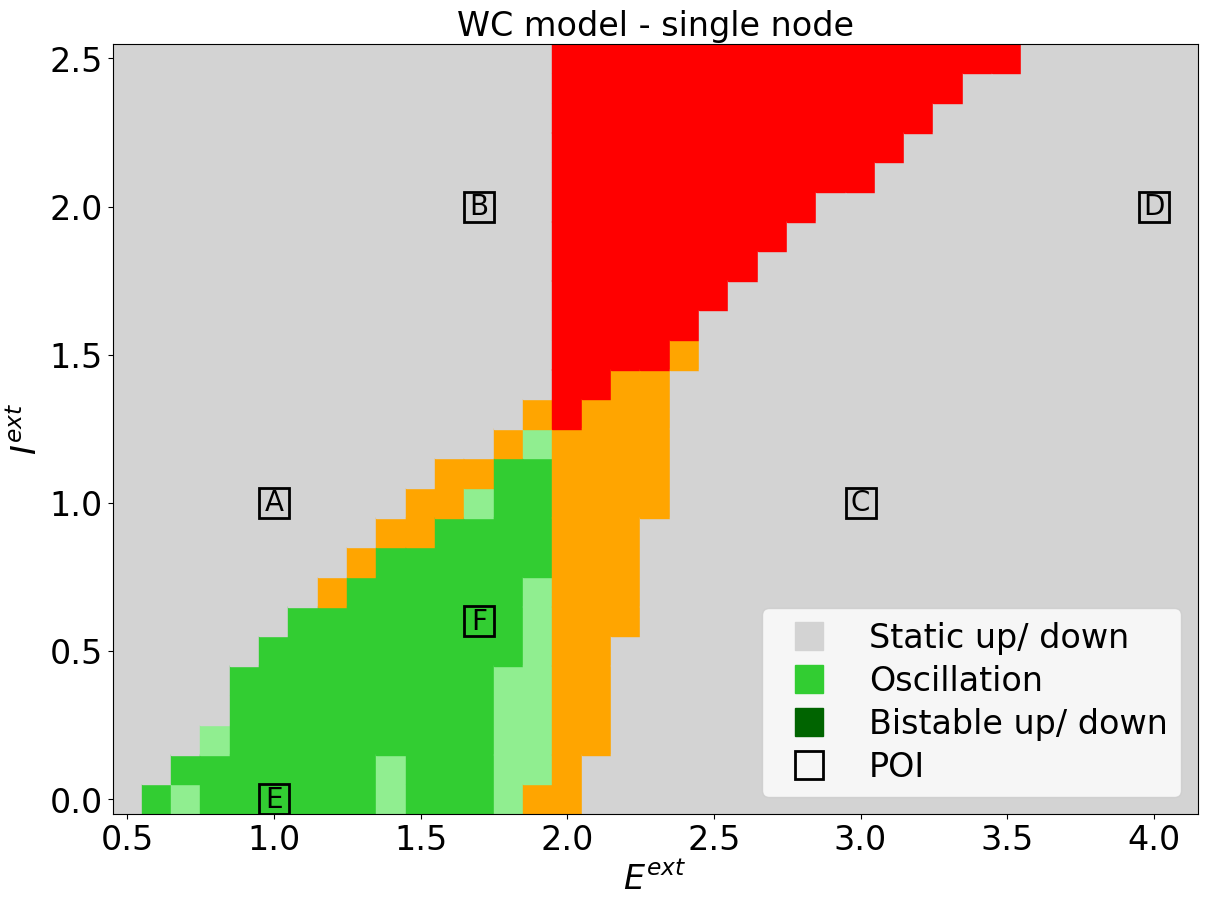

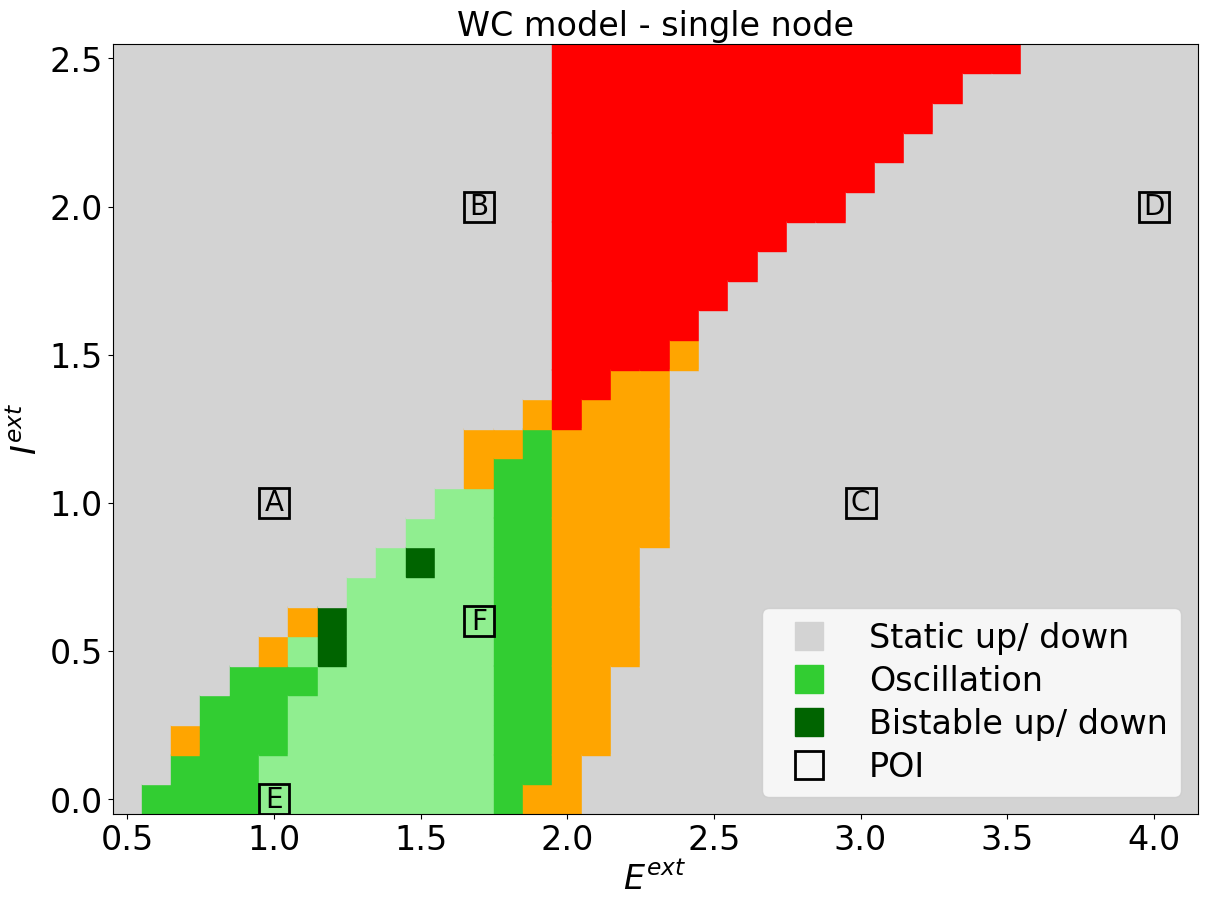

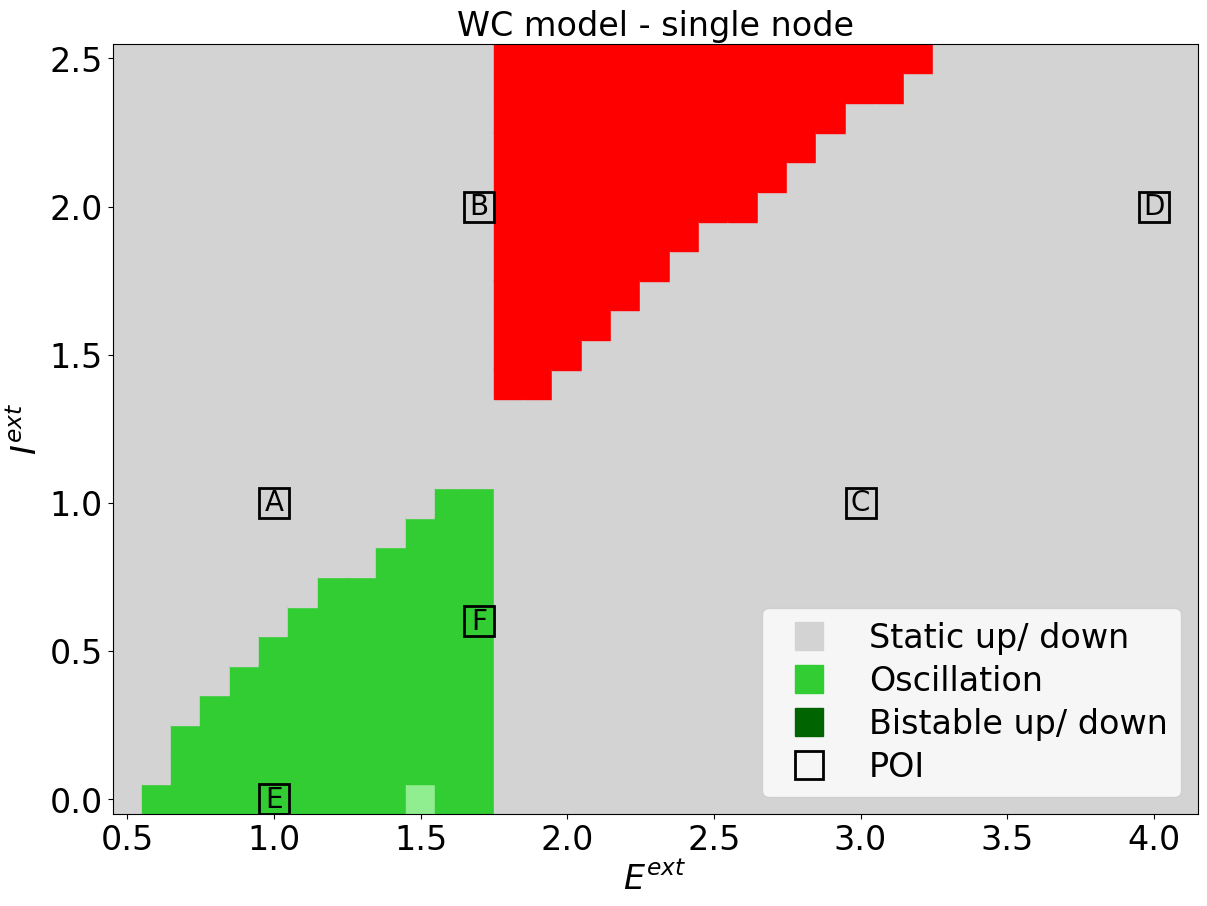

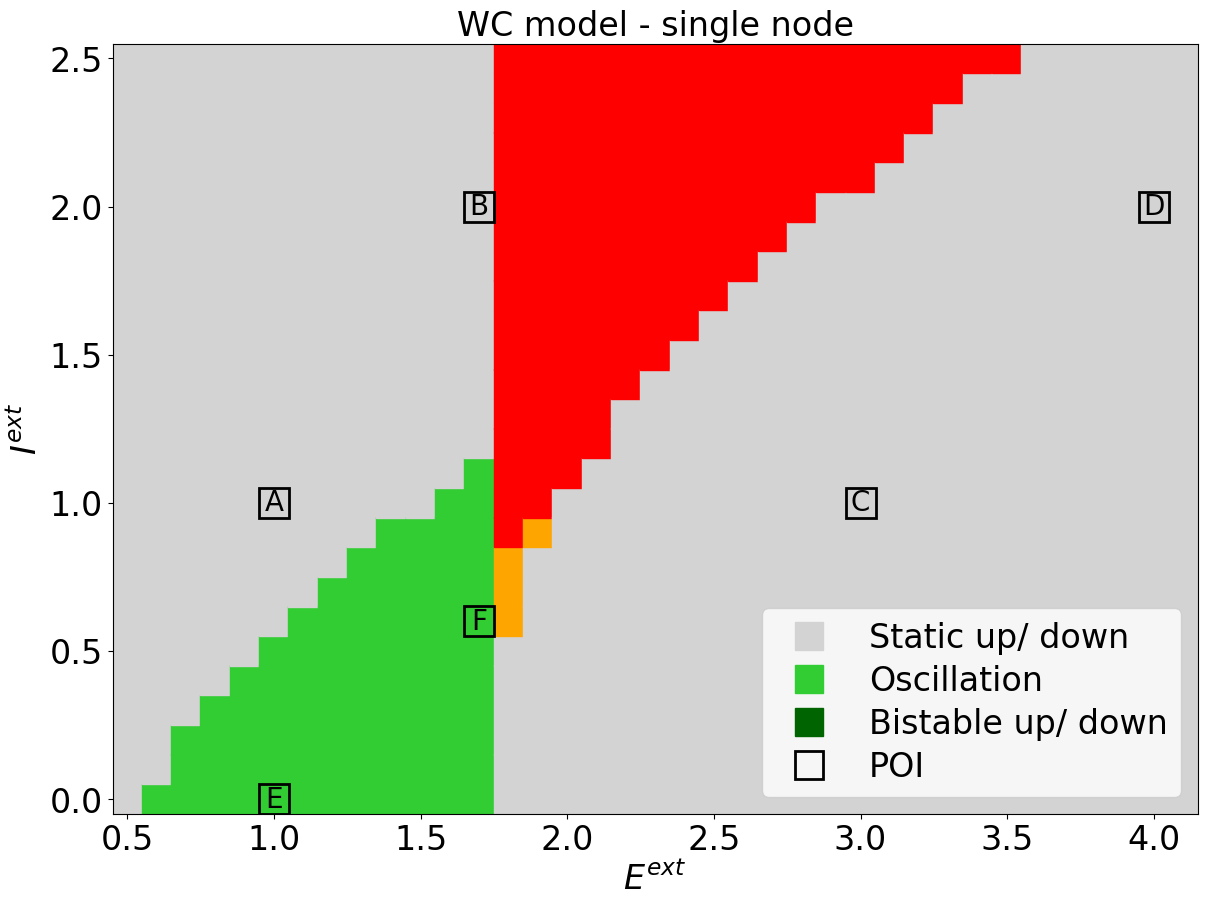

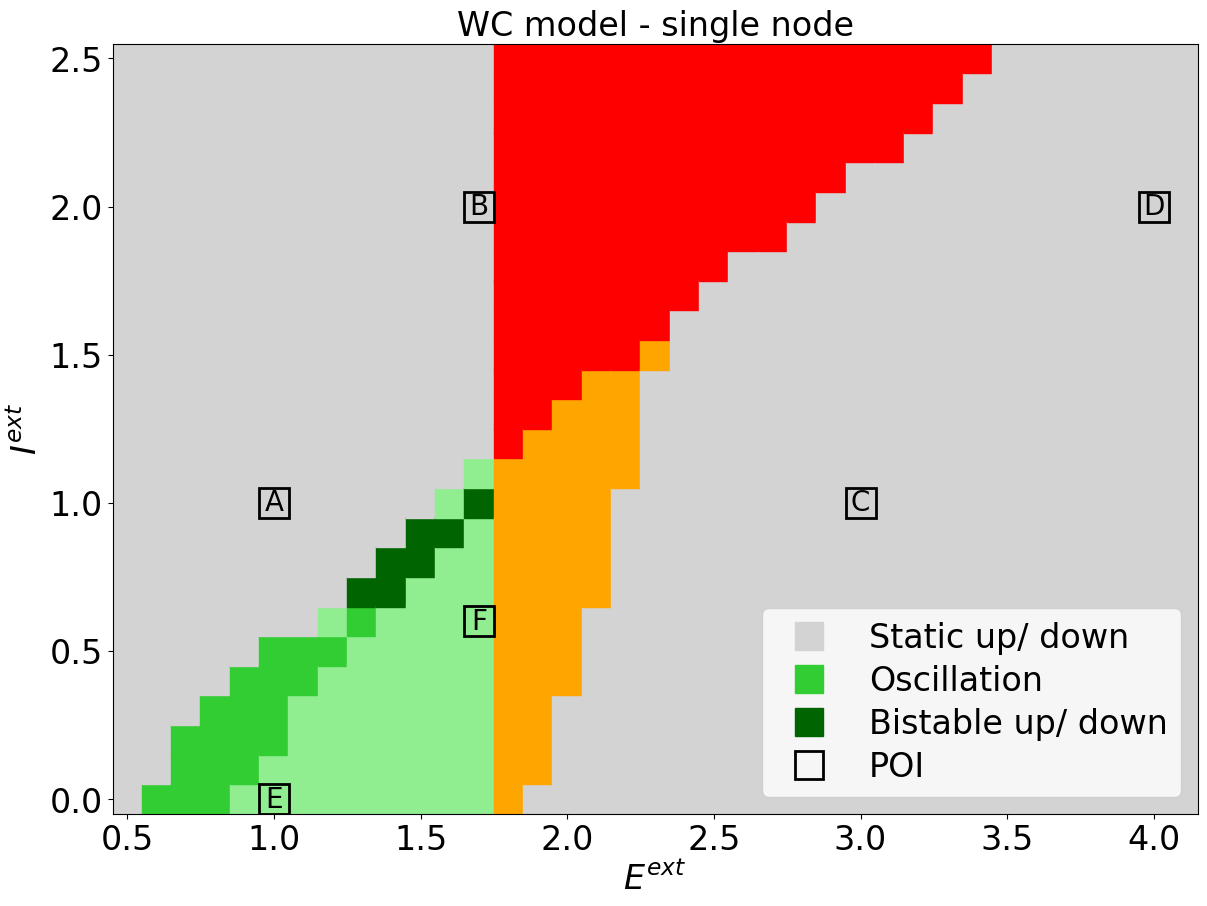

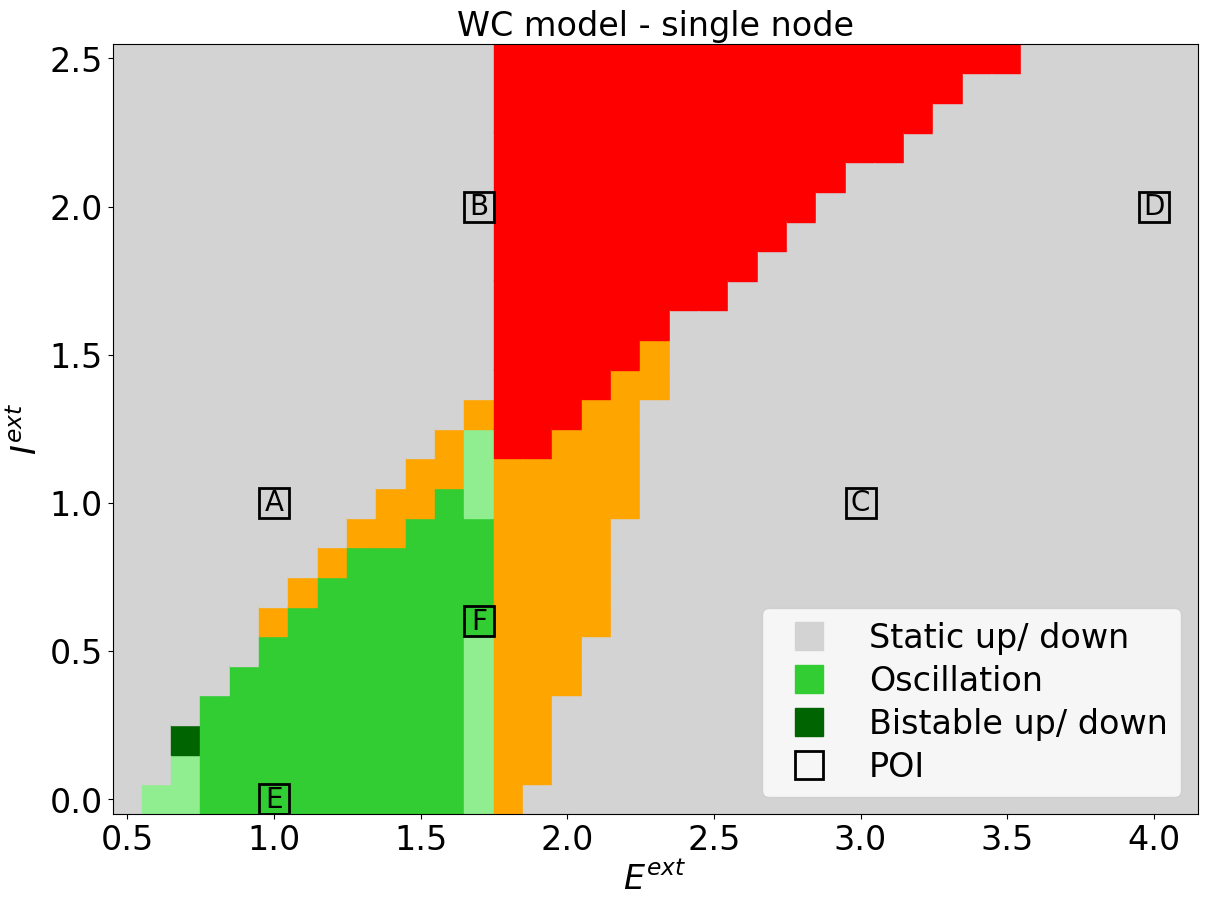

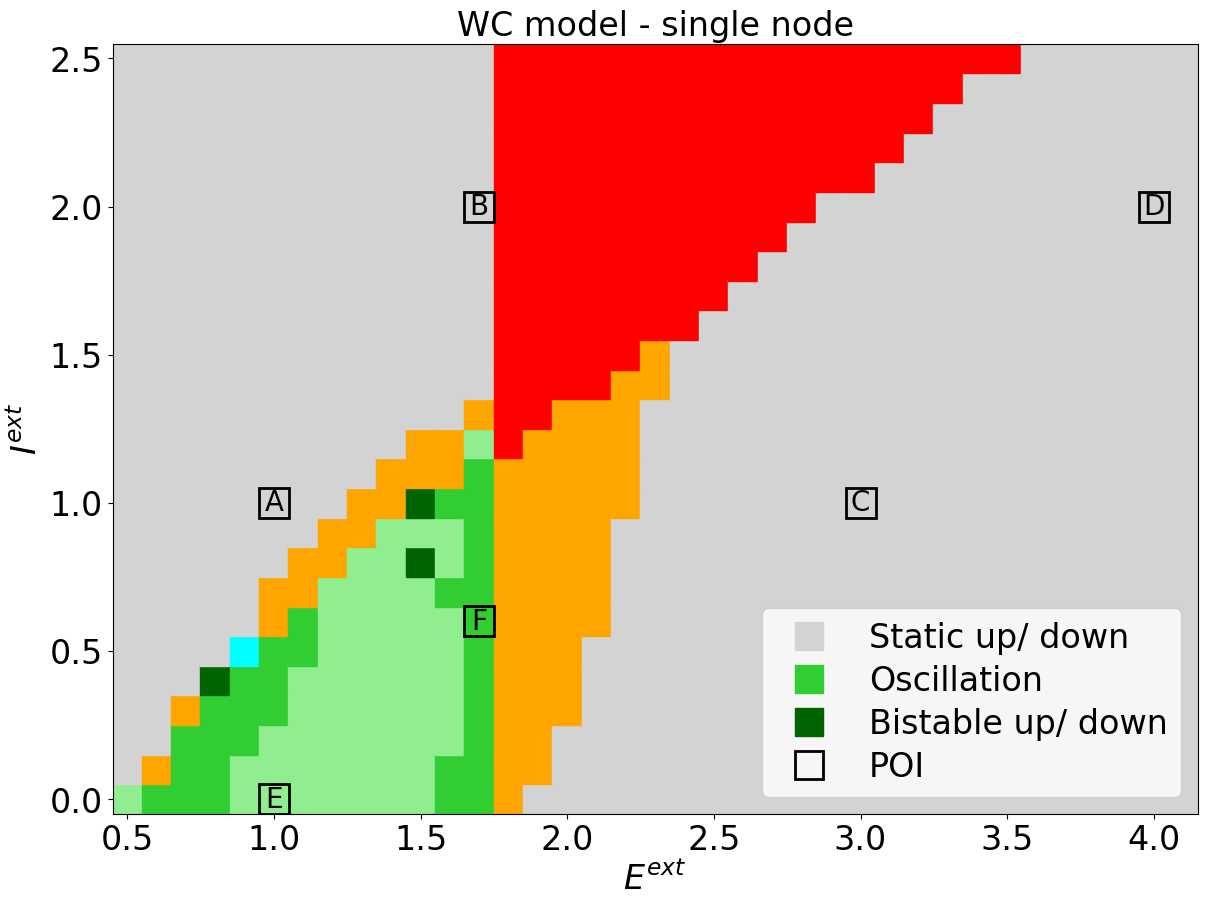

In [218]:
for i in range(len(cmats)):
    for ci in range(len(coupling_array)):
        for di in range(len(delay_array)):

            if ci == 0 and di != 0:
                continue

            if i != 1:
                continue

            #title = "cmat = " + str(i) + ", coupling = " + str(coupling_array[ci]) + ", delay = " + str(delay_array[di])
            title = "WC model - single node"
            filename = "statespace_" + str(i) + "_" + str(ci) + "_" + str(di) + ".png"
            plot_statespace(statespace[i][ci][di], coords_all, title, os.path.join(dir, filename), legend=True)

172 762
35 566


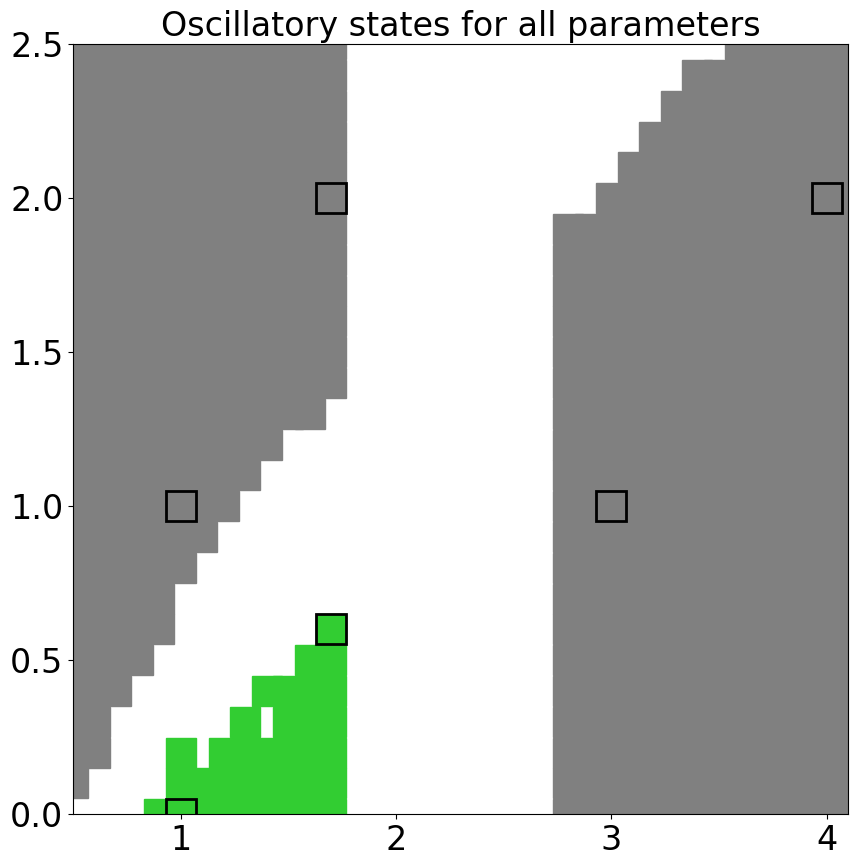

In [110]:
oscstates_000 = []
for si in range(len(statespace[0][0][0]["state"])):
    if statespace[0][0][0]["state"][si][0] == "osc":
        oscstates_000.append(statespace[0][0][0]["coords"][si])

statstates_000 = []
for si in range(len(statespace[0][0][0]["state"])):
    if statespace[0][0][0]["state"][si][0] == "static":
        statstates_000.append(statespace[0][0][0]["coords"][si])

print(len(oscstates_000), len(statstates_000))


for i in range(len(cmats)):
    for ci in range(len(coupling_array)):
        for di in range(len(delay_array)):

            if [i, ci, di] == [0,0,0]:
                continue

            if ci == 0 and di != 0:
                continue

            #print(i, ci, di)

            delind = []

            for coi in range(len(oscstates_000)):
                coords = oscstates_000[coi]
                oscstate = False

                for si in range(len(statespace[i][ci][di]["state"])):
                    if statespace[i][ci][di]["coords"][si] == coords:
                        if statespace[i][ci][di]["state"][si][0] == "osc":
                            oscstate = True

                if not oscstate:
                    delind.append(coi)

            for coi in reversed(delind):
                oscstates_000.pop(coi)

            
            delind = []

            for coi in range(len(statstates_000)):
                coords = statstates_000[coi]
                statstate = False

                for si in range(len(statespace[i][ci][di]["state"])):
                    if statespace[i][ci][di]["coords"][si] == coords:
                        if statespace[i][ci][di]["state"][si][0] == "static":
                            statstate = True

                if not statstate:
                    delind.append(coi)

            for coi in reversed(delind):
                statstates_000.pop(coi)

print(len(oscstates_000), len(statstates_000))

fig, ax = plt.subplots(figsize=(10,10))

for cs in statstates_000:
    ax.plot(cs[0], cs[1], marker="s", markersize=ms, color=cols[0])
for co in oscstates_000:
    ax.plot(co[0], co[1], marker="s", markersize=ms, color=cols[1])
for poi in coords_all:
    ax.plot(poi[0], poi[1], marker="s", markersize=ms, color=mpl.colors.to_rgba('b', 0.0), markeredgewidth=2, markeredgecolor="black")

ax.set_xlim(emin, emax)
ax.set_ylim(imin, imax)
ax.set_title("Oscillatory states for all parameters")

plt.savefig(os.path.join(dir, "osc_states.png"))
plt.show()

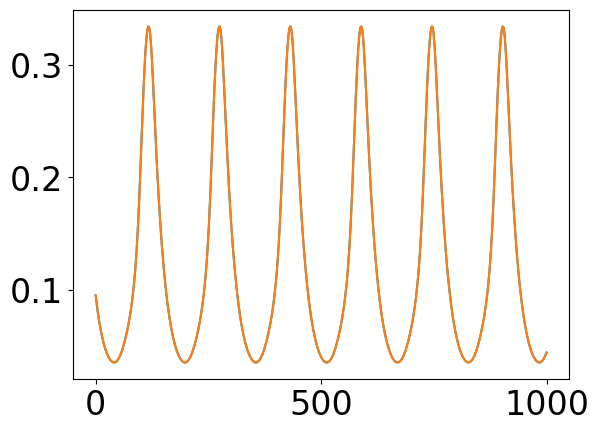

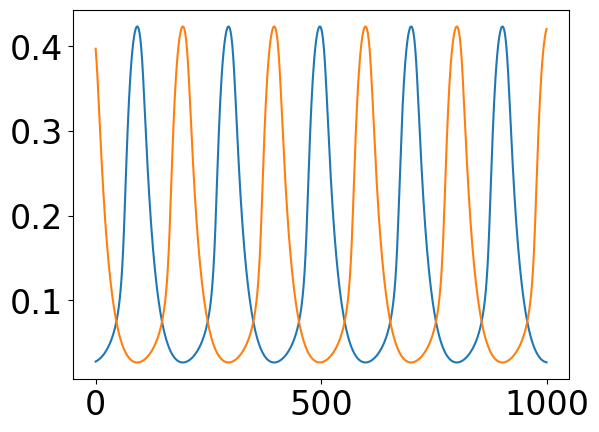

In [132]:
i, ci, di = 1, 3, 2
e_, i_ = 1., 0.

dmat = delay_array[di] * cmats[i] * 20.
                
model = WCModel(Cmat=cmats[i], Dmat=dmat)
model.params.K_gl = coupling_array[ci]
dt = 0.1
model.params.dt = dt

dur = 4.
i00, i01 = int(0.5 * dur * 1000/dt - 1000/dt), int(0.5 * dur * 1000/dt) - 1
i10, i11 = int(-1000/dt), -1

model.params['duration'] = dur * 1000 # Simulation time, ms
test_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
test_input = np.vstack( ([test_input]*N))
stim_period = 19.
test_input[0,:int(stim_period/dt)] = 5. * np.sin(2.*np.pi*np.arange(0,stim_period,dt)/stim_period)
test_input[1,:int(stim_period/dt)] = 5. * np.sin(2.*np.pi*np.arange(0,stim_period,dt)/stim_period)

test_input[0,i01+1:i01+1+int(stim_period/dt)] = 5. * np.sin(2.*np.pi*np.arange(0,stim_period,dt)/stim_period)
test_input[1,i01+1:i01+1+int(stim_period/dt)] = -5. * np.sin(2.*np.pi*np.arange(0,stim_period,dt)/stim_period)

model.params.exc_ext = e_ + test_input
model.params.inh_ext = i_

model.run()

plt.plot(model.exc[0,i01-1000:i01])
plt.plot(model.exc[1,i01-1000:i01])
plt.show()

plt.plot(model.exc[0,i11-1000:i11])
plt.plot(model.exc[1,i11-1000:i11])
plt.show()